In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import DataFrame
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import math

## Data Processing

In [39]:
country_info_path = "../data/country_info.csv"
artists_similarity_path = "../data/jaccard_normalized_artists_similarity.csv"
genres_similarity_path = "../data/jaccard_normalized_genres_similarity.csv"
votes_path = "../data/votes.csv"

country_info_df = pd.read_csv(country_info_path)

artists_similarity_df = pd.read_csv(artists_similarity_path)
artists_similarity_array = np.array(artists_similarity_df)
artists_similarity_matrix = artists_similarity_array[:, 1:].tolist()

genres_similarity_df = pd.read_csv(genres_similarity_path)
genres_similarity_array = np.array(genres_similarity_df)
genres_similarity_matrix = genres_similarity_array[:, 1:].tolist()

country_code_list = genres_similarity_df['country'].tolist()
map_code_to_idx = {code: idx for idx, code in enumerate(country_code_list)}
country_num = len(country_code_list)

votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix_total = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_jury = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_tele = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    # if vote[0] != 2023 or vote[1] != 'final':  # only consider 2023, final and total points
    # continue
    from_country_code, to_country_code, total_points = vote[2], vote[3], vote[-3]
    if from_country_code not in country_code_list or to_country_code not in country_code_list:
        continue
    votes_matrix_total[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += total_points
    if not math.isnan(vote[-2]):
        votes_matrix_tele[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-2]
    if not math.isnan(vote[-1]):
        votes_matrix_jury[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-1]

## Clustering

Same as clustering_distance.ipynb

In [40]:
def clustering_one_and_visualize_by_pca(D, V, num_clusters, method='KMeans'):
    # Preprocess data: Impute missing values and normalize
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    D_imputed = imputer.fit_transform(D)
    V_imputed = imputer.transform(V)  # Use the same transformation for V
    
    D_scaled = scaler.fit_transform(D_imputed)
    V_scaled = scaler.transform(V_imputed)  # Use the same transformation for V

    # Clustering
    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=42)
    elif method == 'SpectralClustering':
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=42, assign_labels="discretize")
    
    labels = clustering.fit_predict(D_scaled)  # Only fit on D

    # Random labels for comparison
    random_labels = np.random.randint(num_clusters, size=len(D))

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    D_pca = pca.fit_transform(D_scaled)
    V_pca = pca.transform(V_scaled)  # Use the same PCA transformation for V

    # Visualization of original clustering
    plt.figure(figsize=(24, 12))

    plt.subplot(2, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of D (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of V (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    # Visualization of random clustering
    plt.subplot(2, 2, 3)
    for cluster in range(num_clusters):
        cluster_points = D_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of D (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 4)
    for cluster in range(num_clusters):
        cluster_points = V_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of V (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluation
    silhouette_score_D = silhouette_score(D_scaled, labels)
    silhouette_score_V = silhouette_score(V_scaled, labels)
    silhouette_score_D_random = silhouette_score(D_scaled, random_labels)
    silhouette_score_V_random = silhouette_score(V_scaled, random_labels)

    print(f"The silhouette score for D data (Original) is: {silhouette_score_D}")
    print(f"The silhouette score for V data (Original) is: {silhouette_score_V}")
    print(f"The silhouette score for D data (Random) is: {silhouette_score_D_random}")
    print(f"The silhouette score for V data (Random) is: {silhouette_score_V_random}")

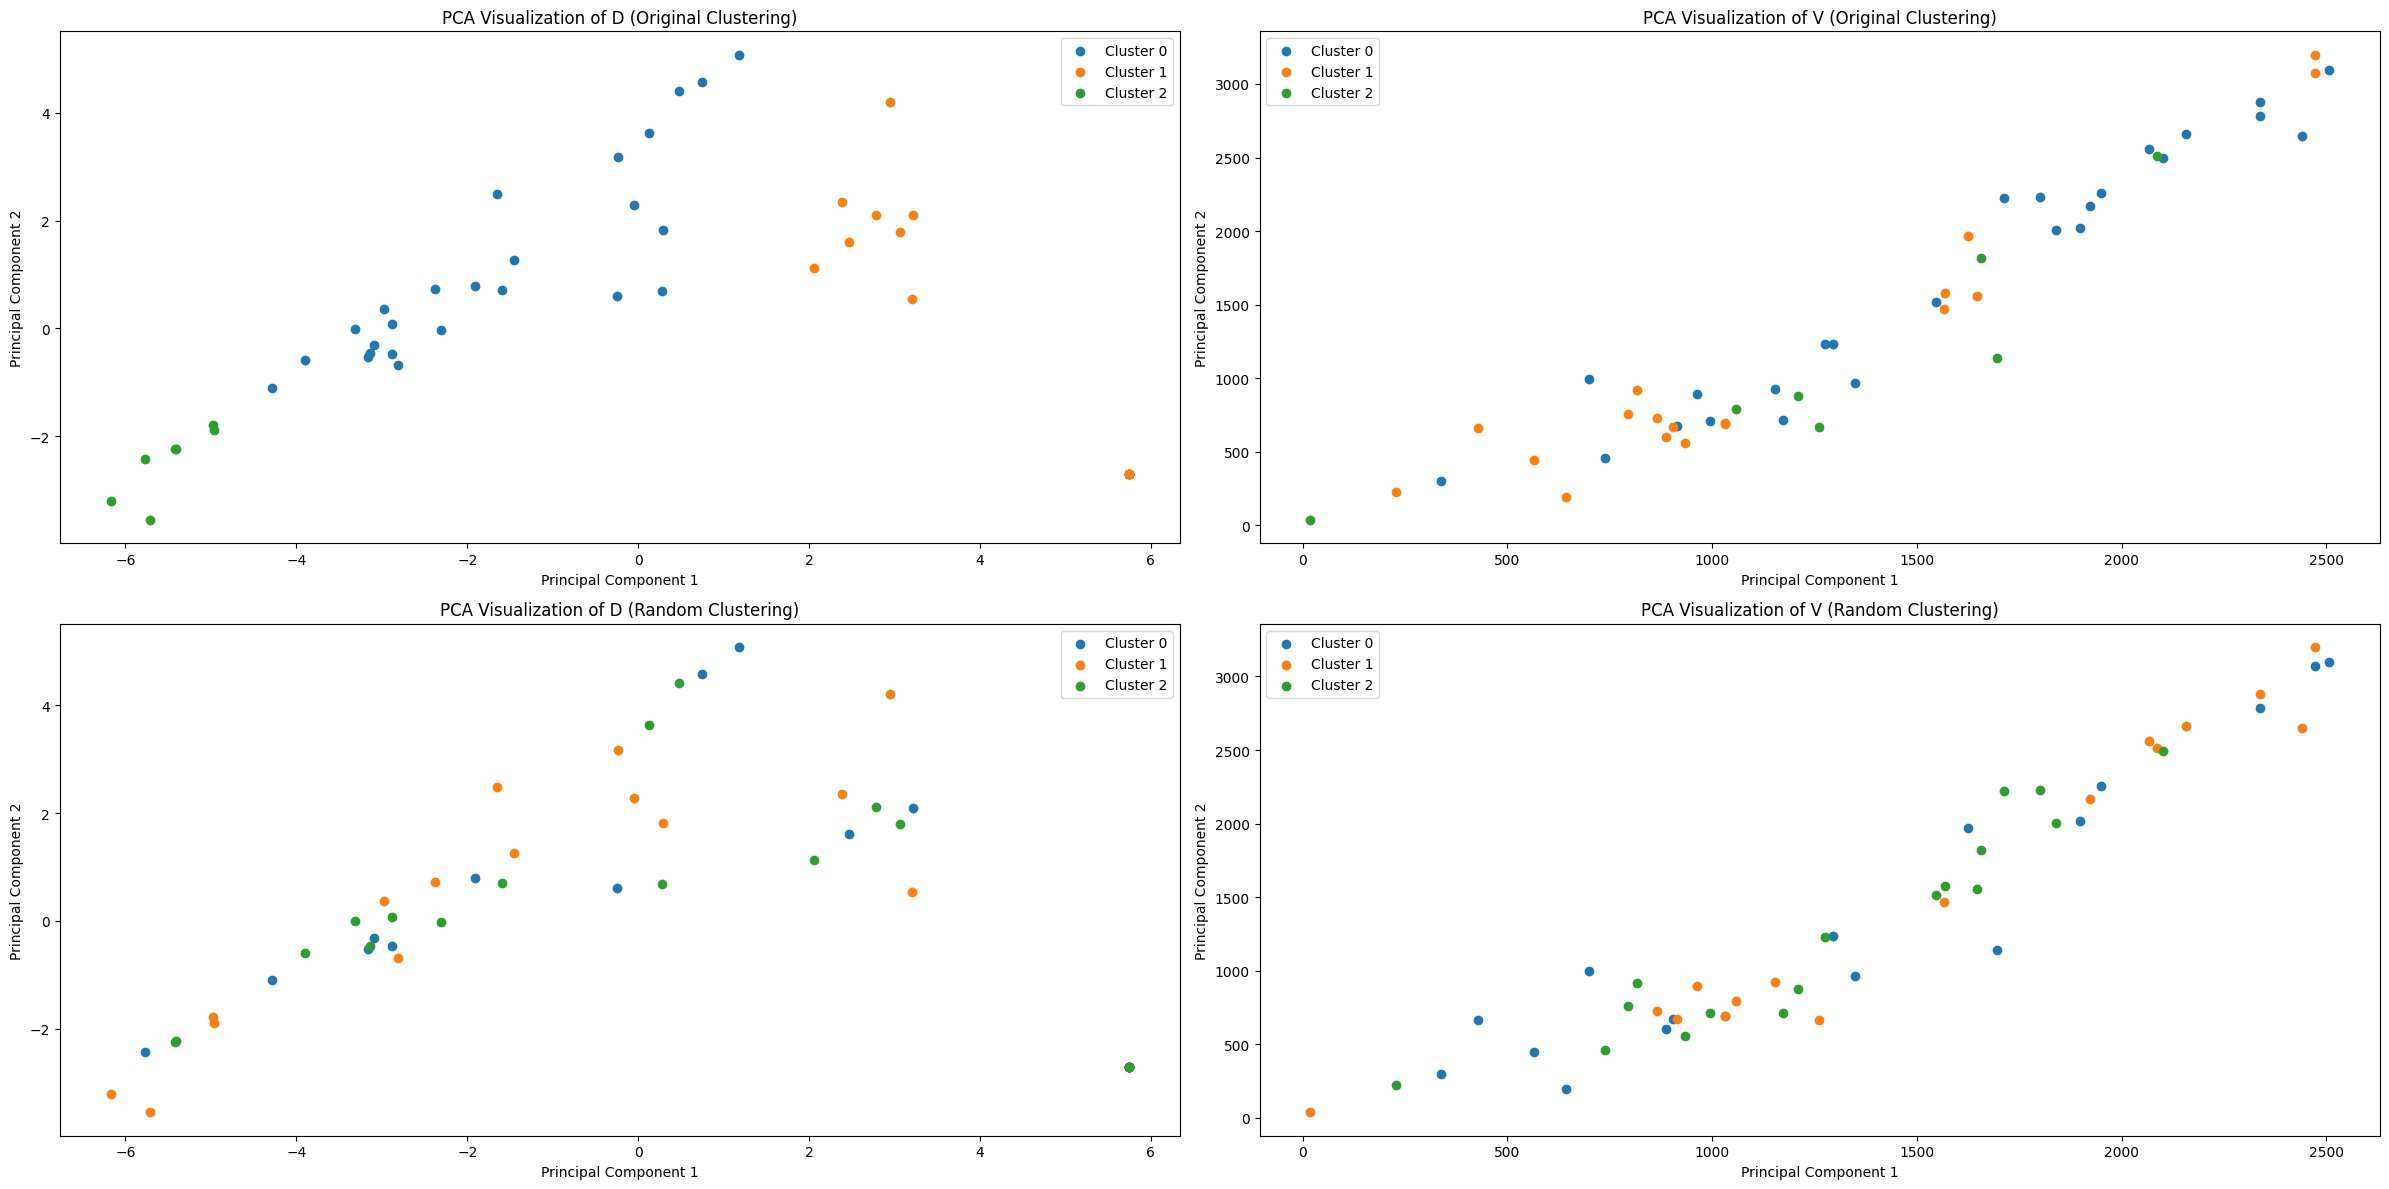

The silhouette score for D data (Original) is: 0.21094828288866002
The silhouette score for V data (Original) is: -0.025146430745463313
The silhouette score for D data (Random) is: -0.02568778719494139
The silhouette score for V data (Random) is: -0.041937006579283266


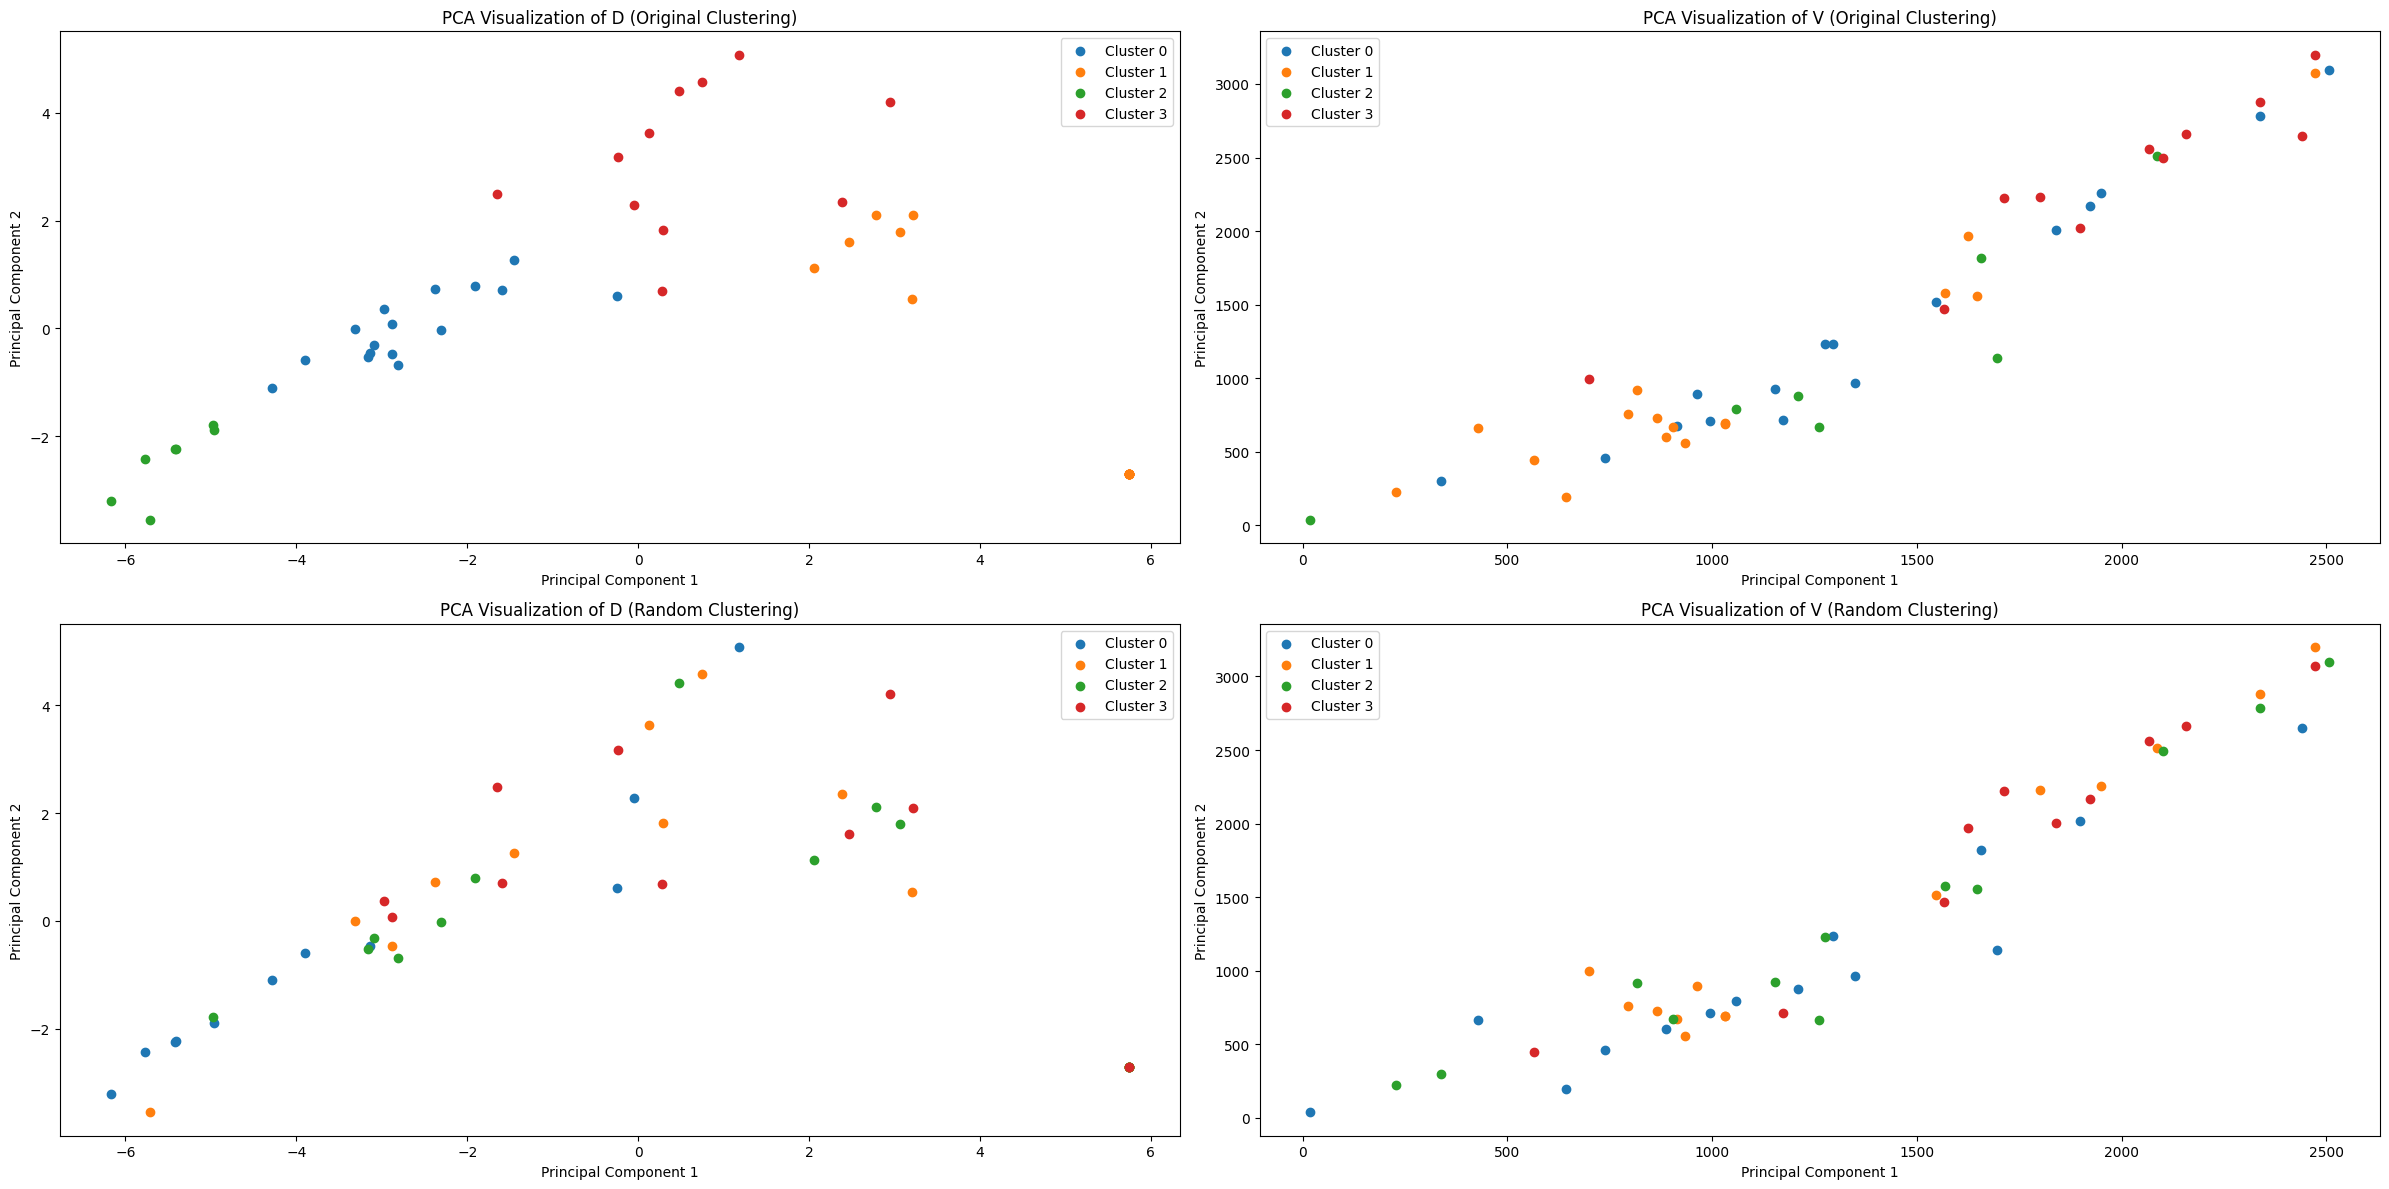

The silhouette score for D data (Original) is: 0.20535540597417973
The silhouette score for V data (Original) is: -0.02120503010800269
The silhouette score for D data (Random) is: -0.05480014525076252
The silhouette score for V data (Random) is: -0.049503257178029086


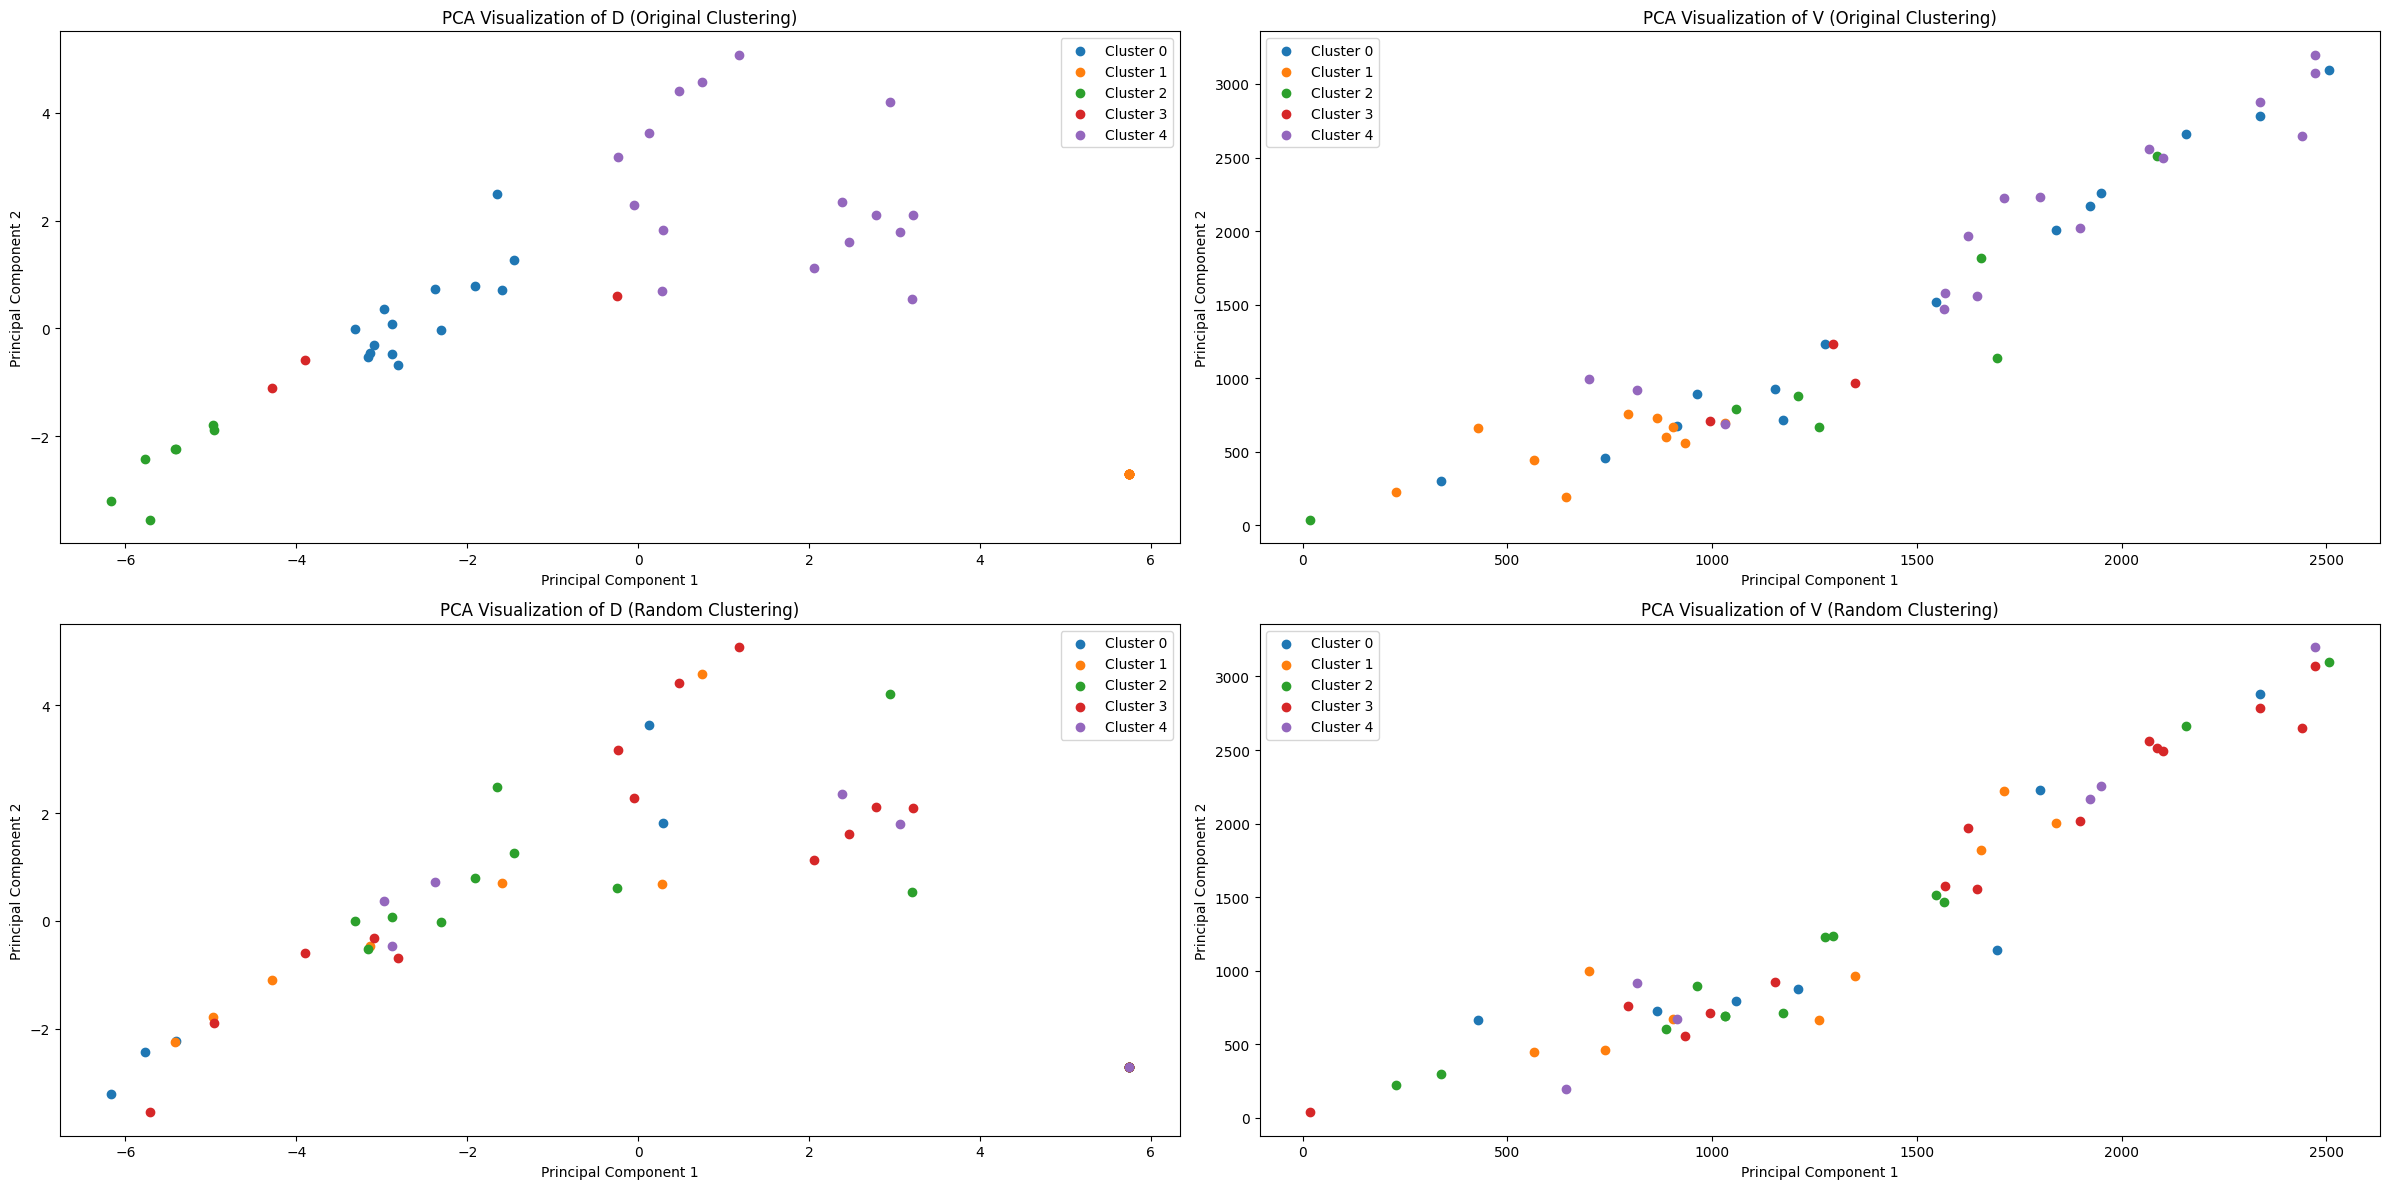

The silhouette score for D data (Original) is: 0.28333725746742755
The silhouette score for V data (Original) is: -0.09205342804963382
The silhouette score for D data (Random) is: -0.062110191558475865
The silhouette score for V data (Random) is: -0.08593727624650584


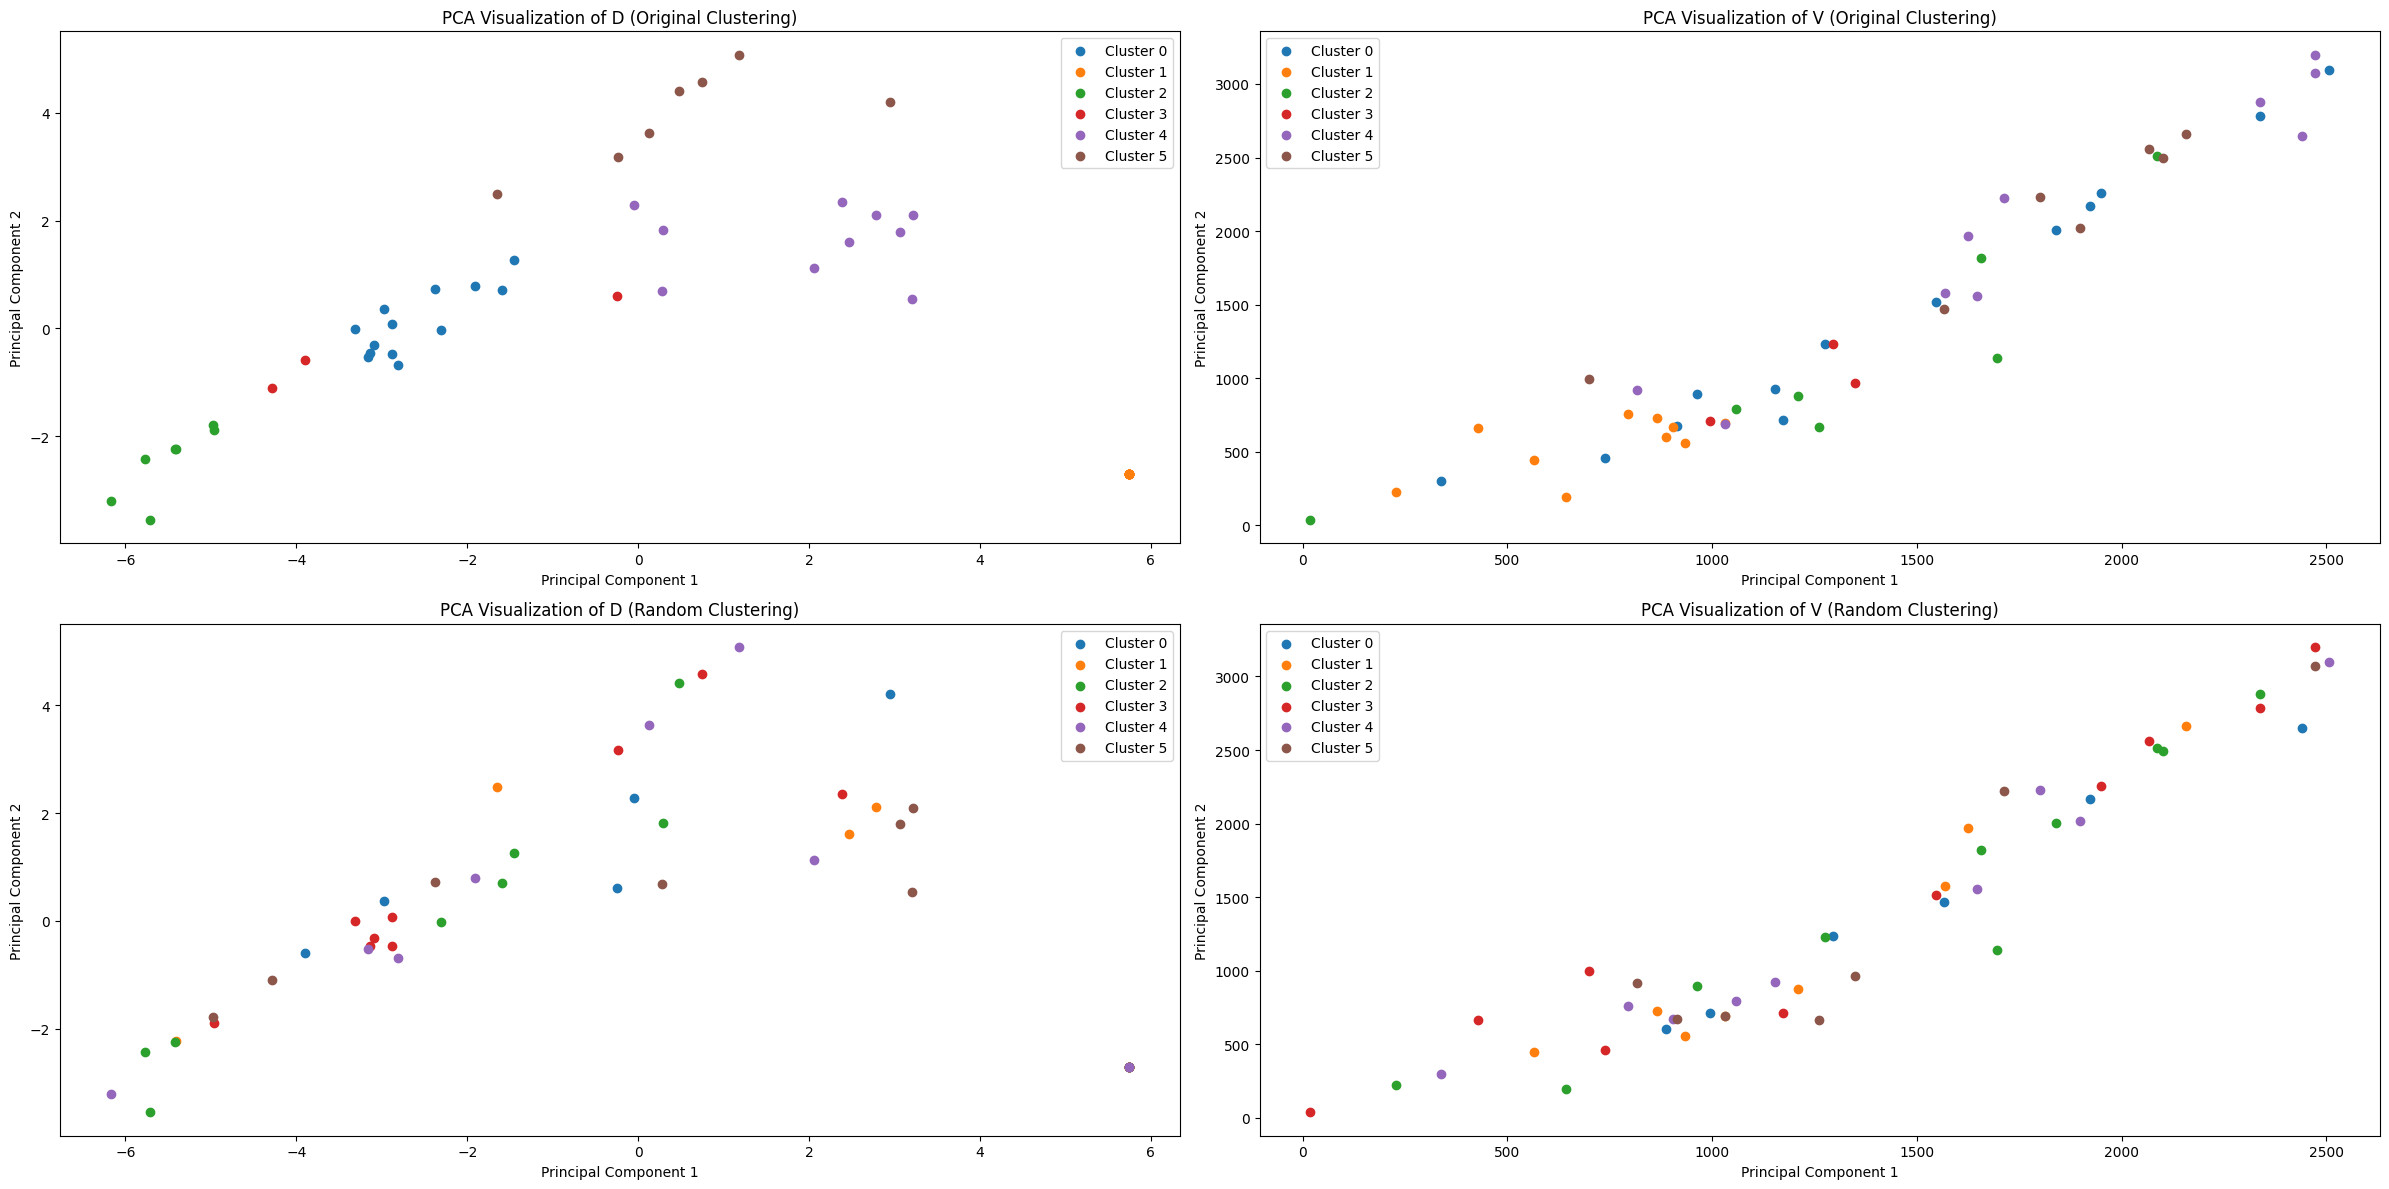

The silhouette score for D data (Original) is: 0.29892921037985626
The silhouette score for V data (Original) is: -0.09529556279791418
The silhouette score for D data (Random) is: -0.08402228497179759
The silhouette score for V data (Random) is: -0.08989606440813386


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


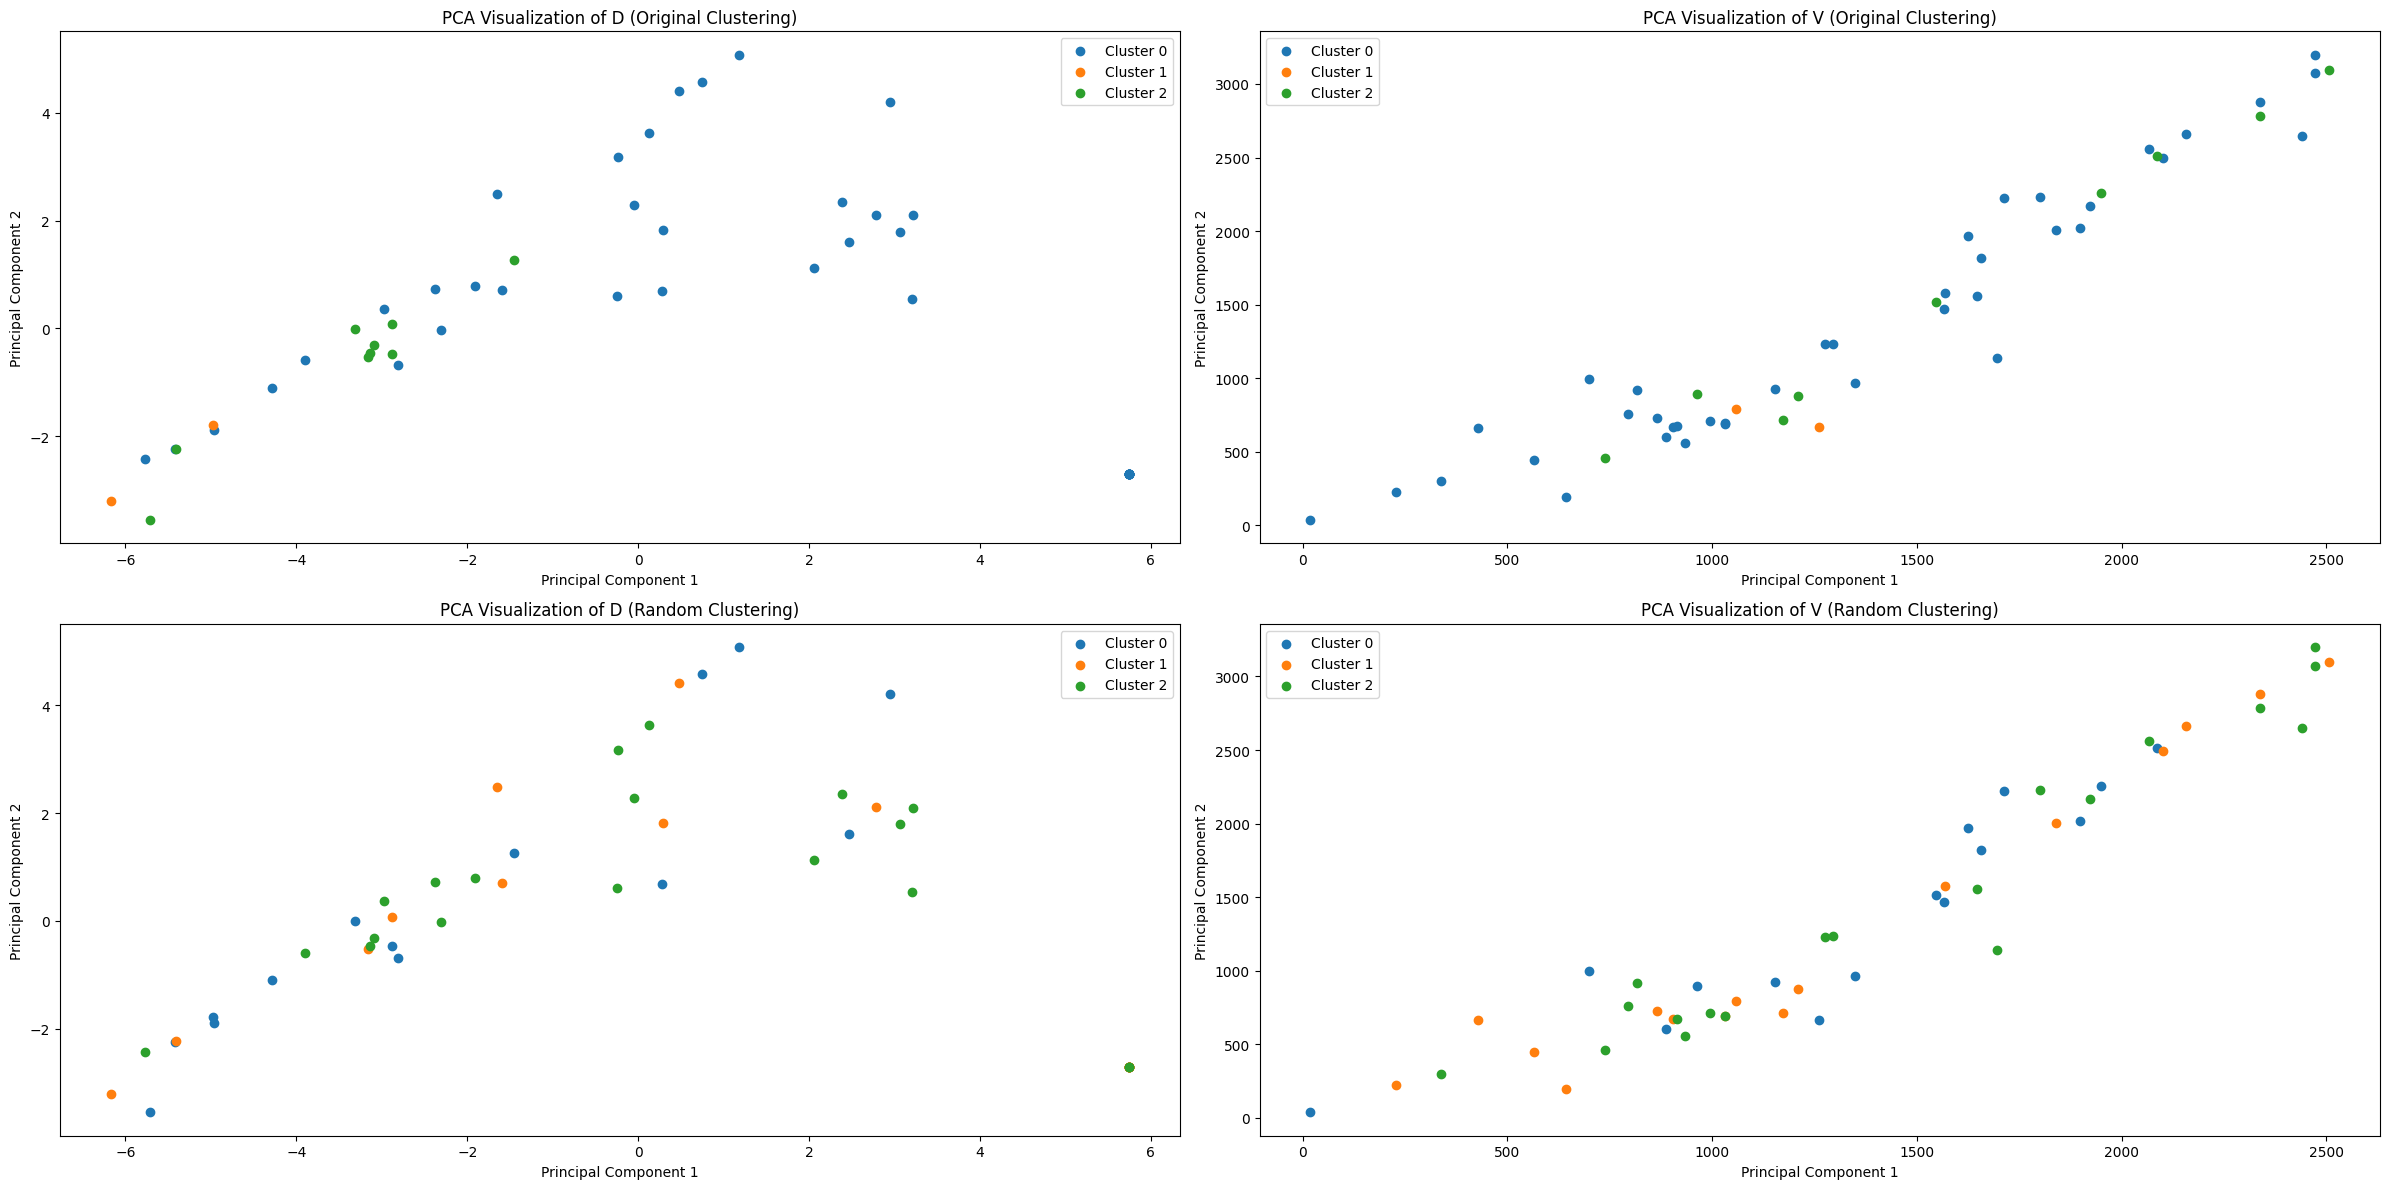

The silhouette score for D data (Original) is: 0.13173443250188635
The silhouette score for V data (Original) is: -0.16558059922769658
The silhouette score for D data (Random) is: 0.0010807734565347557
The silhouette score for V data (Random) is: -0.04032140346144888


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


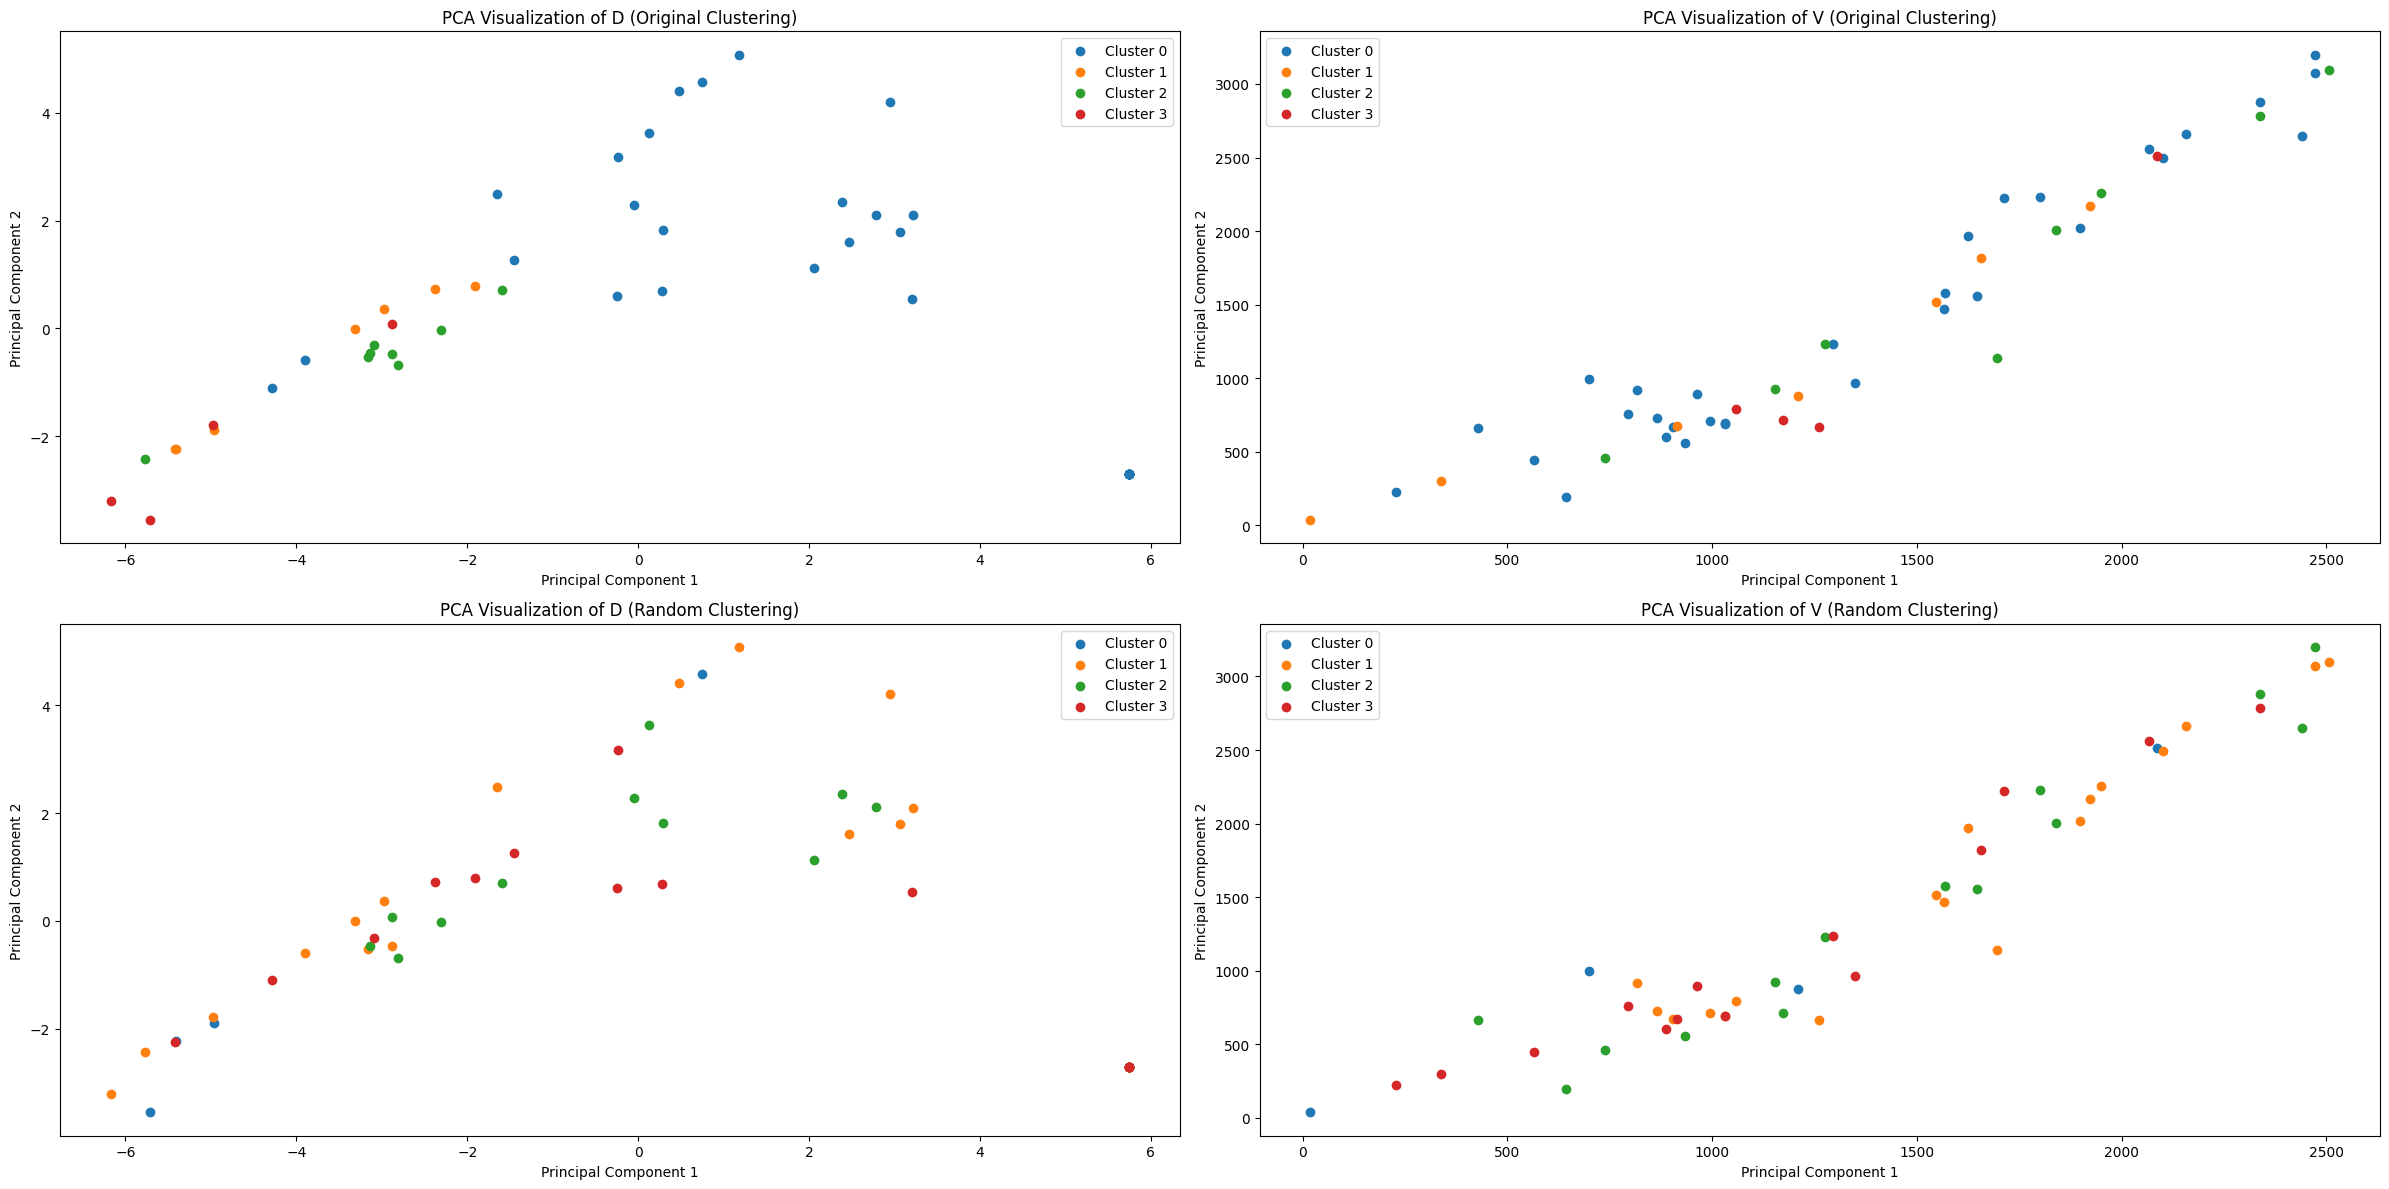

The silhouette score for D data (Original) is: 0.17000021595117548
The silhouette score for V data (Original) is: -0.07814964708433823
The silhouette score for D data (Random) is: -0.043454972630222806
The silhouette score for V data (Random) is: -0.06410605975427003


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


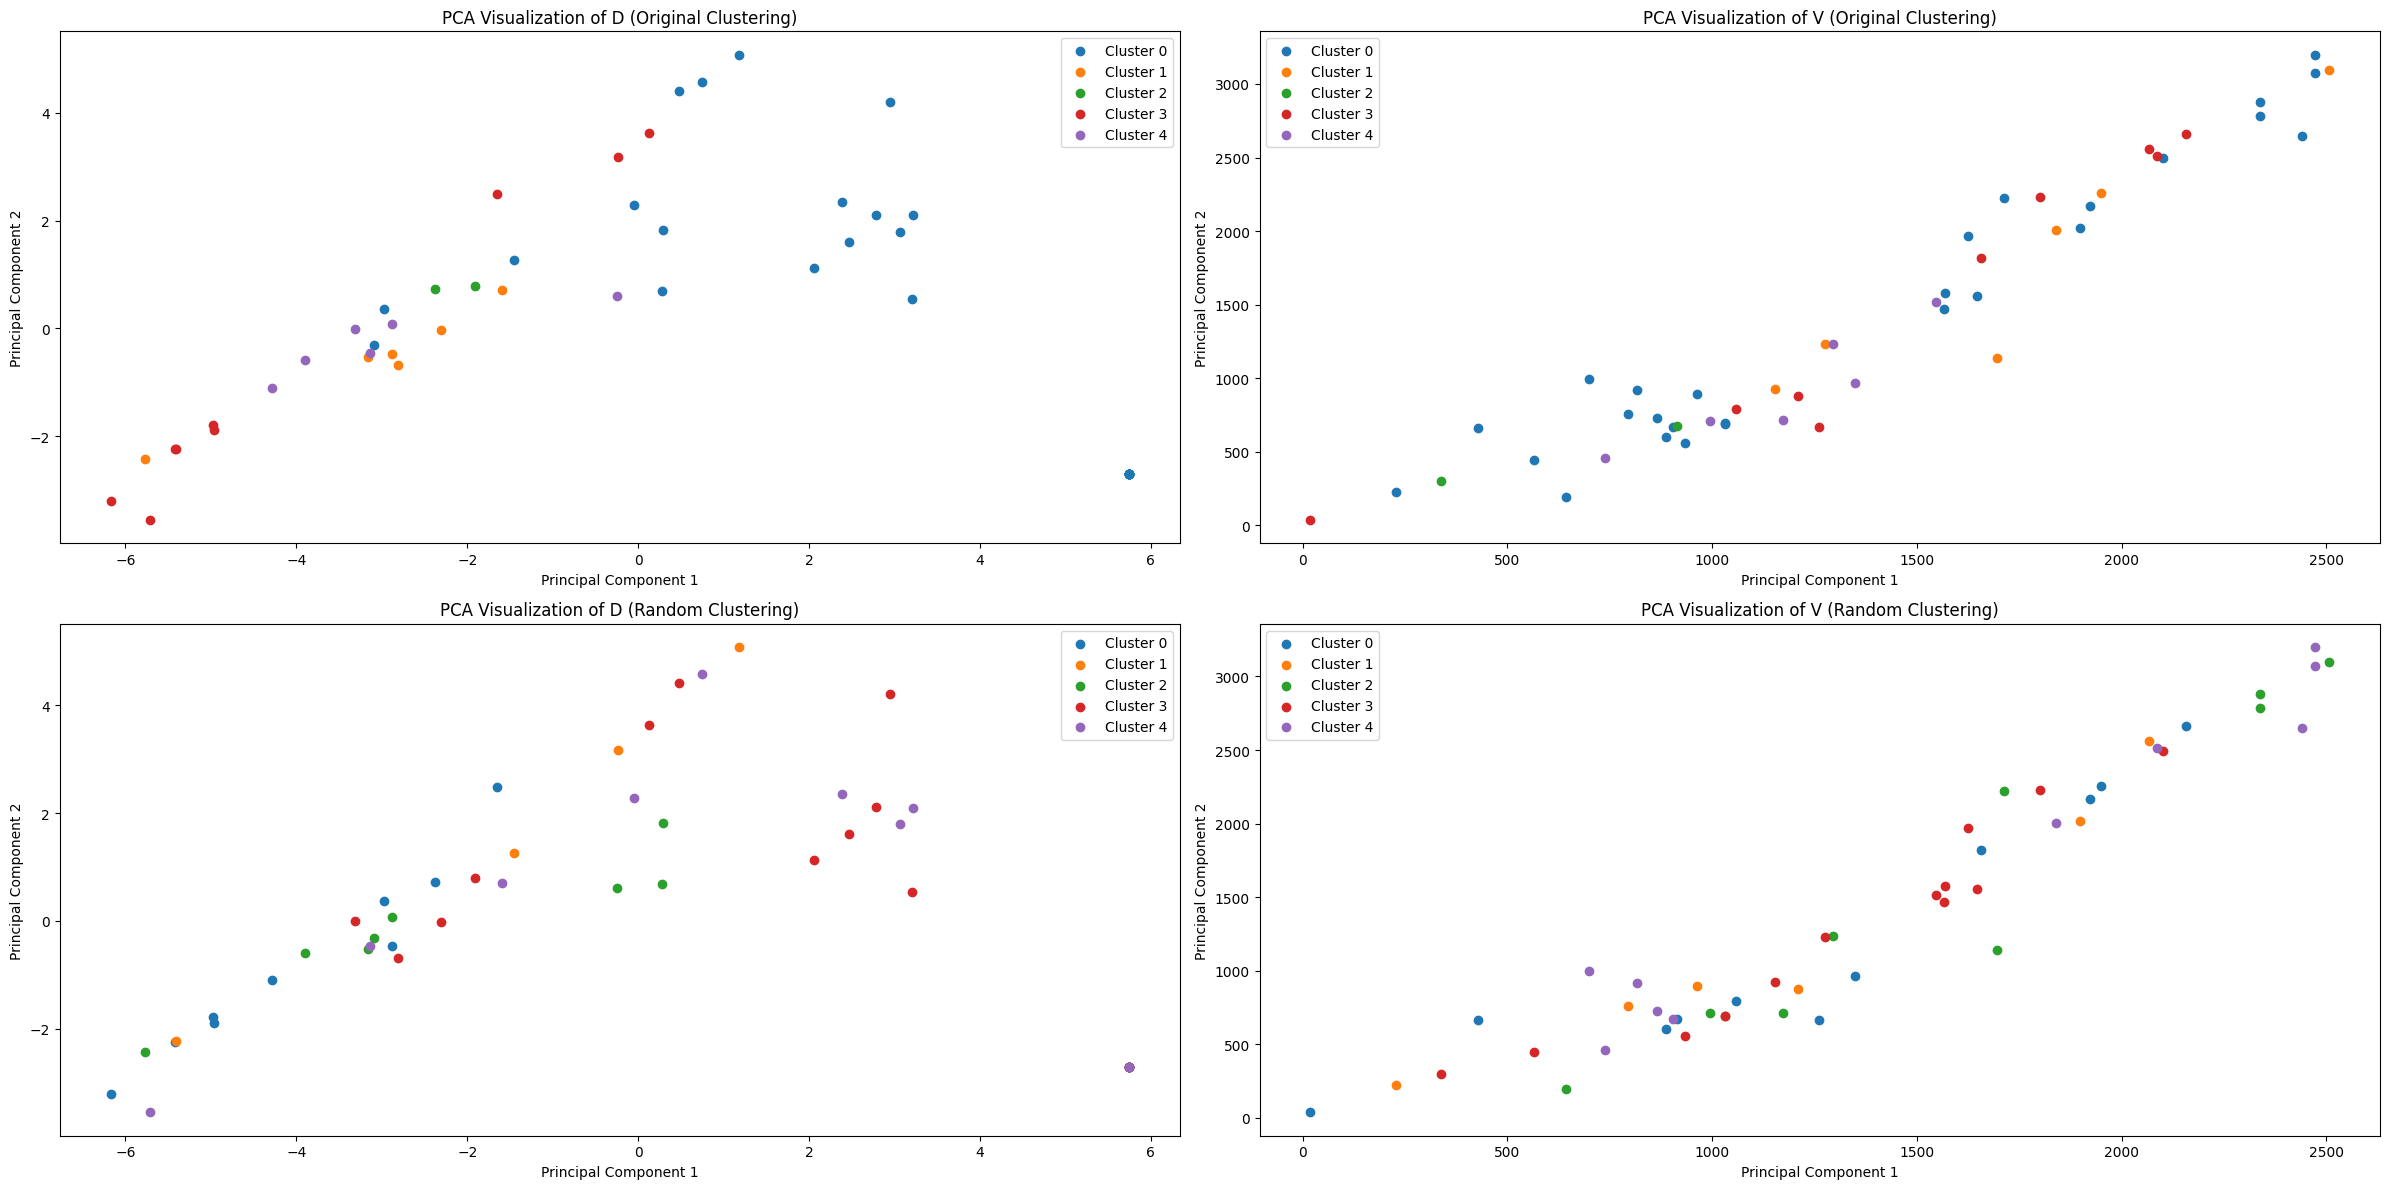

The silhouette score for D data (Original) is: 0.17857658903412485
The silhouette score for V data (Original) is: -0.17359940494917833
The silhouette score for D data (Random) is: -0.06287700562056094
The silhouette score for V data (Random) is: -0.07185982448737574


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


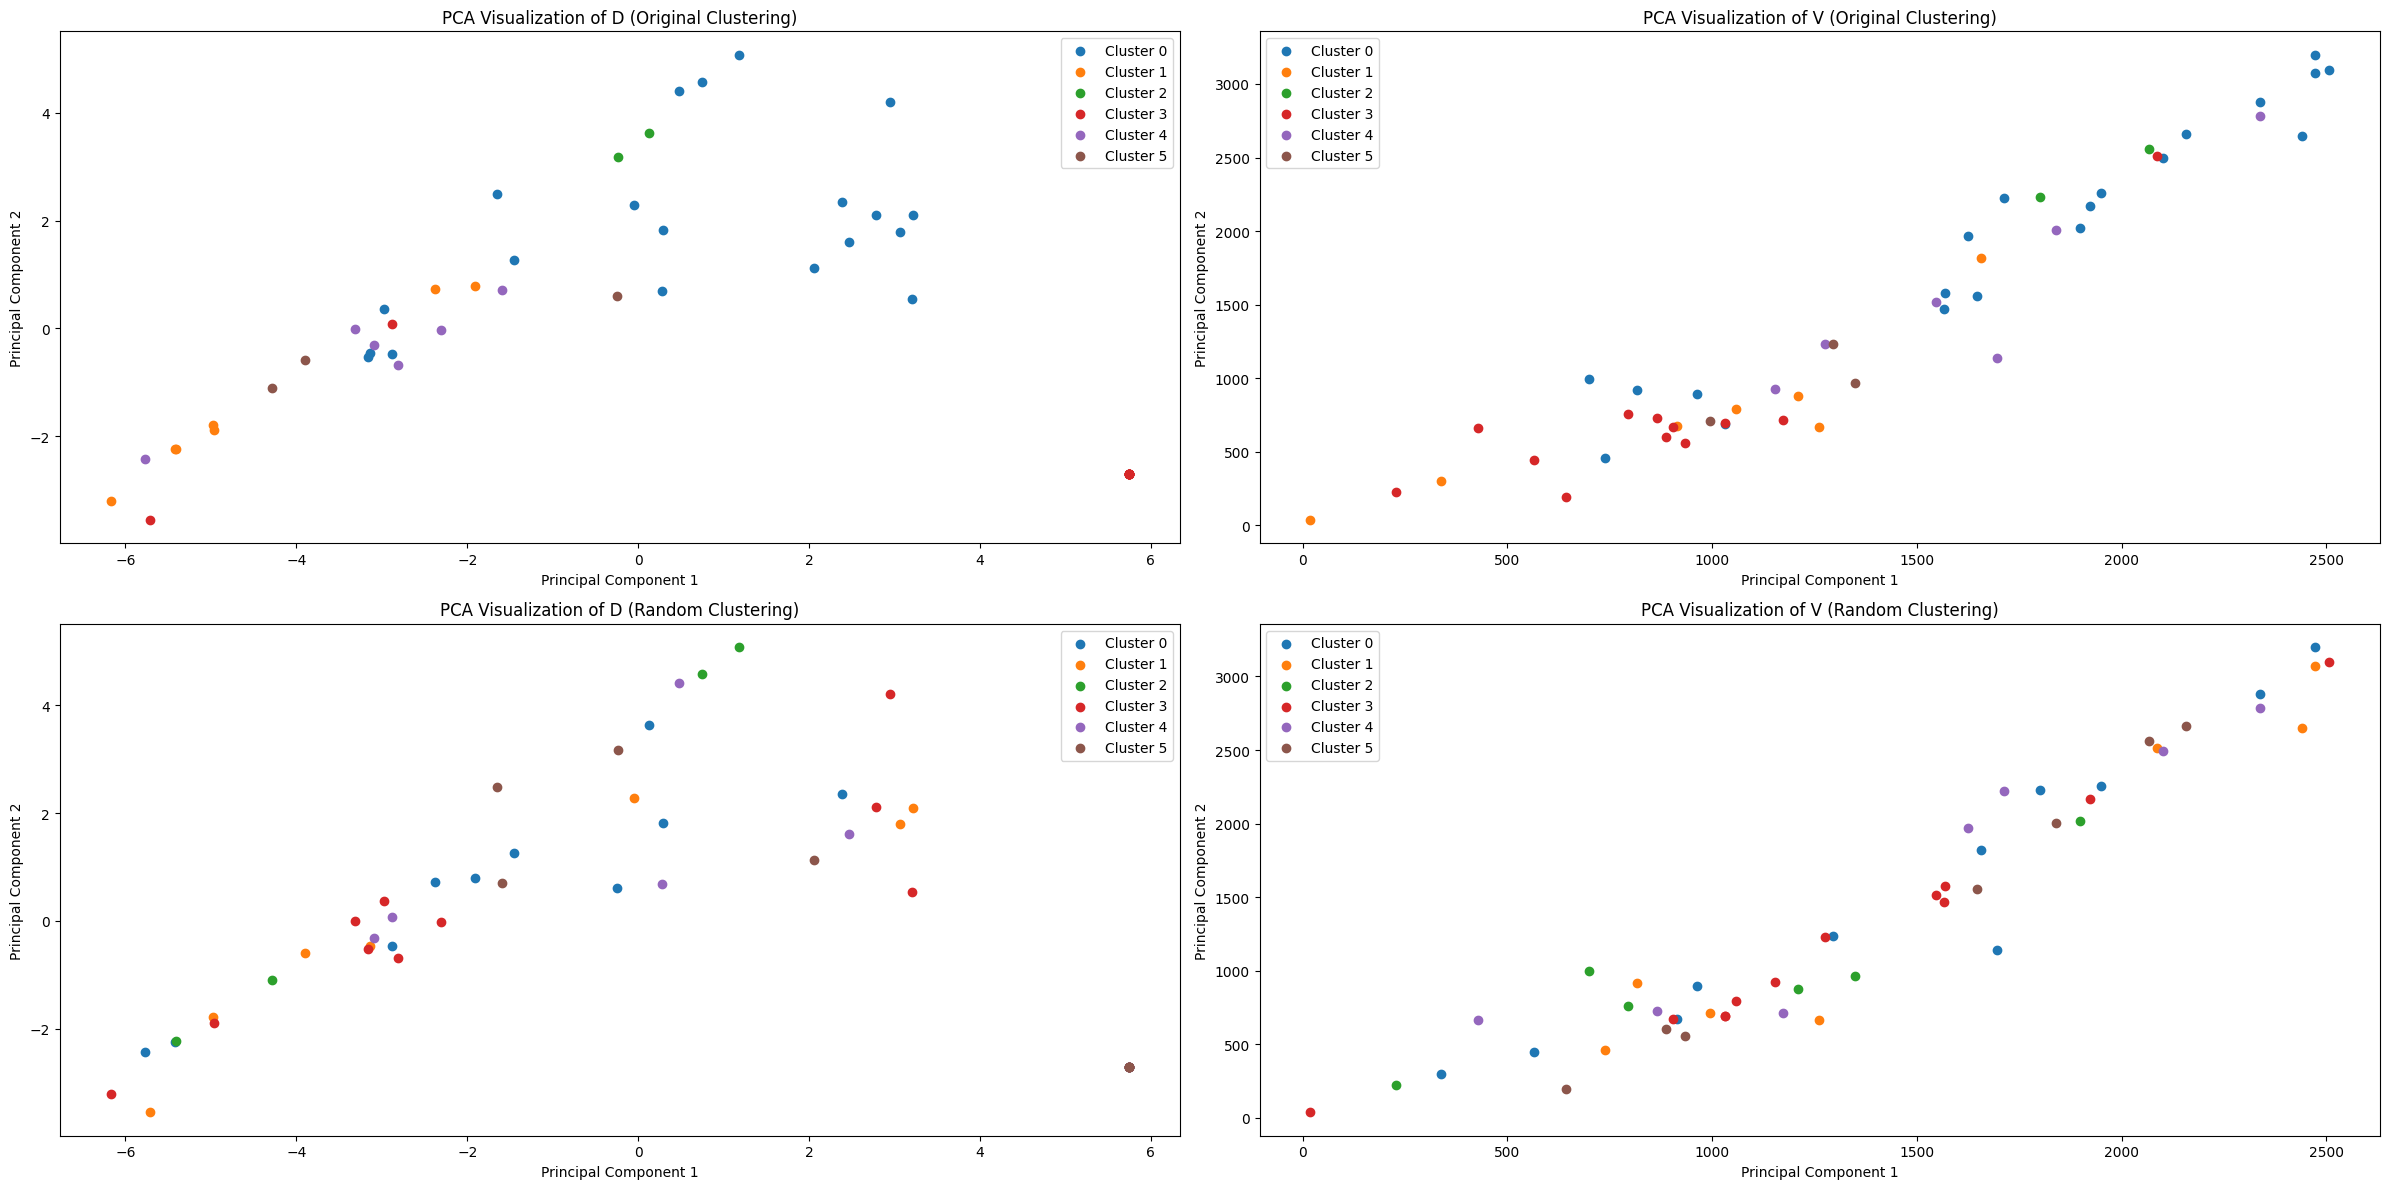

The silhouette score for D data (Original) is: 0.19511085690248017
The silhouette score for V data (Original) is: -0.13300329563359273
The silhouette score for D data (Random) is: -0.0986395720548821
The silhouette score for V data (Random) is: -0.08435137866798775


In [41]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 6, method='SpectralClustering')

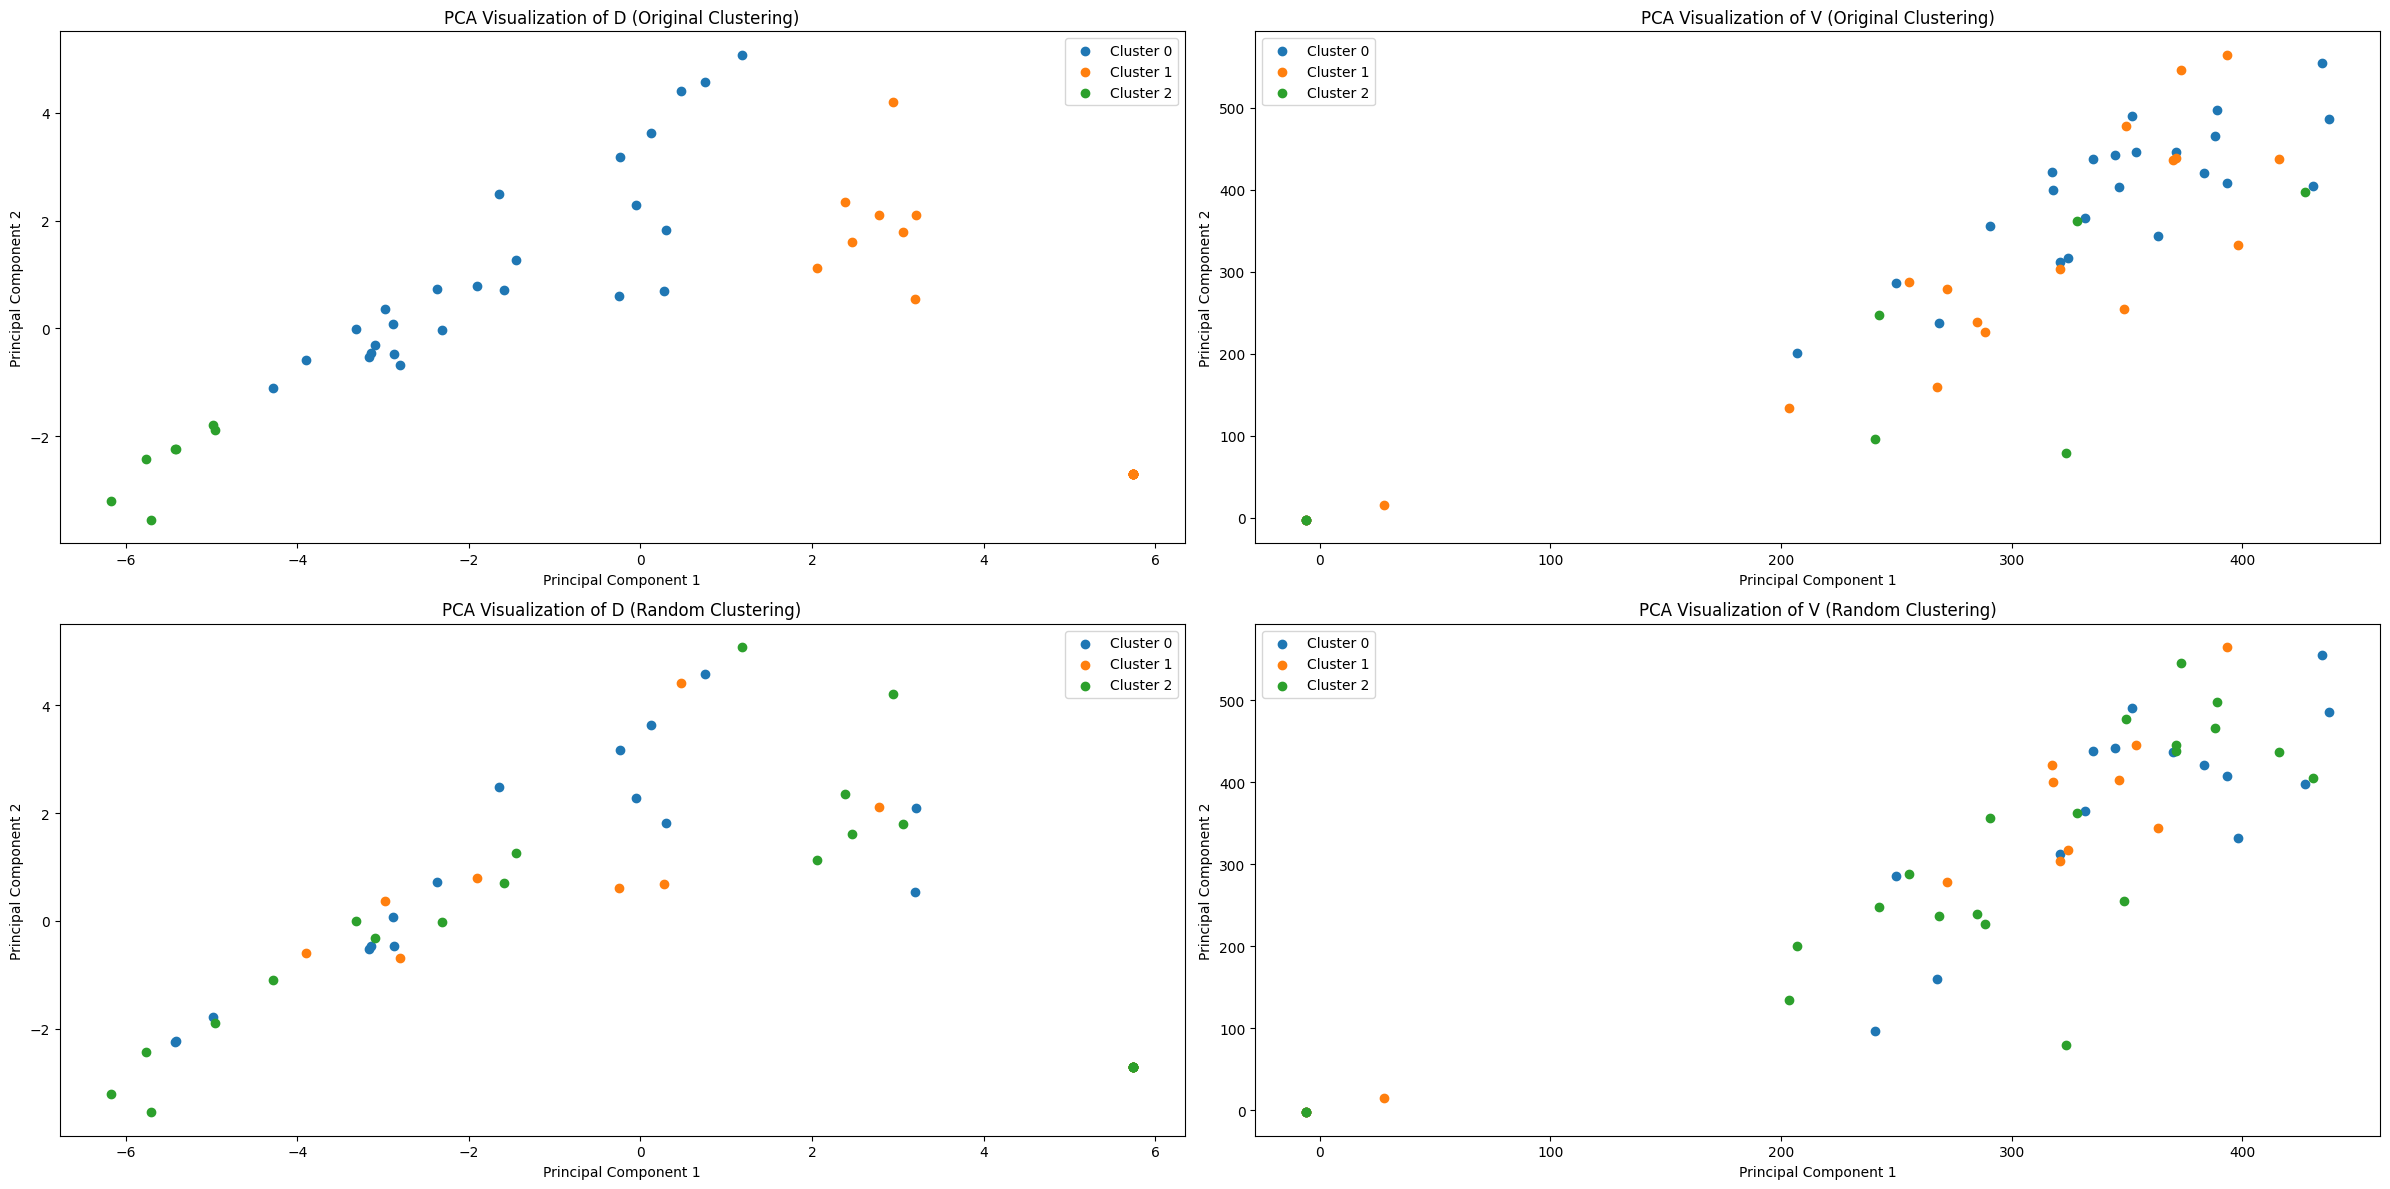

The silhouette score for D data (Original) is: 0.21094828288866002
The silhouette score for V data (Original) is: -0.023570583636715013
The silhouette score for D data (Random) is: -0.041002360975183574
The silhouette score for V data (Random) is: -0.03298945529522424


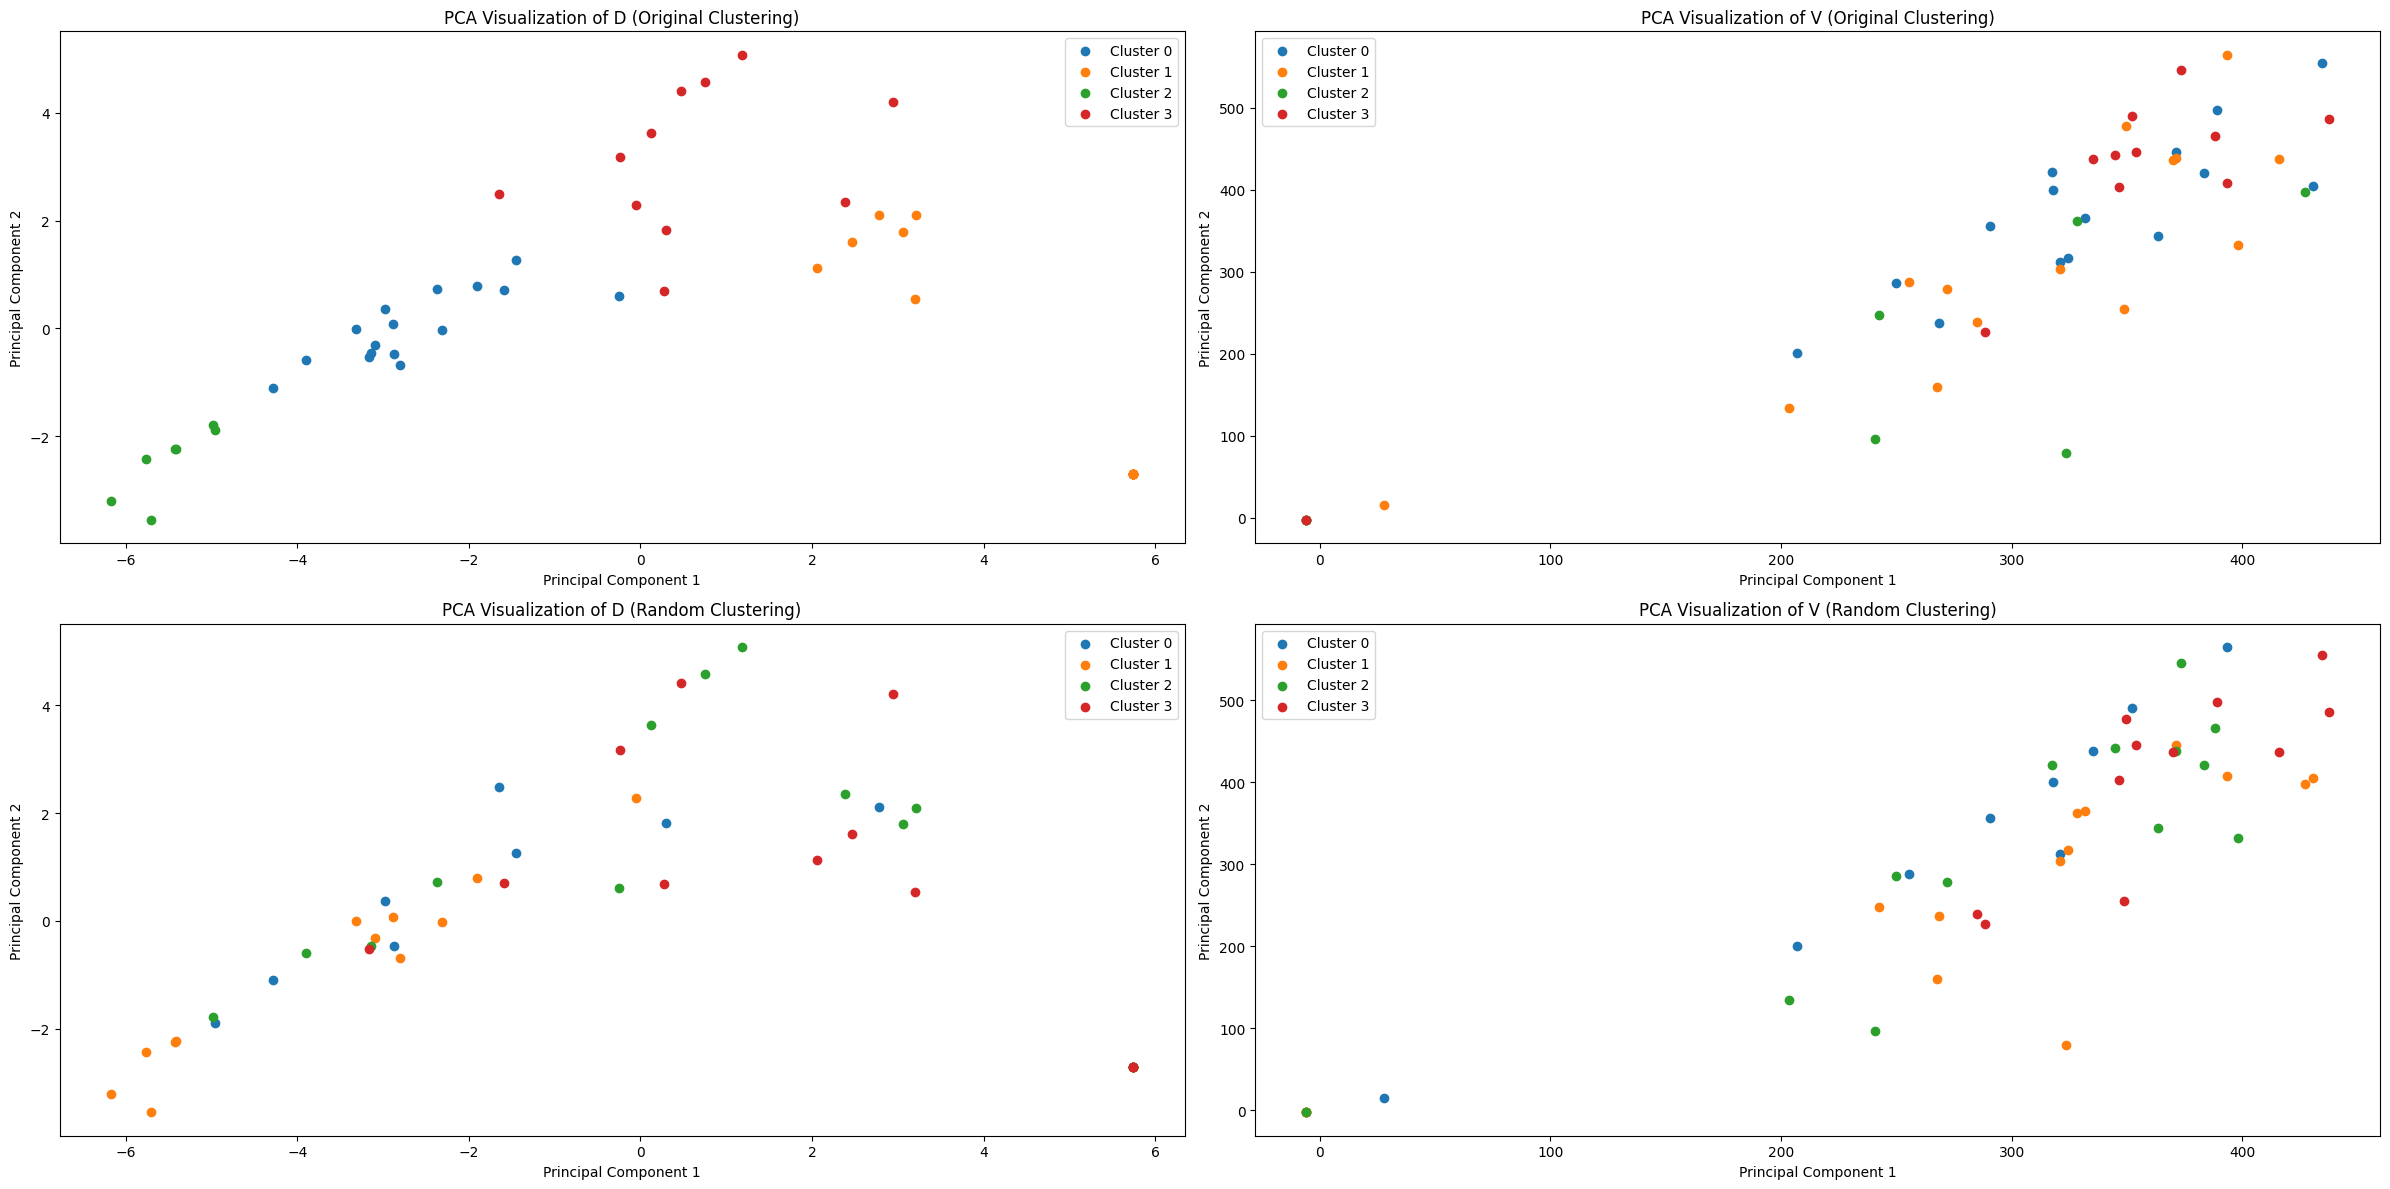

The silhouette score for D data (Original) is: 0.20535540597417973
The silhouette score for V data (Original) is: -0.045571566240683516
The silhouette score for D data (Random) is: -0.06063429517626291
The silhouette score for V data (Random) is: -0.035973010709919144


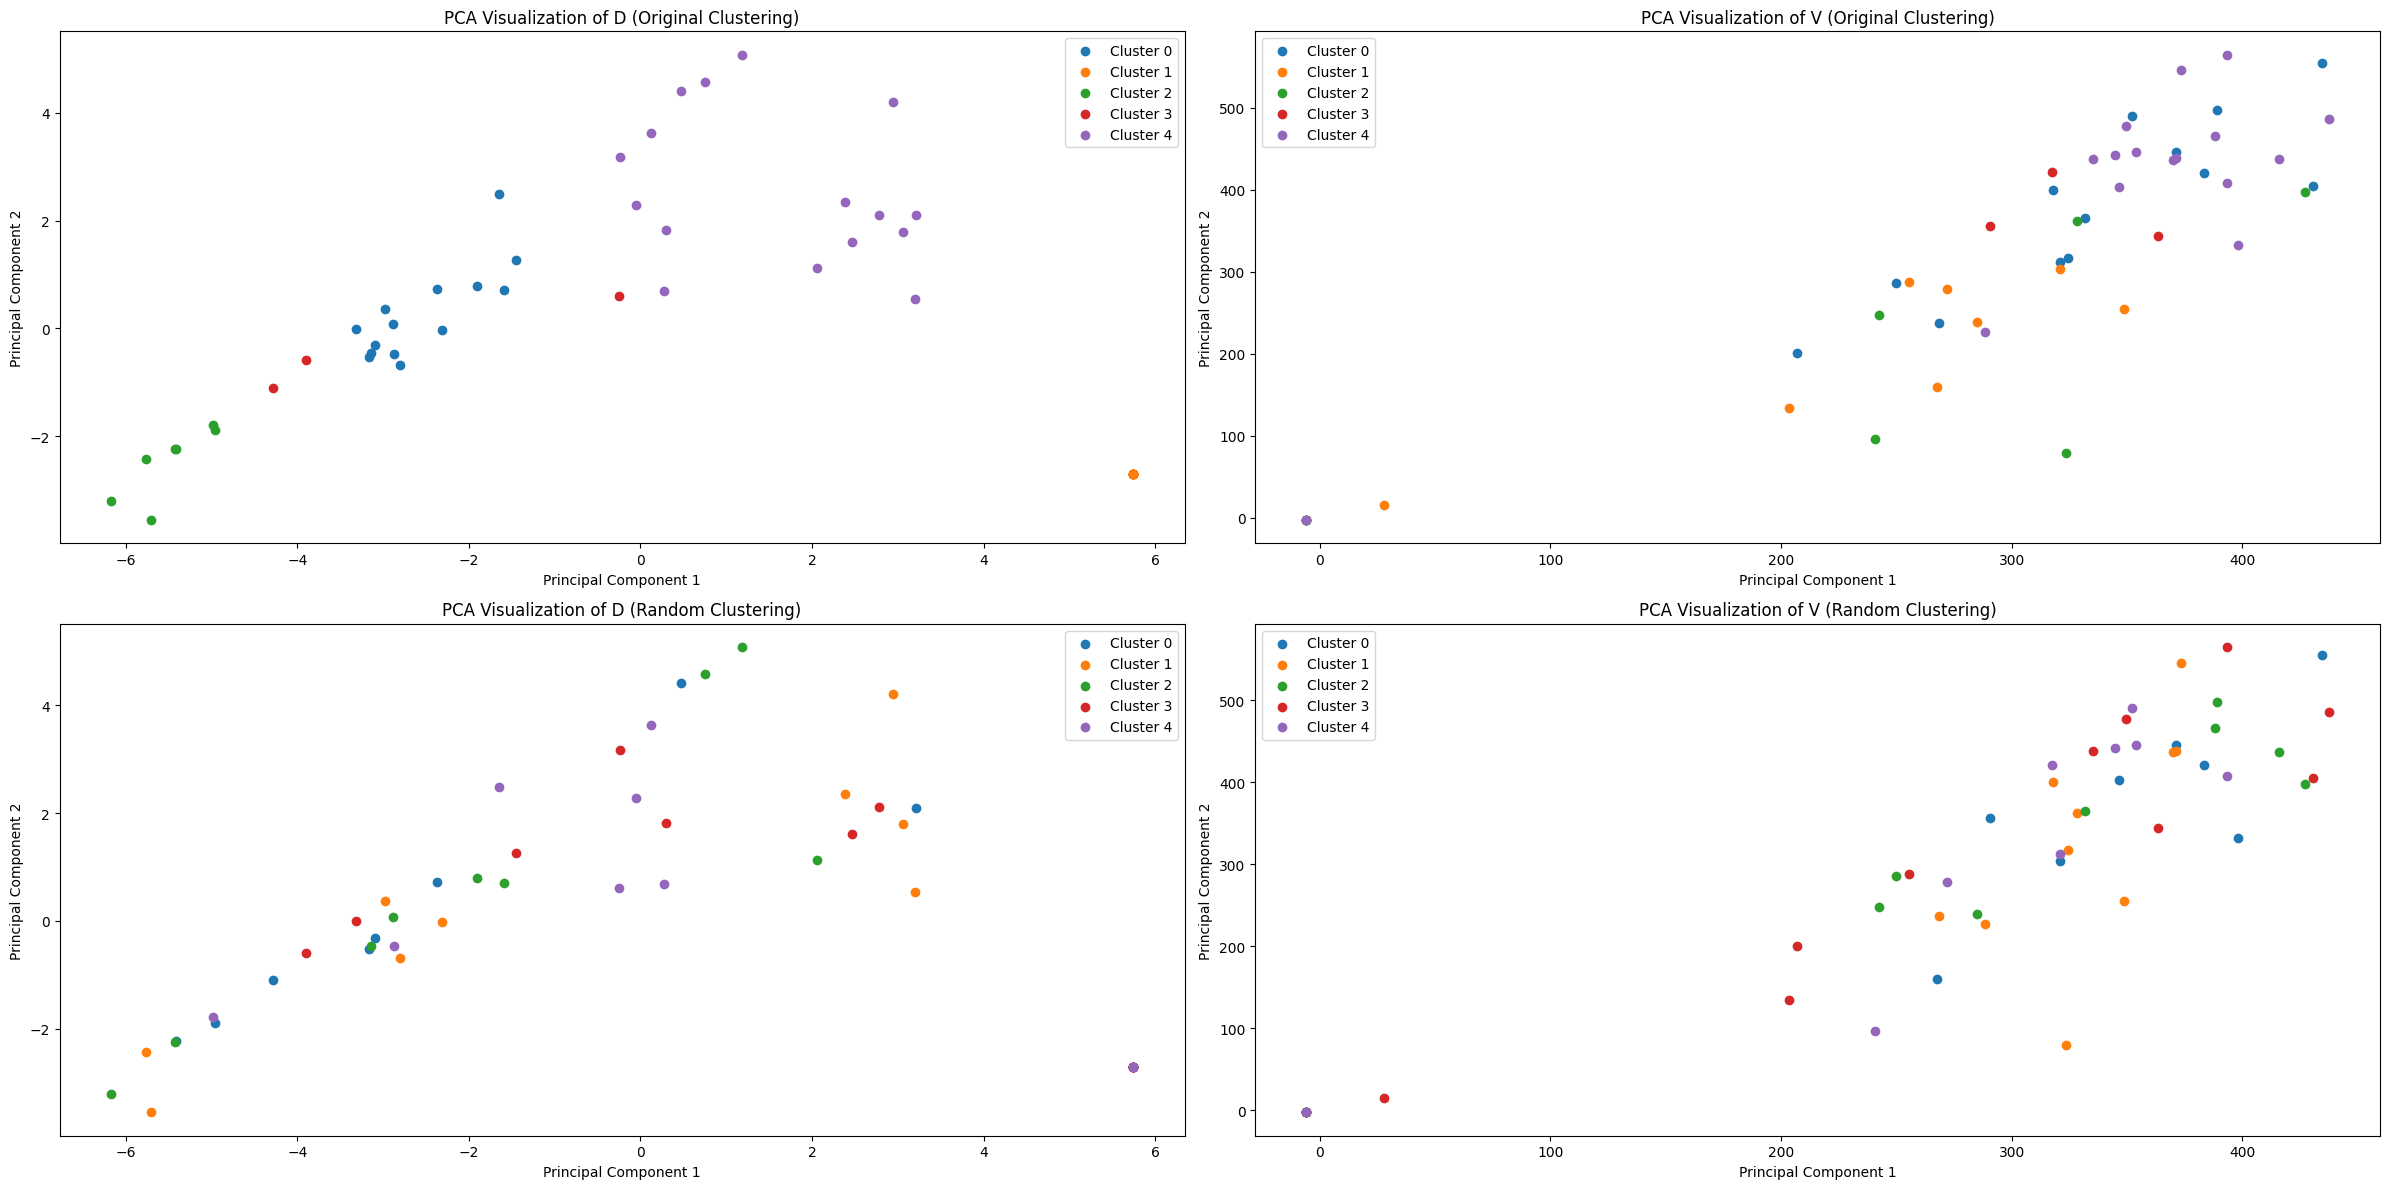

The silhouette score for D data (Original) is: 0.28333725746742755
The silhouette score for V data (Original) is: -0.09212067021647727
The silhouette score for D data (Random) is: -0.0656476934975946
The silhouette score for V data (Random) is: -0.06467811306438823


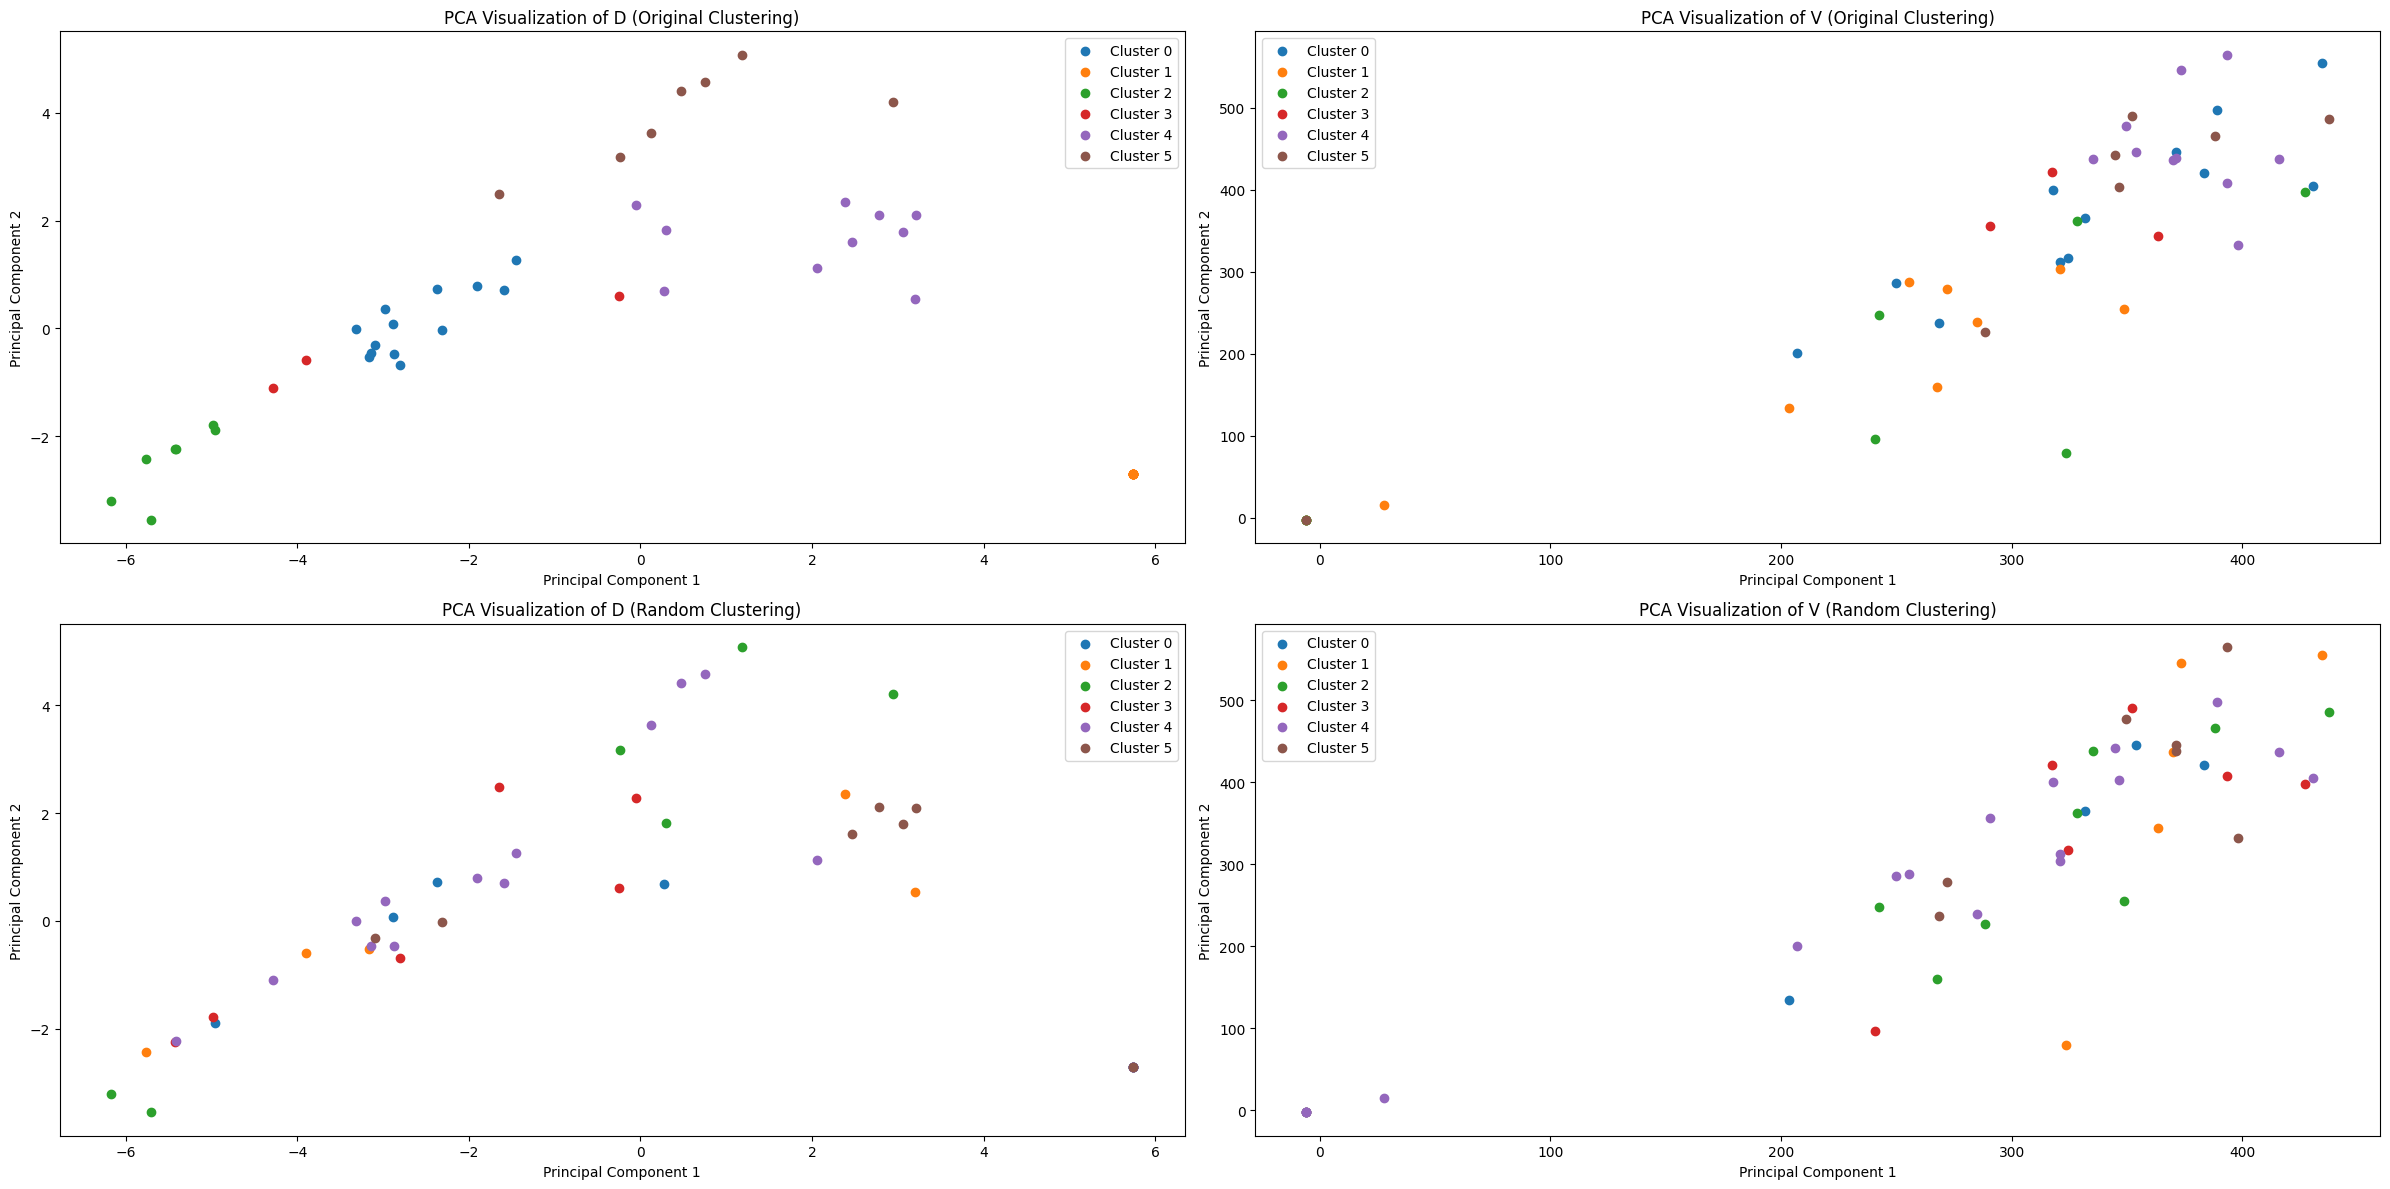

The silhouette score for D data (Original) is: 0.29892921037985626
The silhouette score for V data (Original) is: -0.09825592931565341
The silhouette score for D data (Random) is: -0.0803404779065485
The silhouette score for V data (Random) is: -0.08559956372374096


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


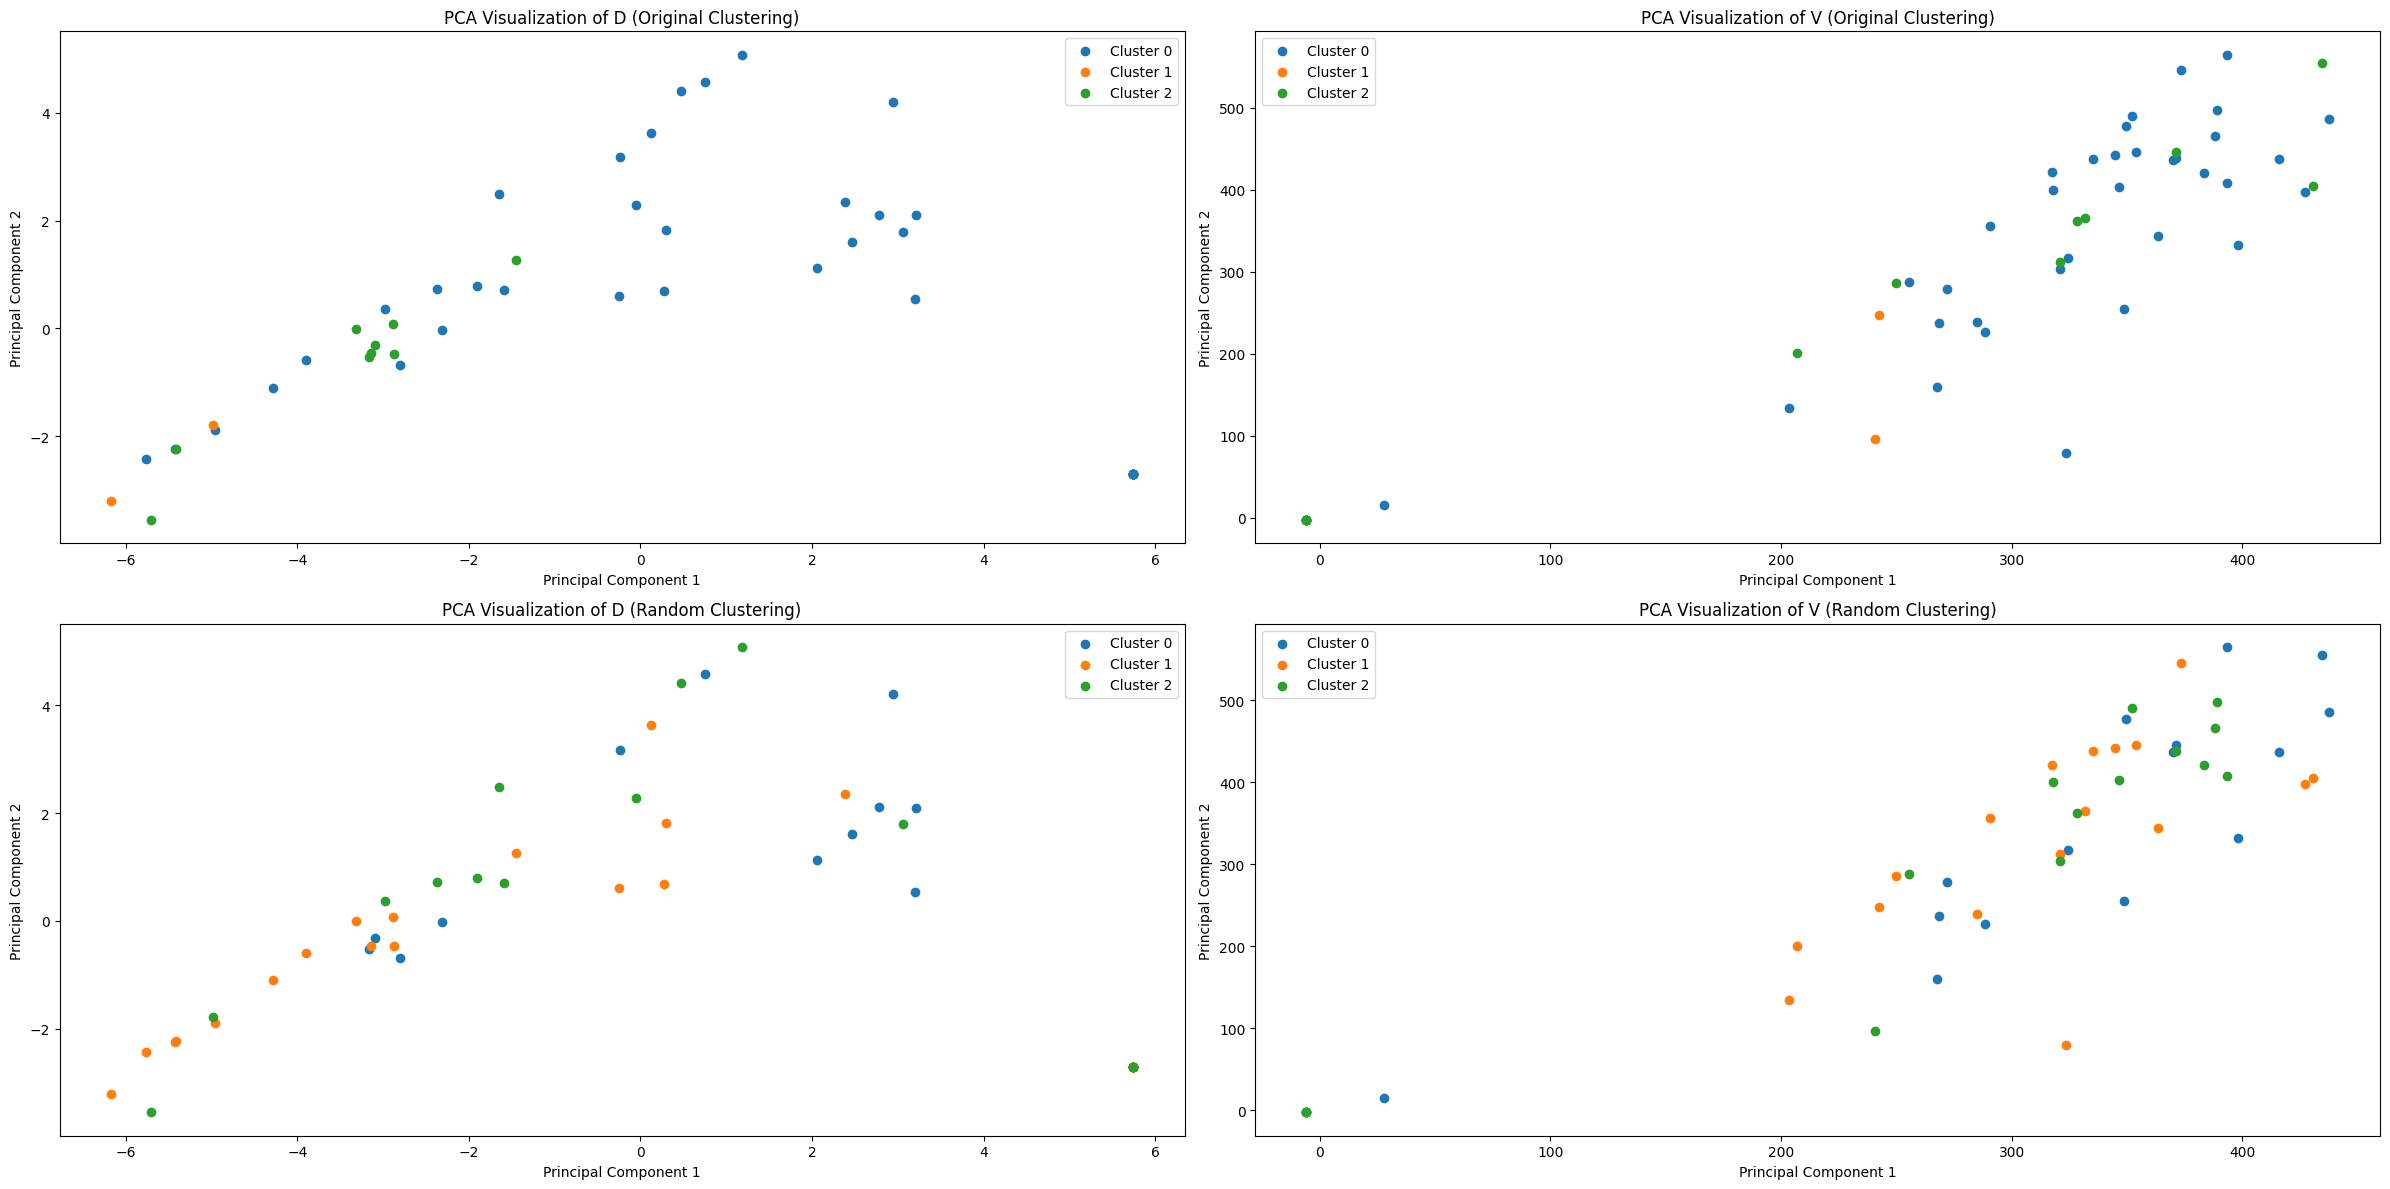

The silhouette score for D data (Original) is: 0.13173443250188635
The silhouette score for V data (Original) is: -0.08004182327153549
The silhouette score for D data (Random) is: -0.025971534497488093
The silhouette score for V data (Random) is: -0.023704620594804906


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


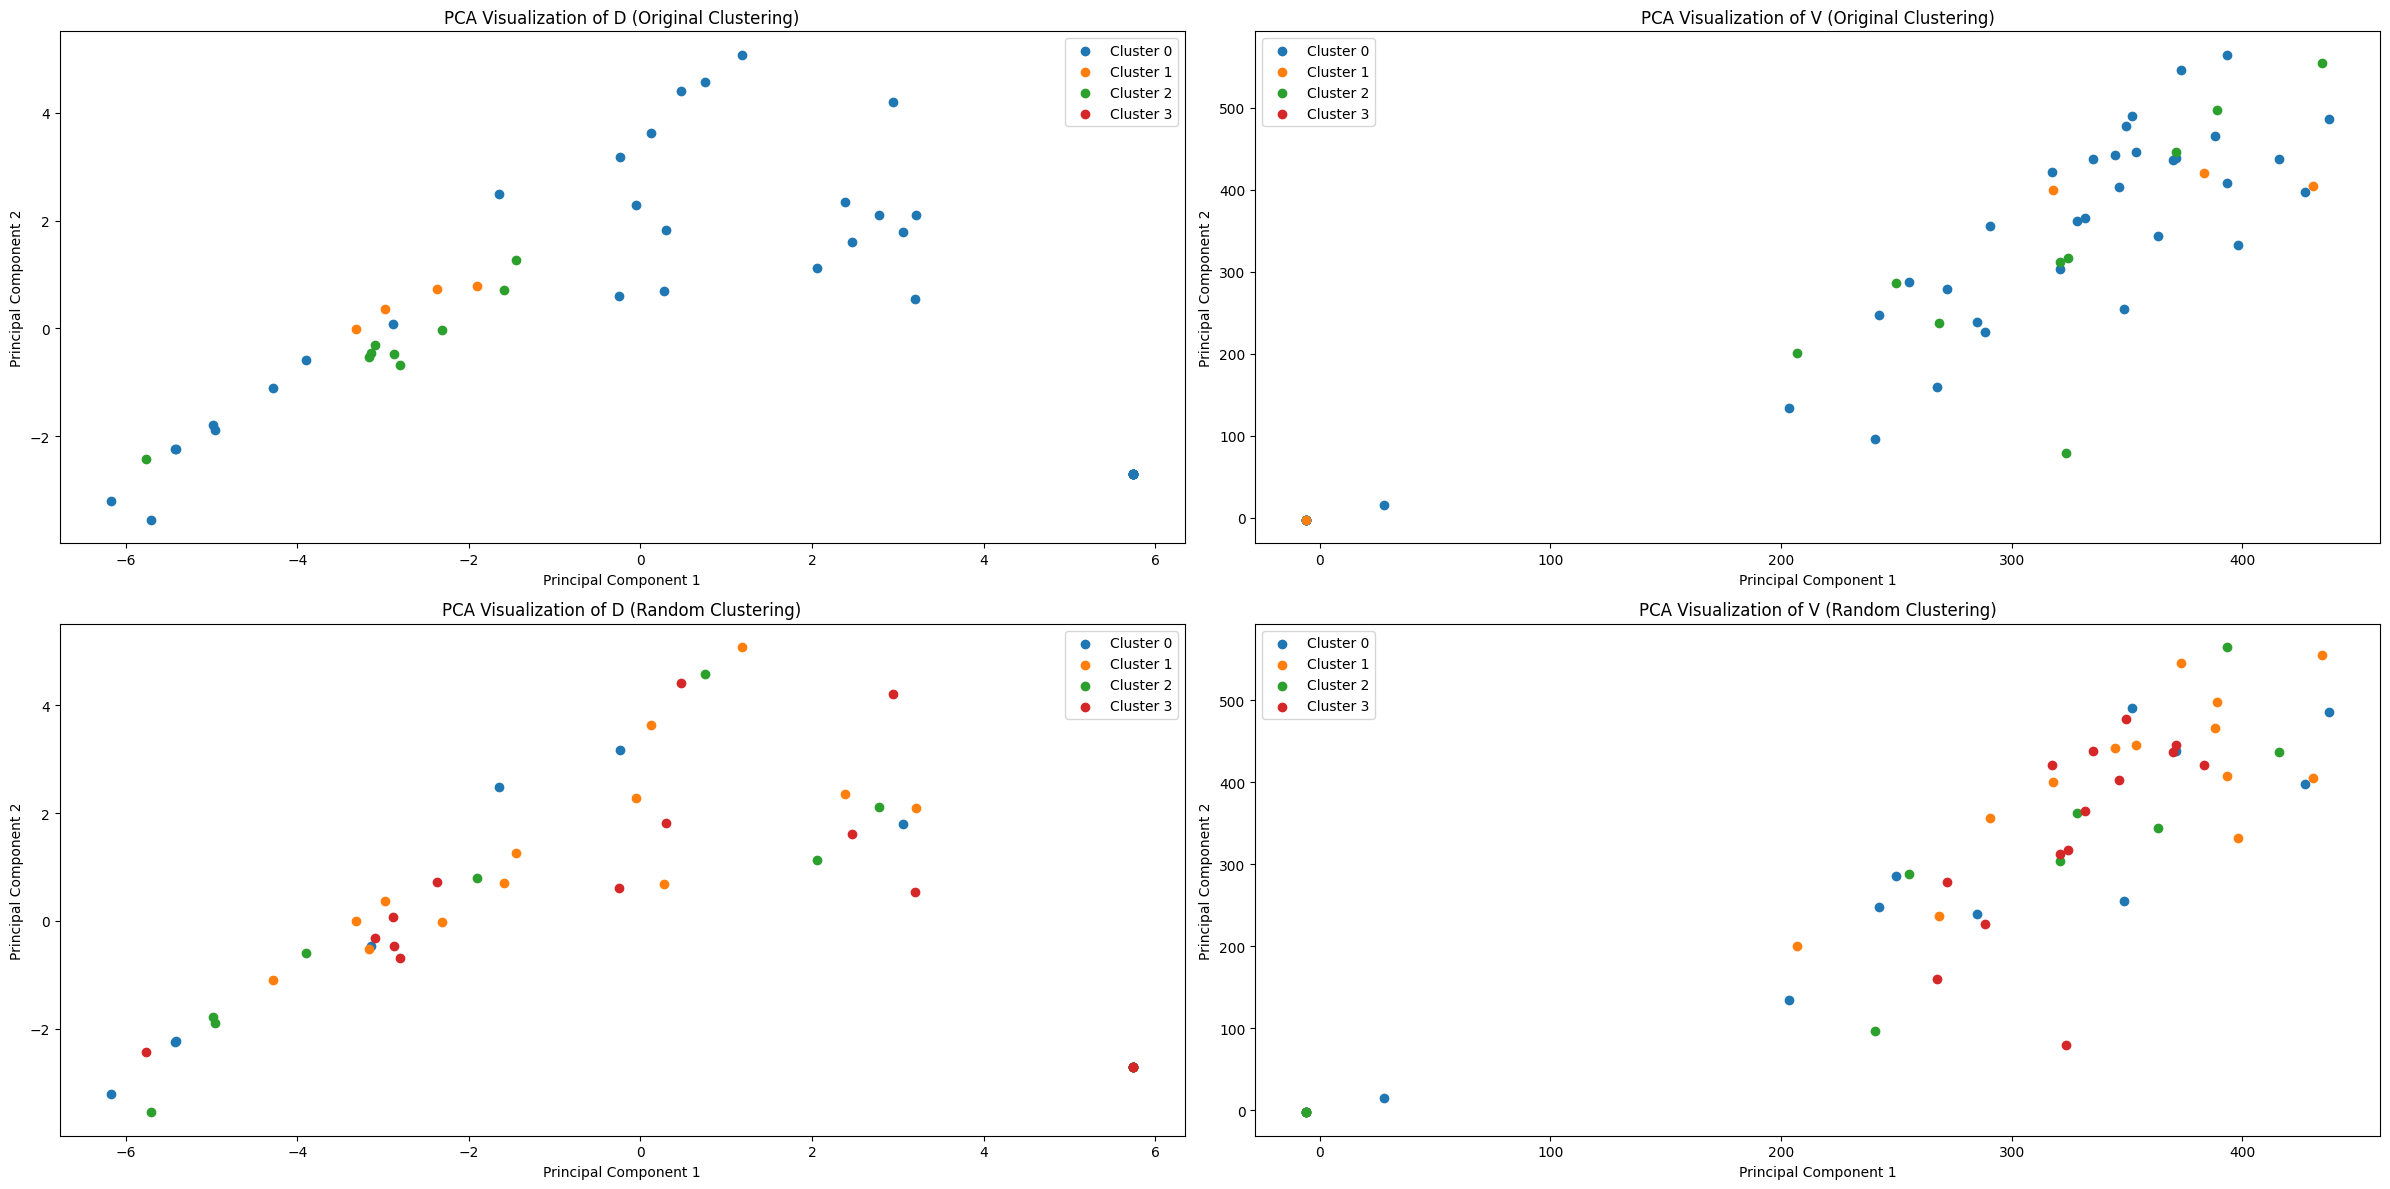

The silhouette score for D data (Original) is: 0.09731321796451654
The silhouette score for V data (Original) is: -0.033490140313657435
The silhouette score for D data (Random) is: -0.046450886151638254
The silhouette score for V data (Random) is: -0.05030740624462639


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


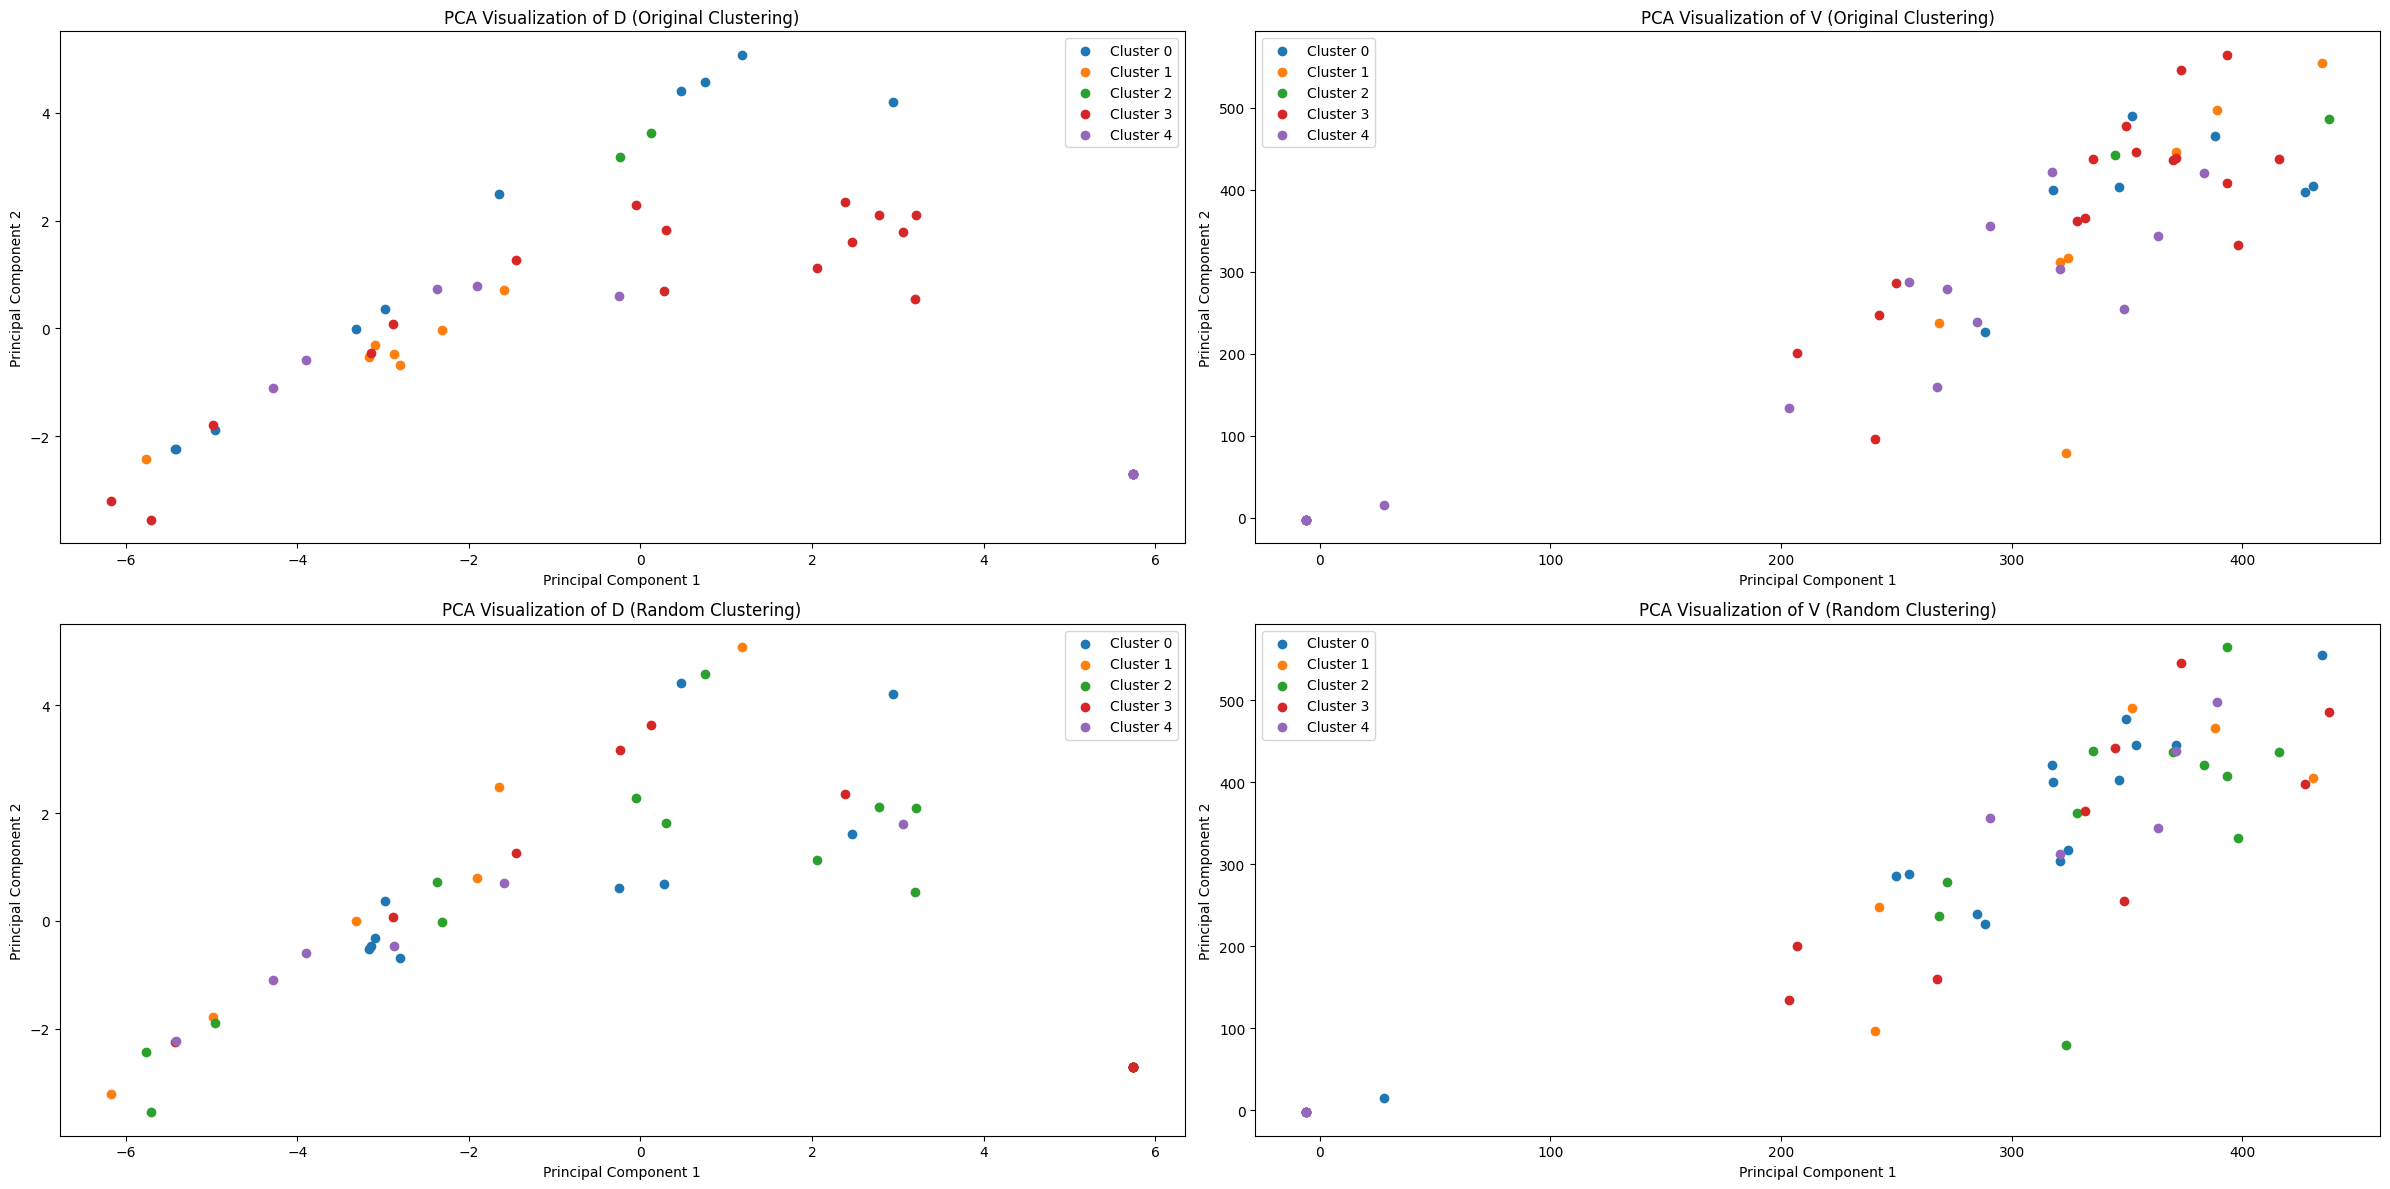

The silhouette score for D data (Original) is: 0.1135878105124042
The silhouette score for V data (Original) is: -0.07699958304100443
The silhouette score for D data (Random) is: -0.05717043881972224
The silhouette score for V data (Random) is: -0.06029878272587411


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


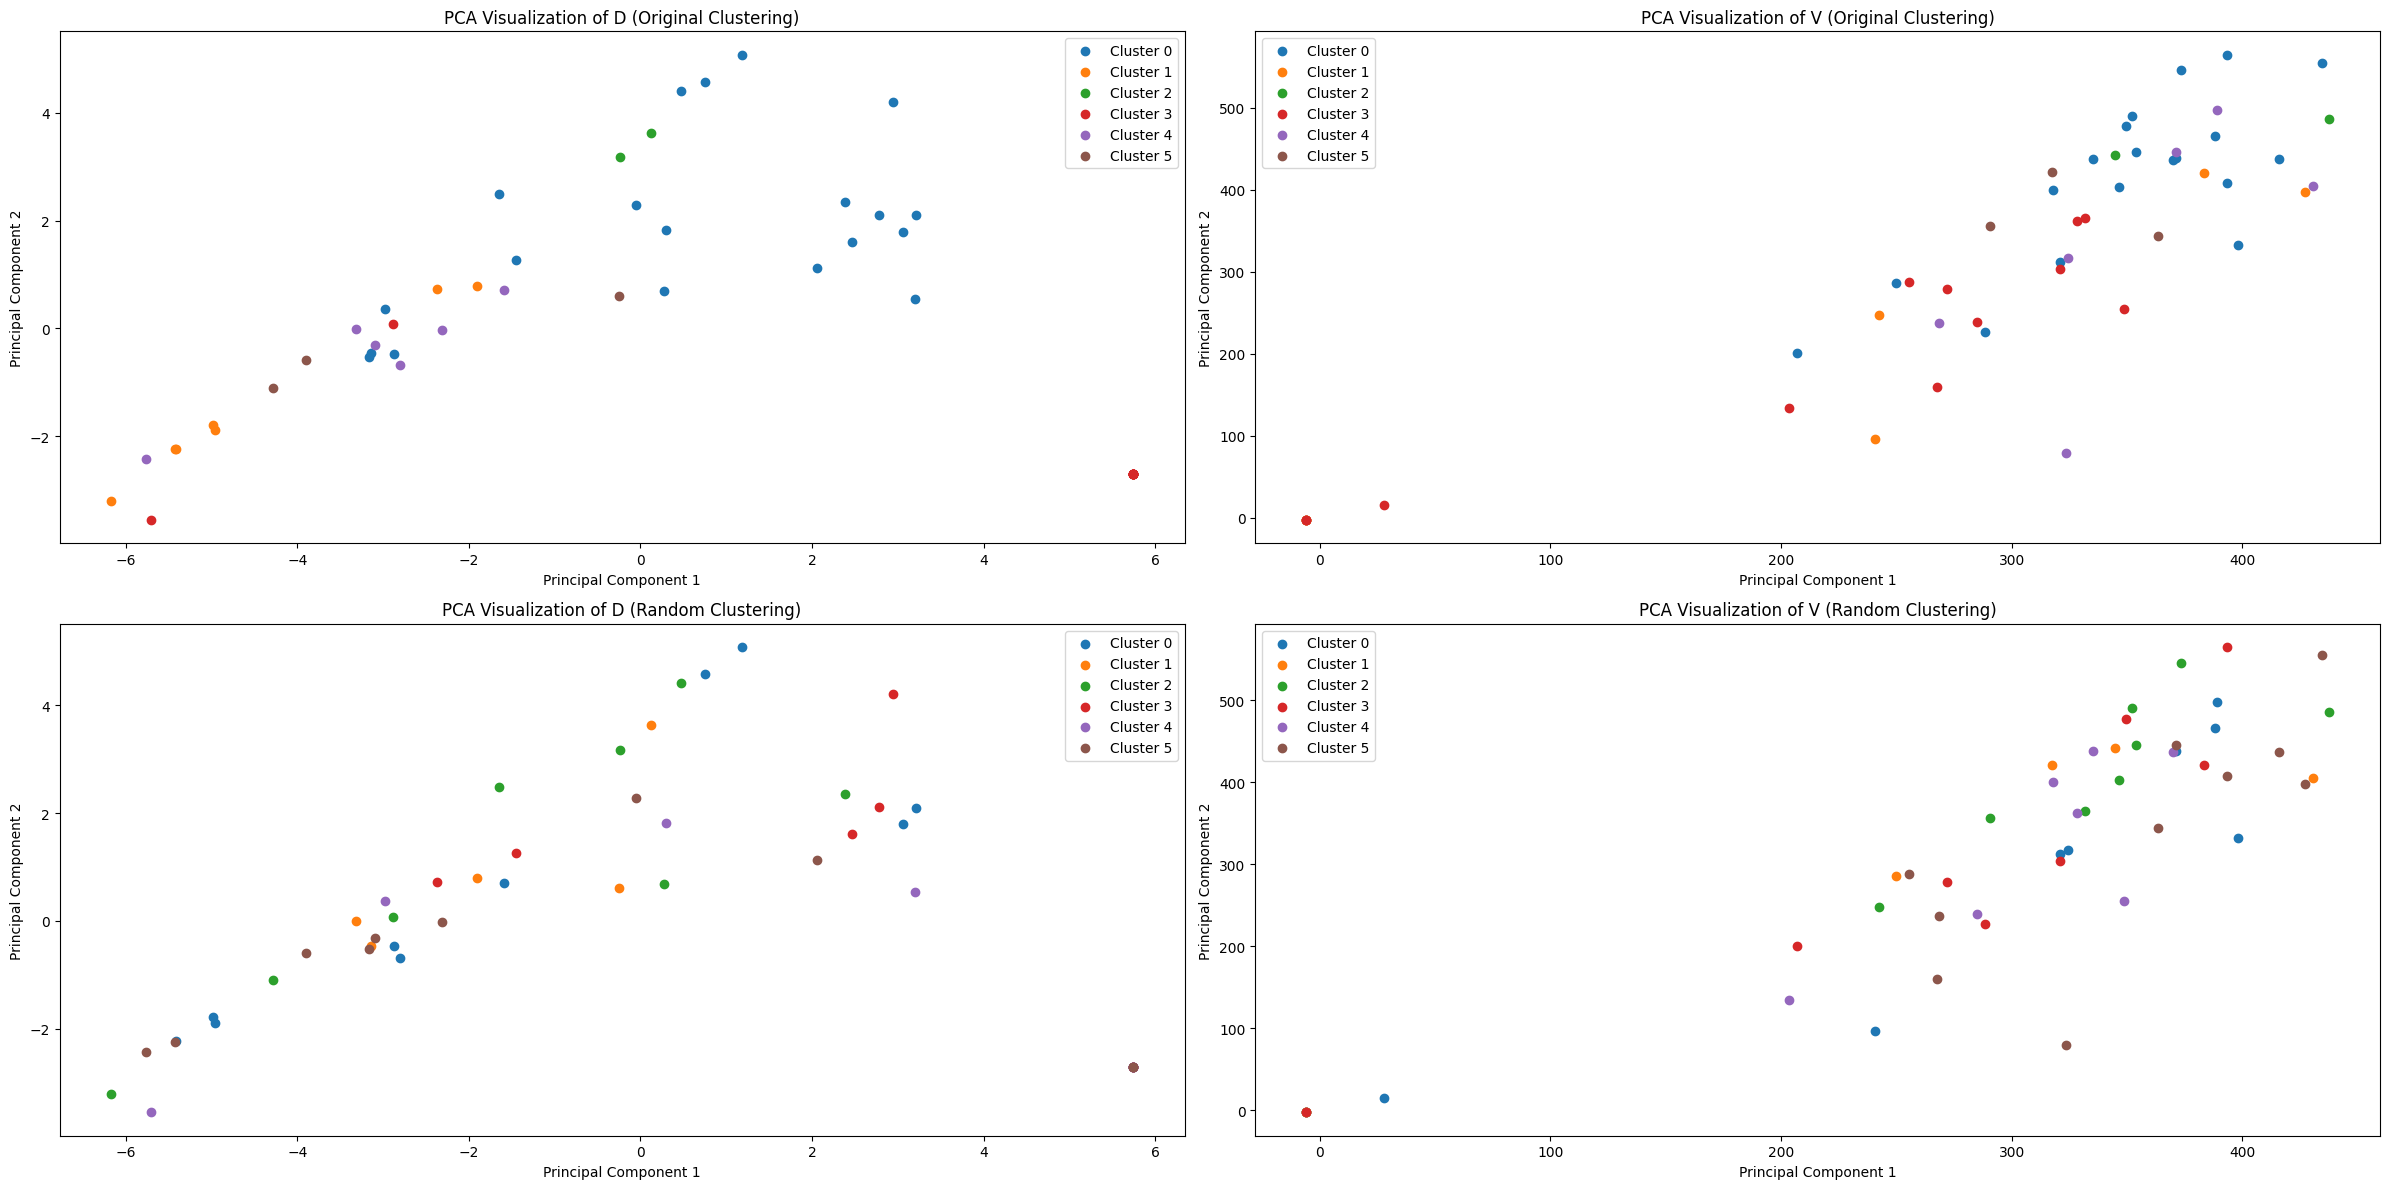

The silhouette score for D data (Original) is: 0.19511085690248017
The silhouette score for V data (Original) is: -0.10078760906249709
The silhouette score for D data (Random) is: -0.10241877633750818
The silhouette score for V data (Random) is: -0.09361974212731518


In [42]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 6, method='SpectralClustering')

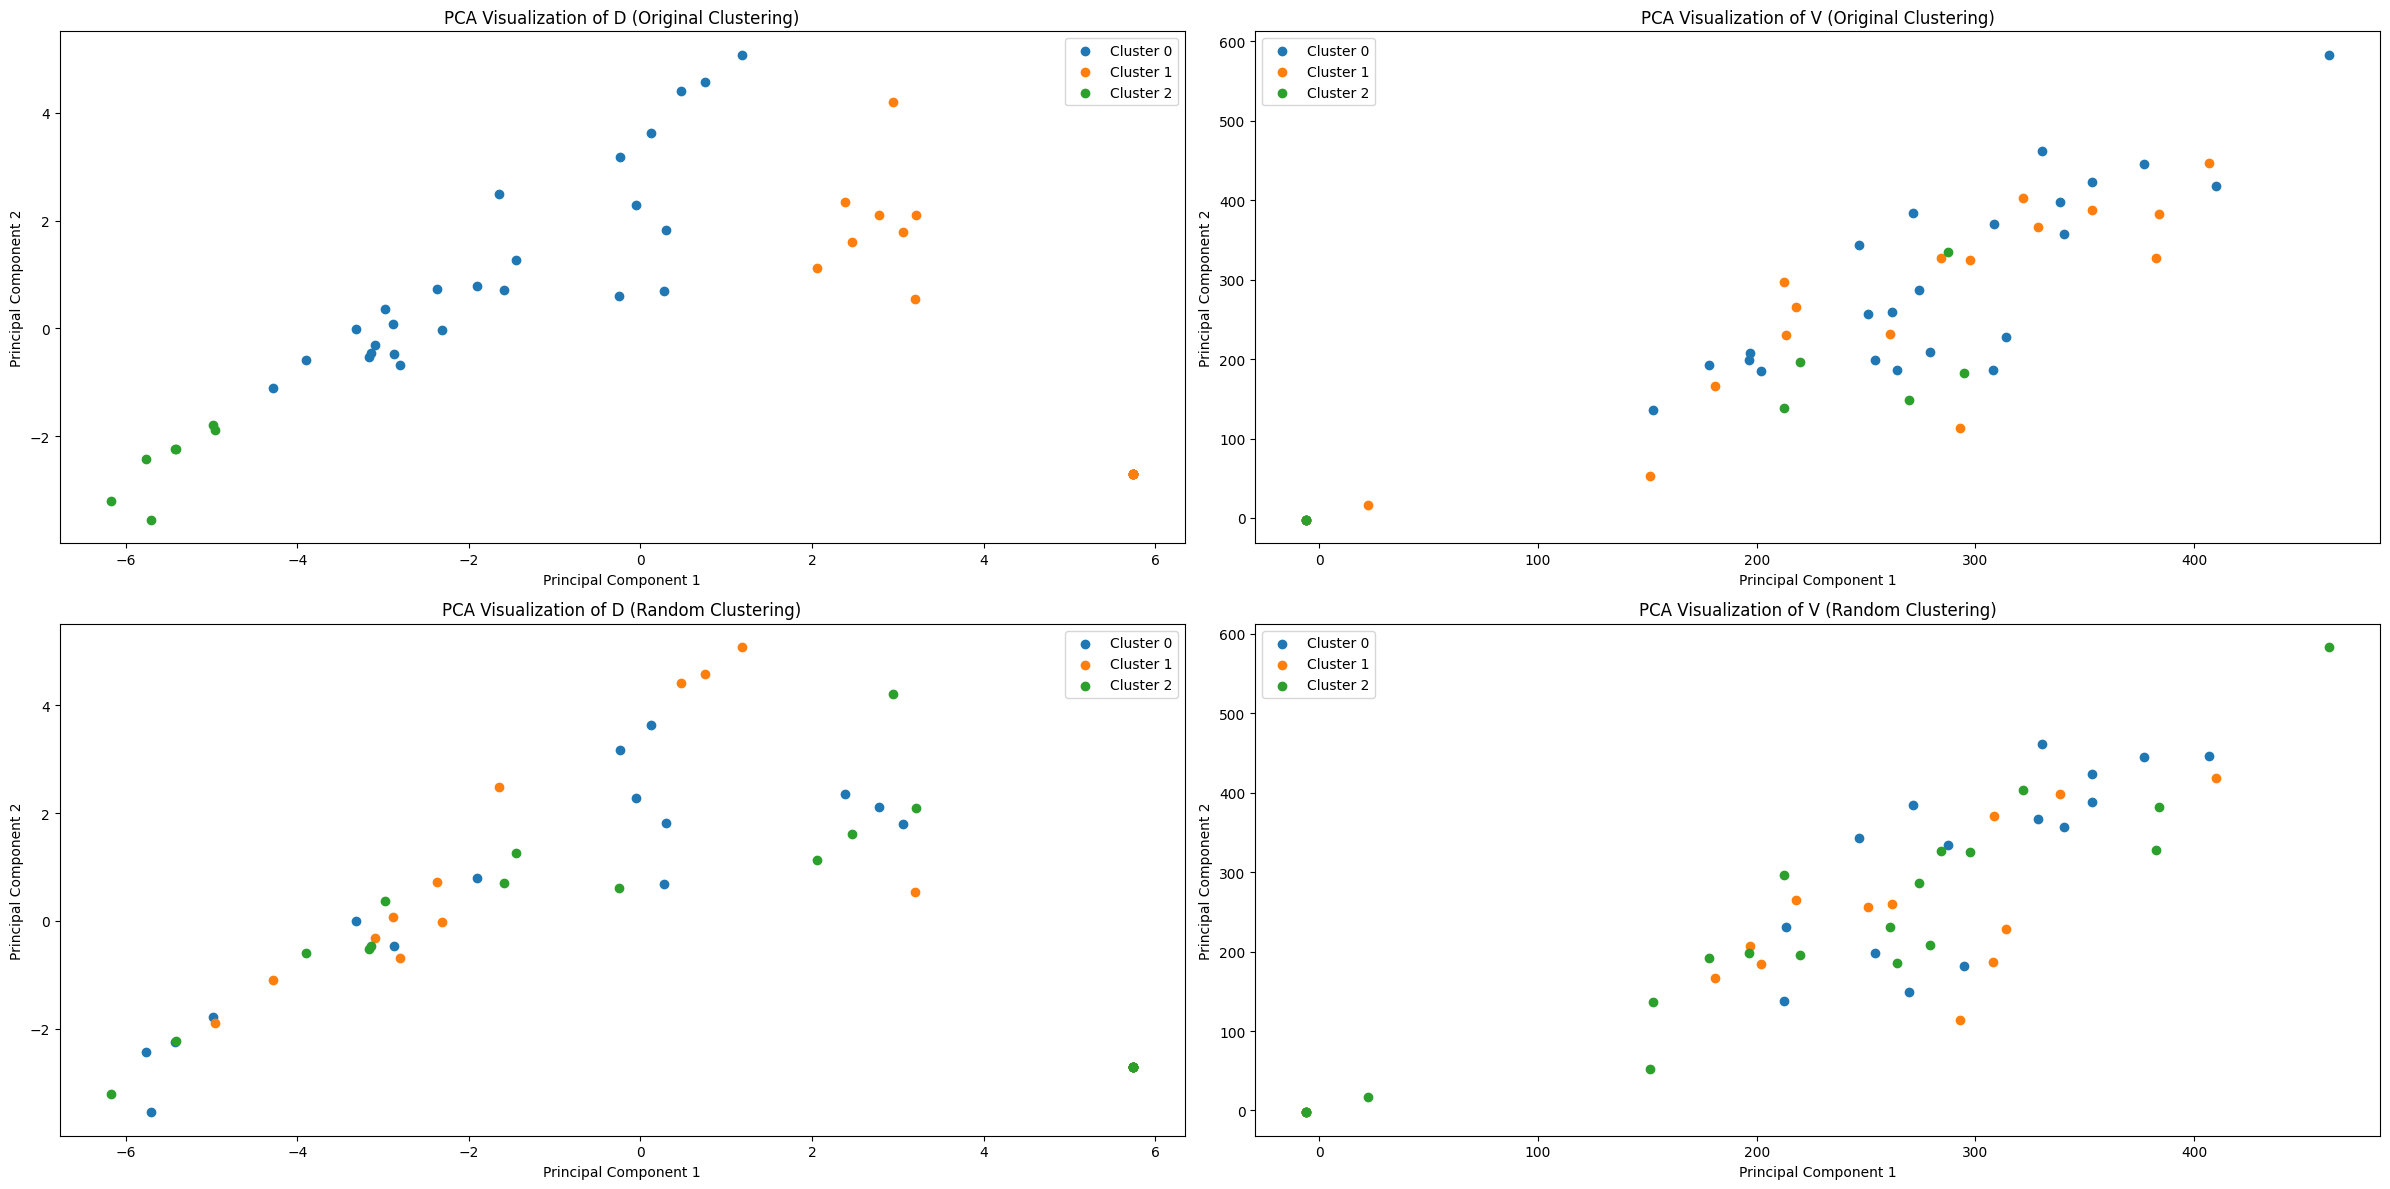

The silhouette score for D data (Original) is: 0.21094828288866002
The silhouette score for V data (Original) is: -0.02668577898967687
The silhouette score for D data (Random) is: -0.019773328588222675
The silhouette score for V data (Random) is: -0.030816850343439523


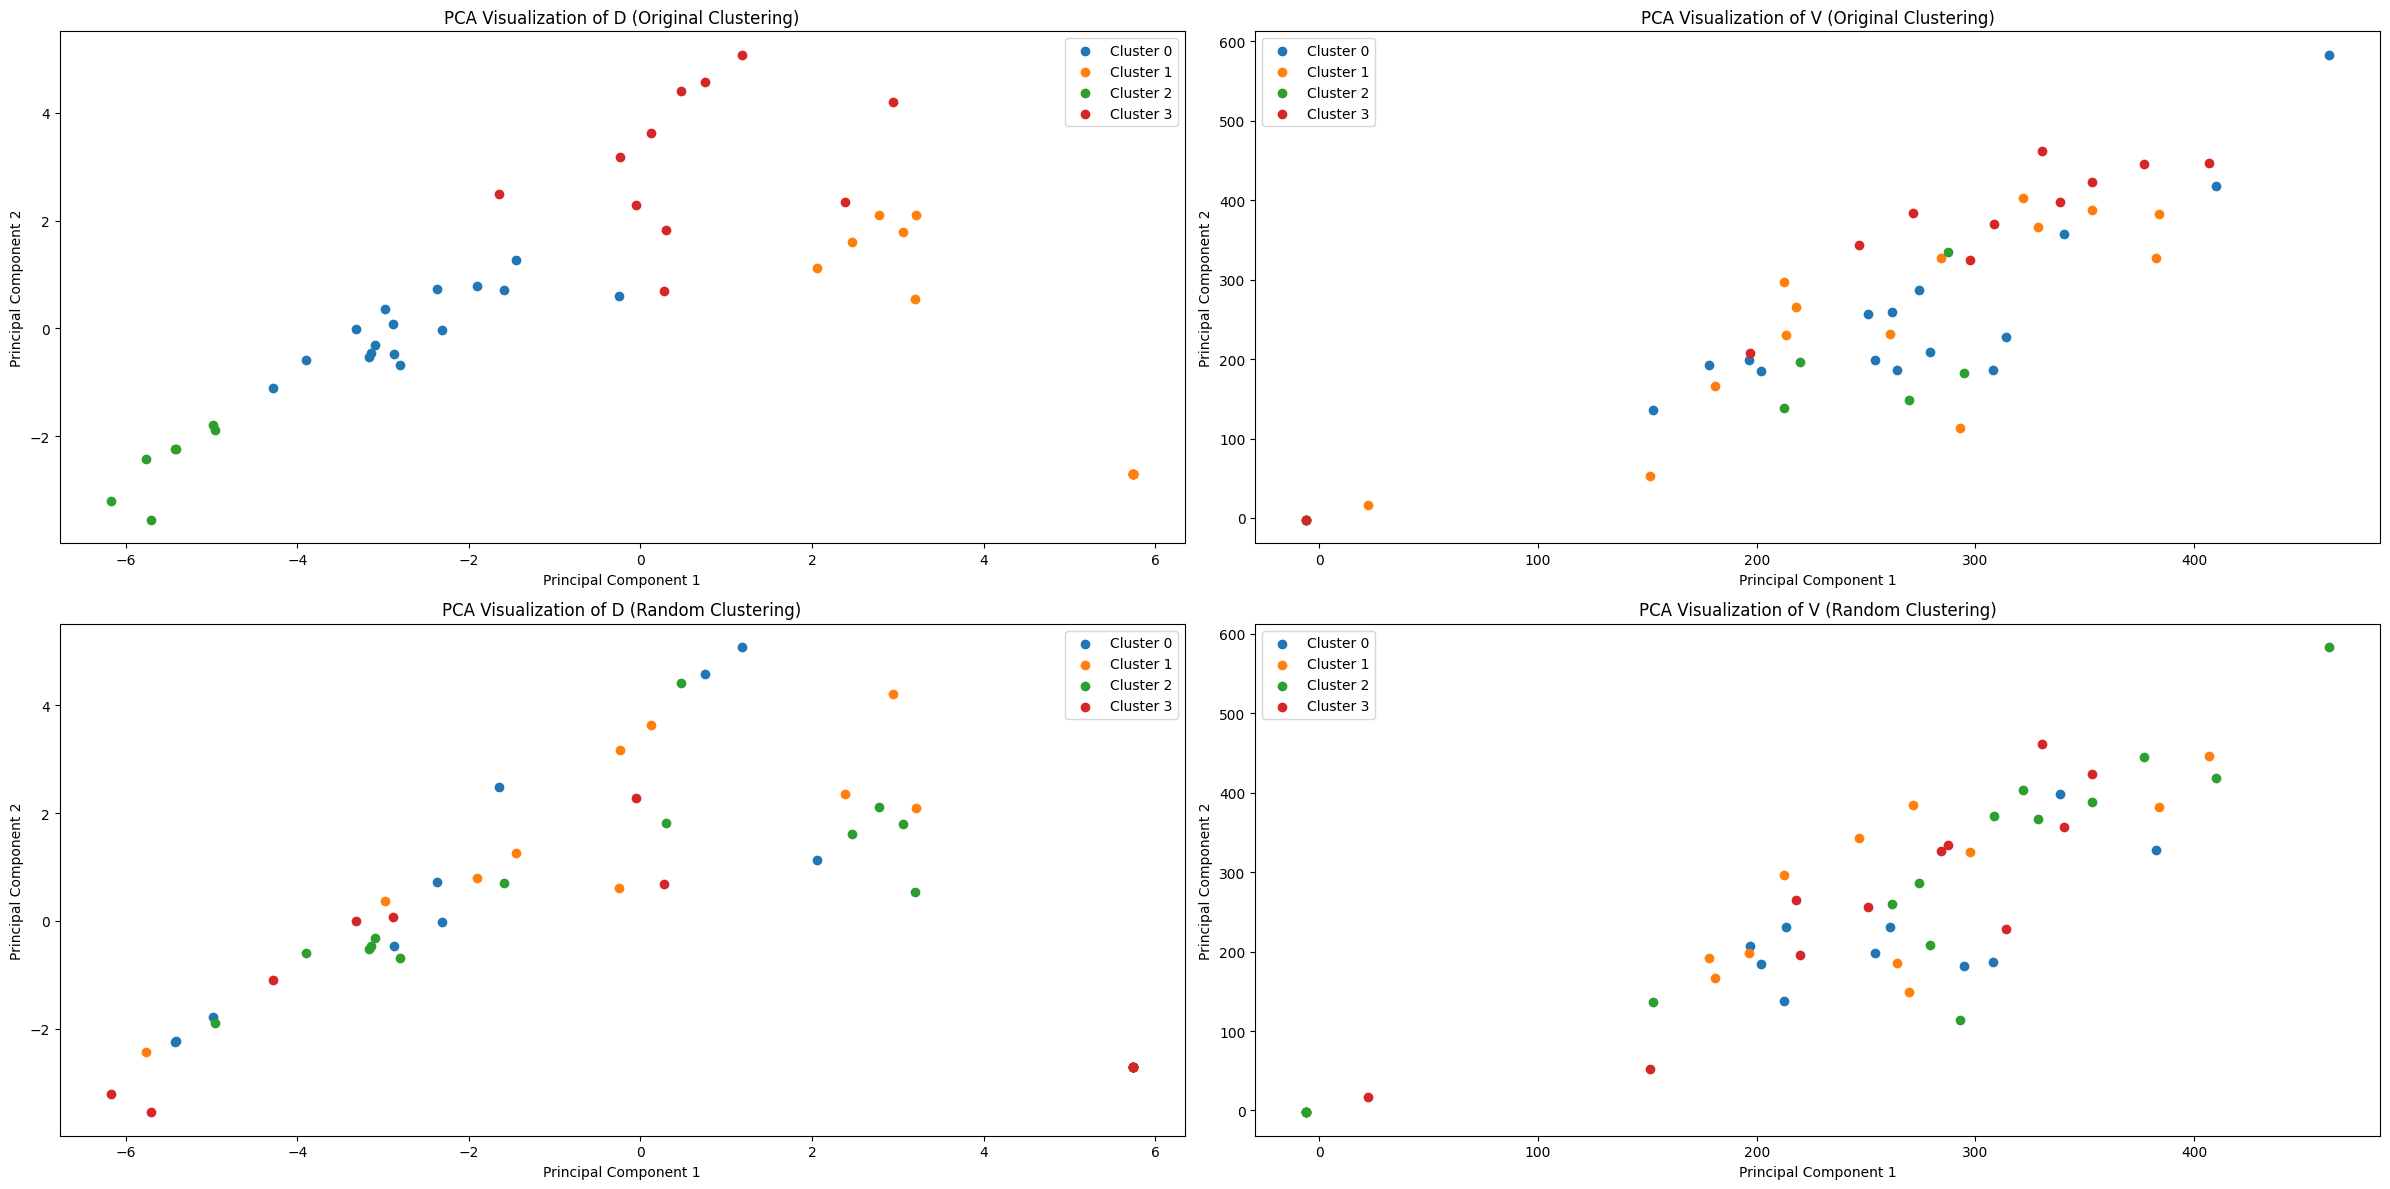

The silhouette score for D data (Original) is: 0.20535540597417973
The silhouette score for V data (Original) is: -0.040537700044102634
The silhouette score for D data (Random) is: -0.048363609326763965
The silhouette score for V data (Random) is: -0.044366155105620475


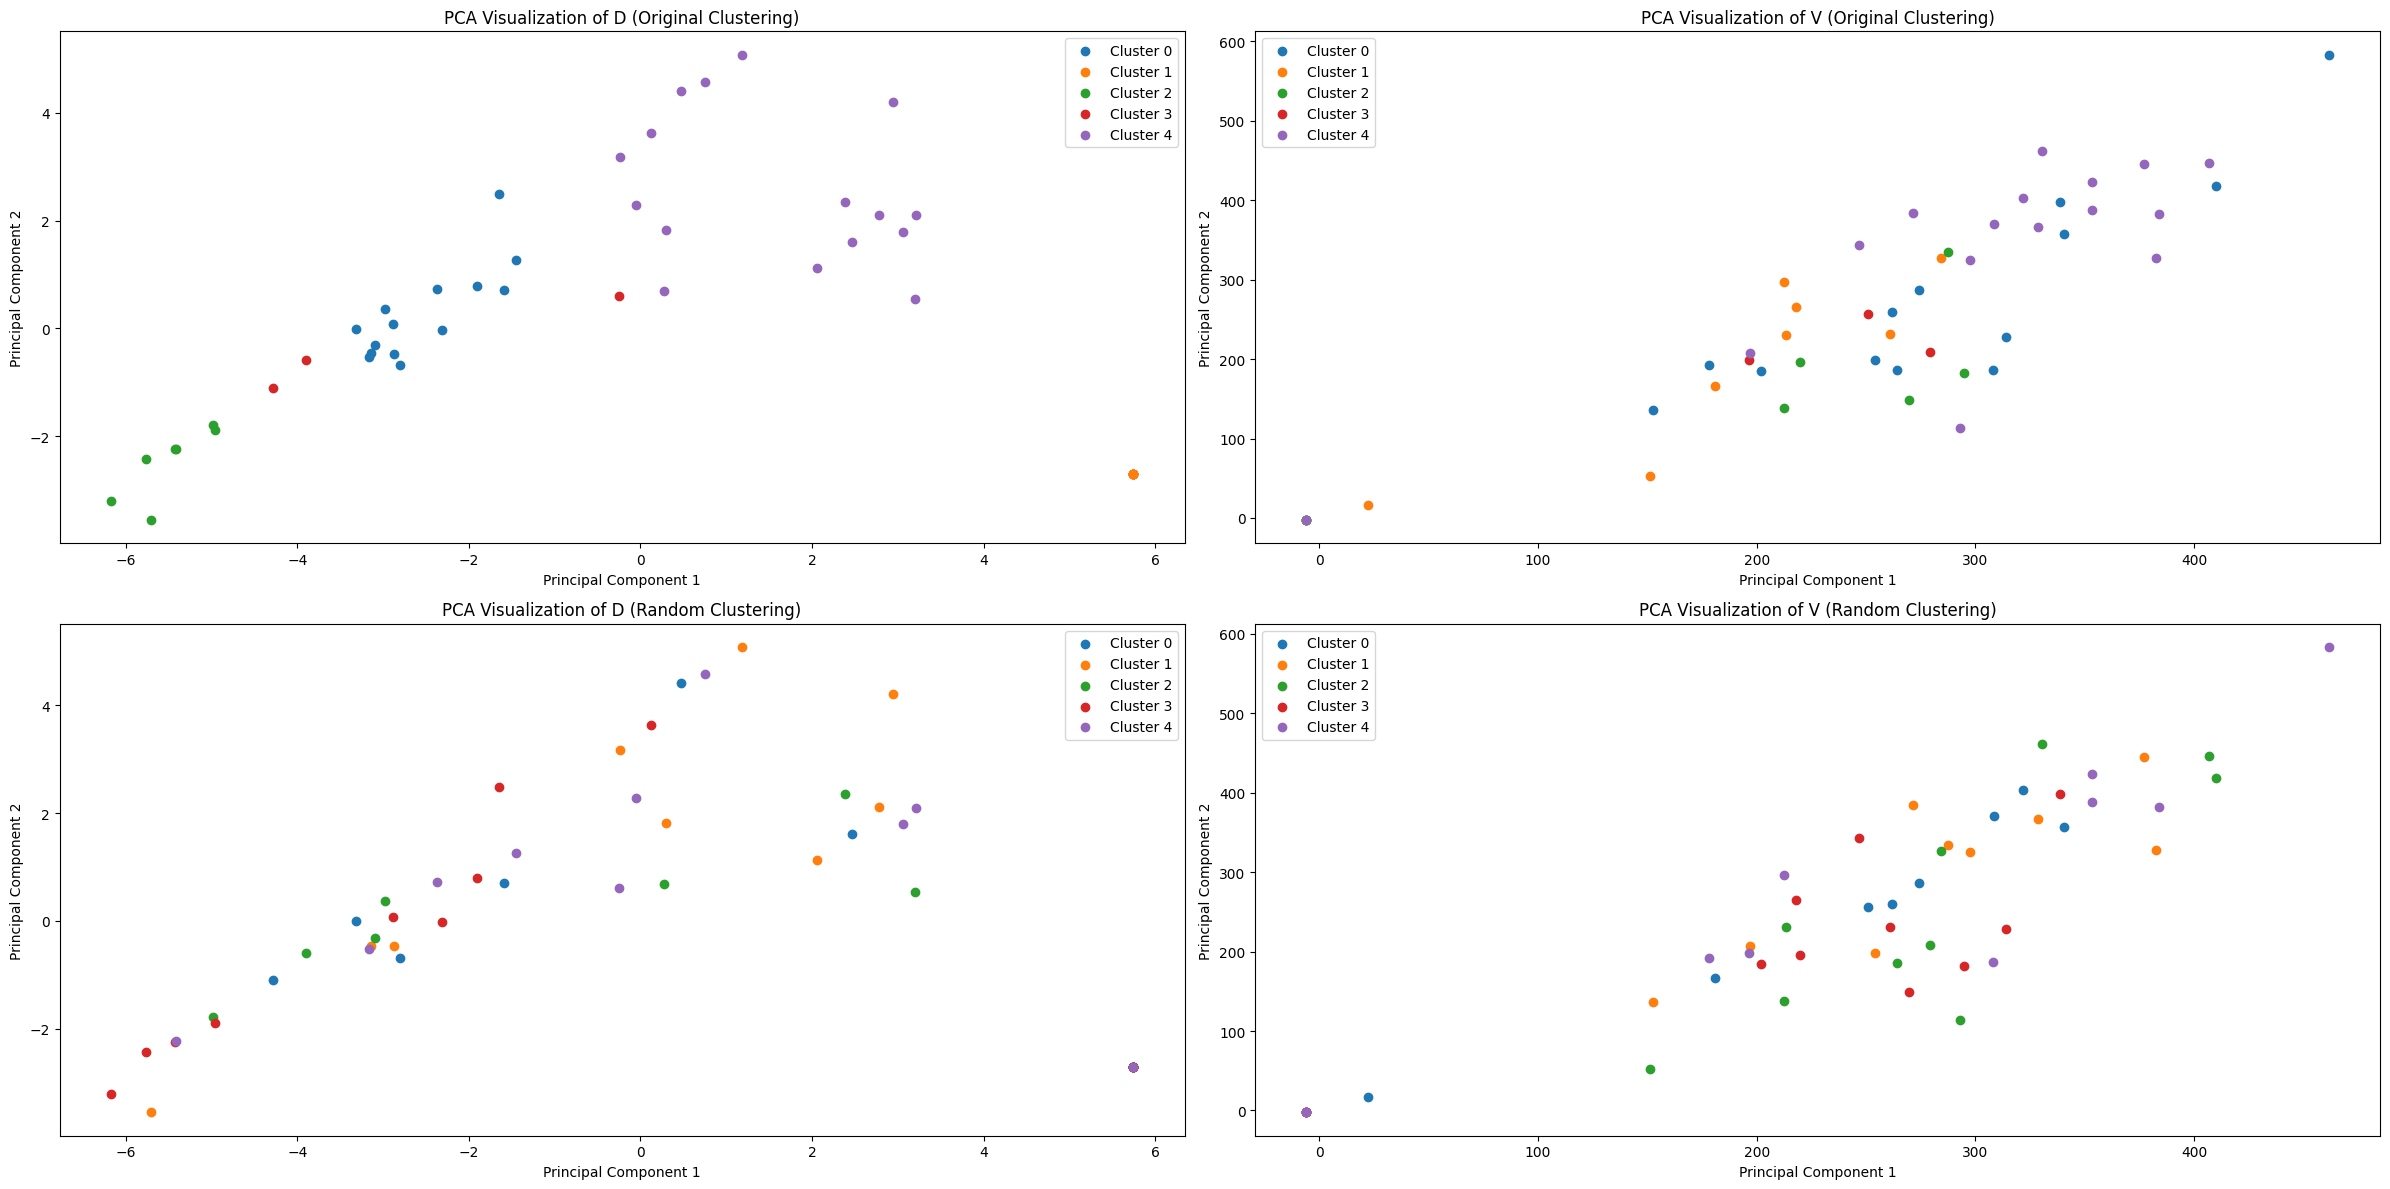

The silhouette score for D data (Original) is: 0.28333725746742755
The silhouette score for V data (Original) is: -0.05257350238310522
The silhouette score for D data (Random) is: -0.06891364801944302
The silhouette score for V data (Random) is: -0.06546869701472997


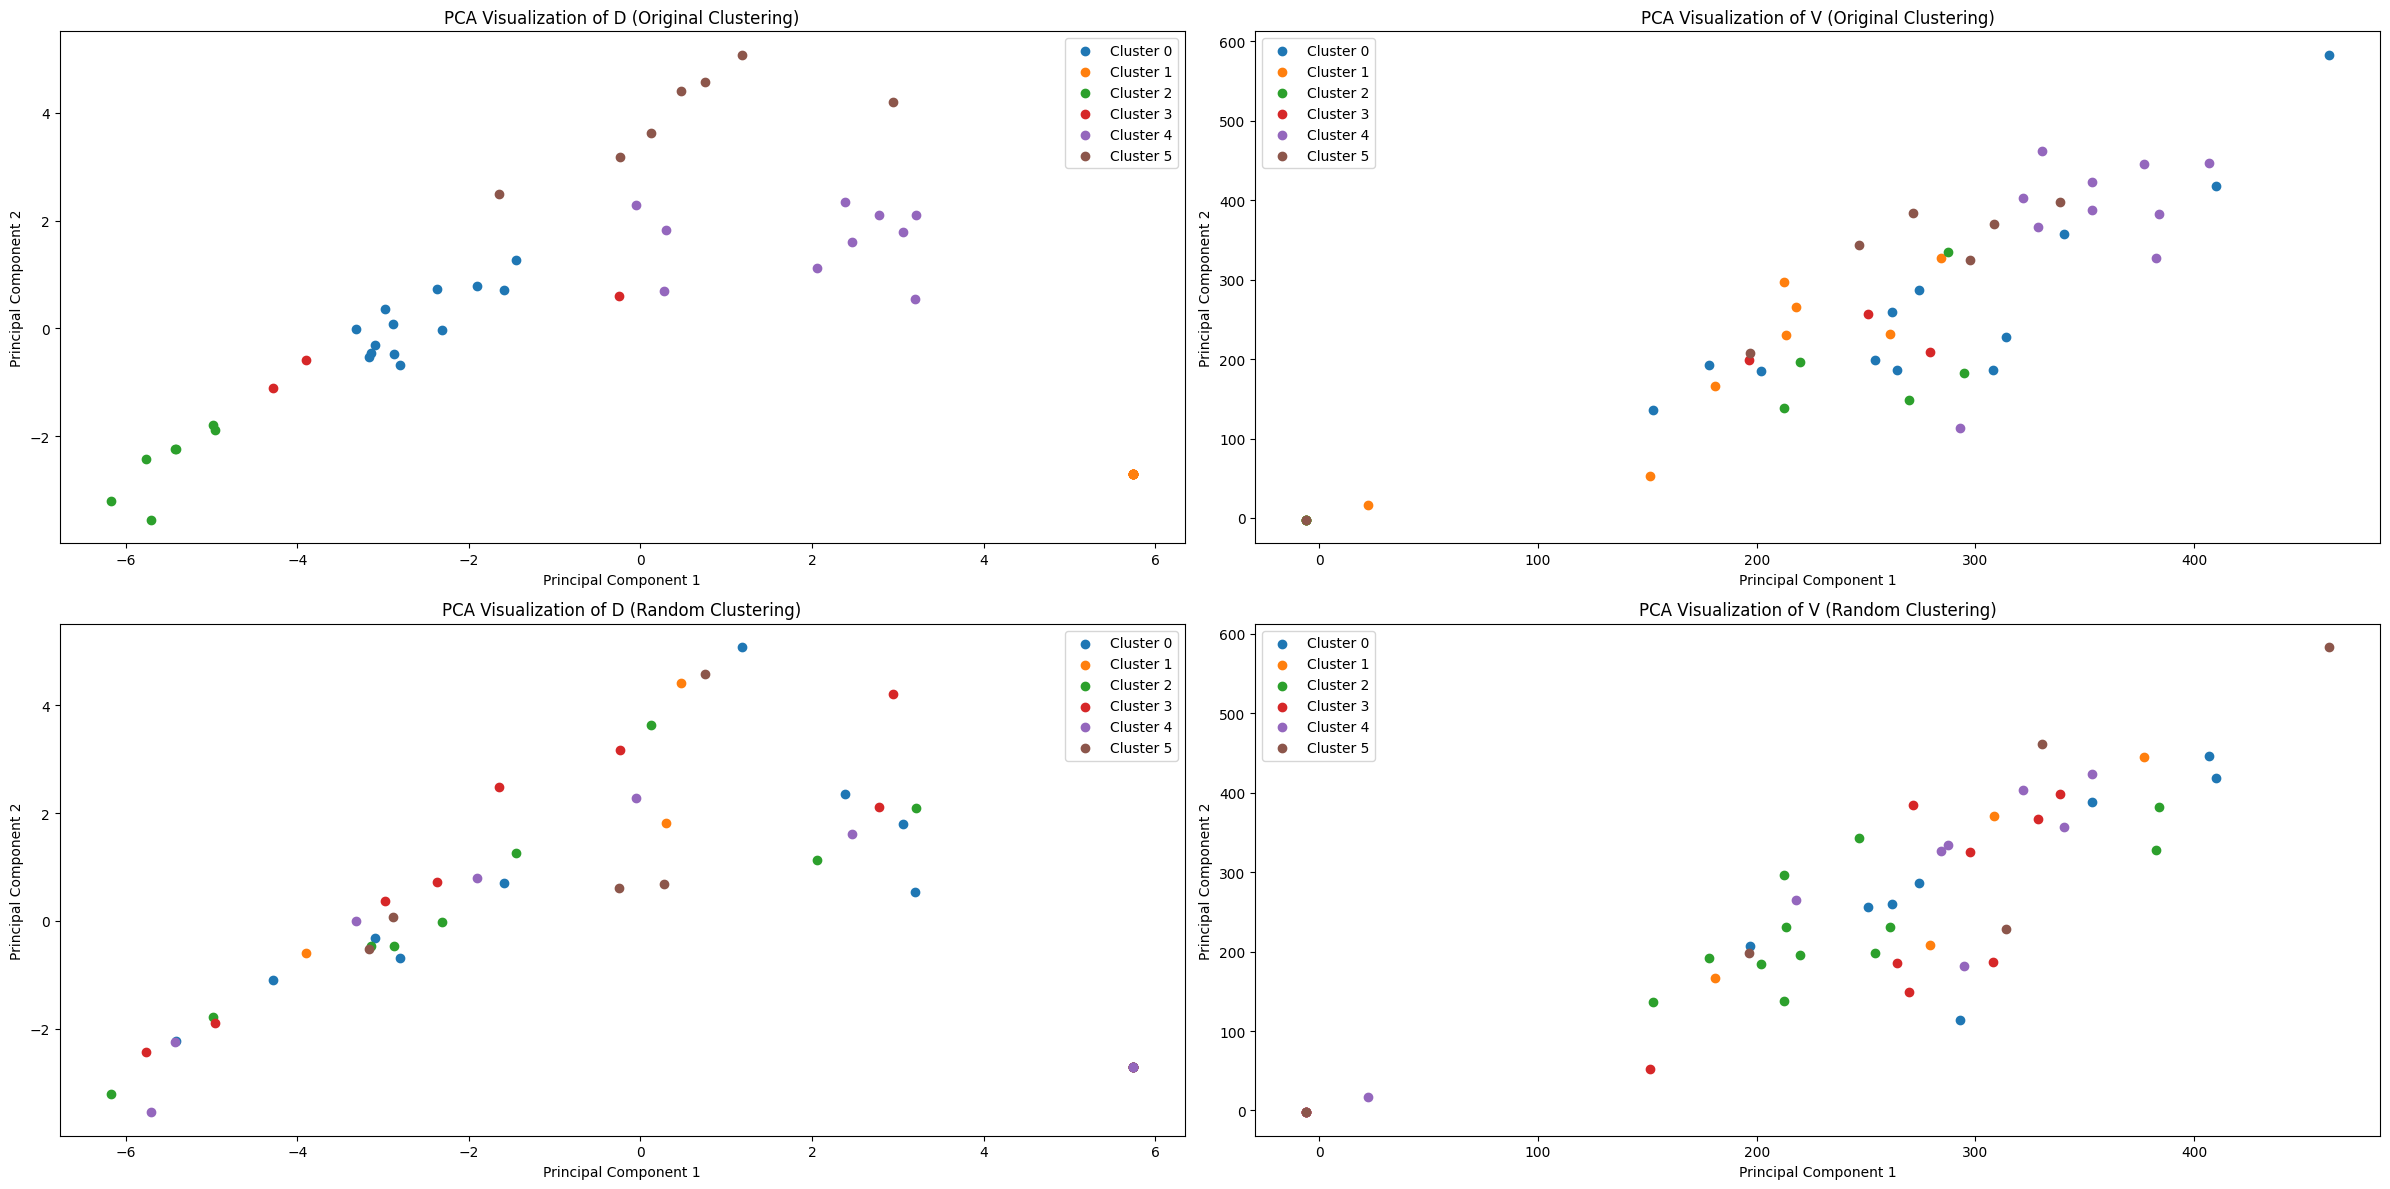

The silhouette score for D data (Original) is: 0.29892921037985626
The silhouette score for V data (Original) is: -0.04739321953922323
The silhouette score for D data (Random) is: -0.1071132549130348
The silhouette score for V data (Random) is: -0.07753731678577992


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


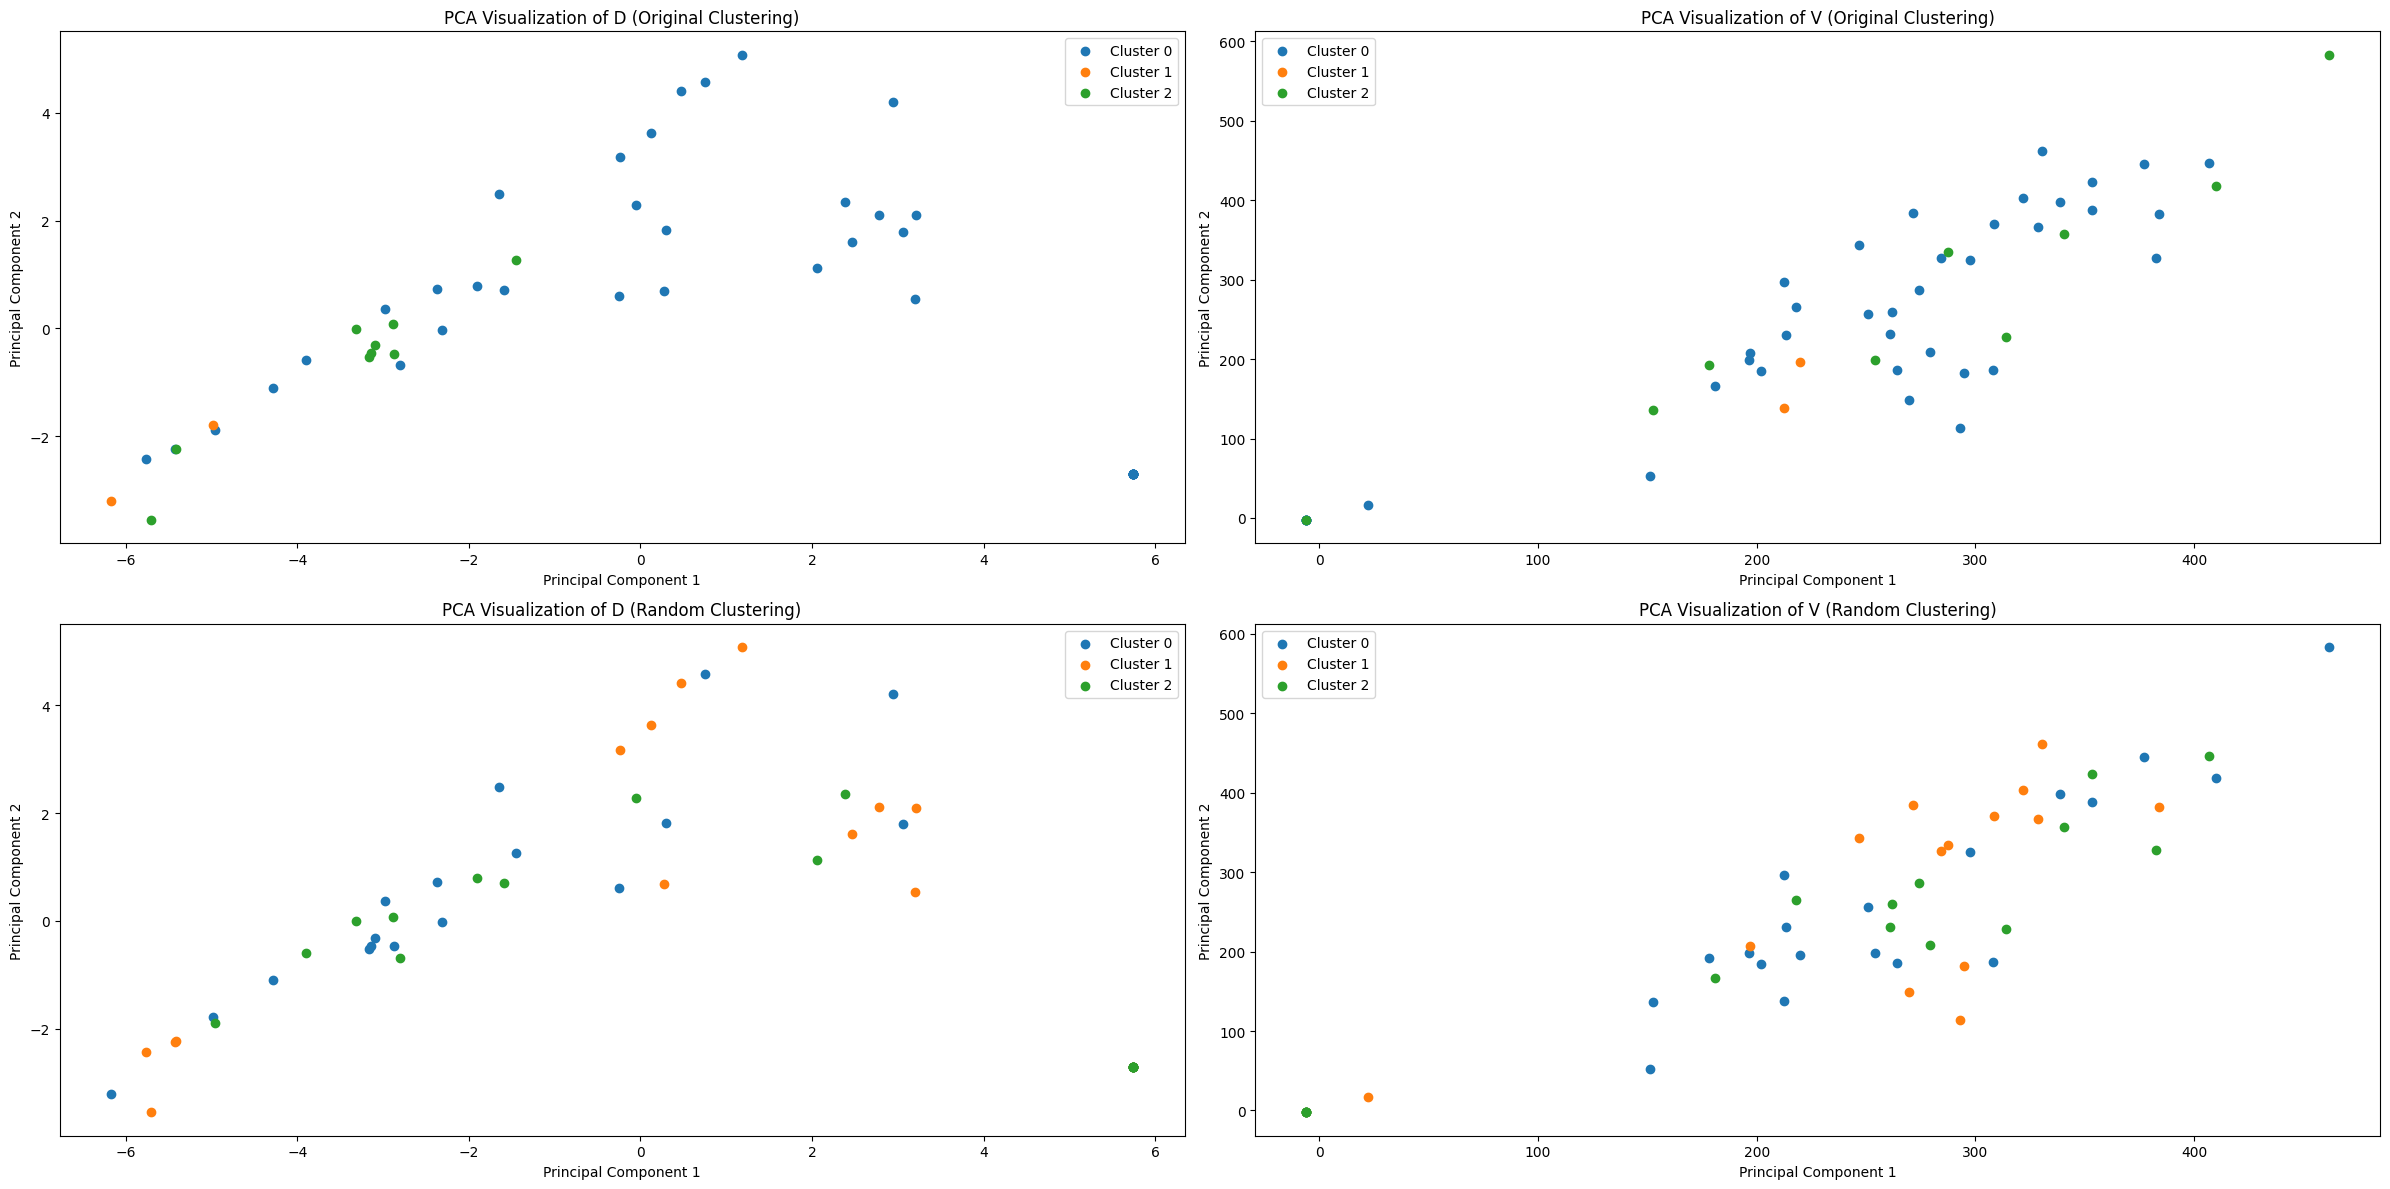

The silhouette score for D data (Original) is: 0.13173443250188635
The silhouette score for V data (Original) is: -0.13053570555440155
The silhouette score for D data (Random) is: -0.029977859966534424
The silhouette score for V data (Random) is: -0.018236343109232785


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


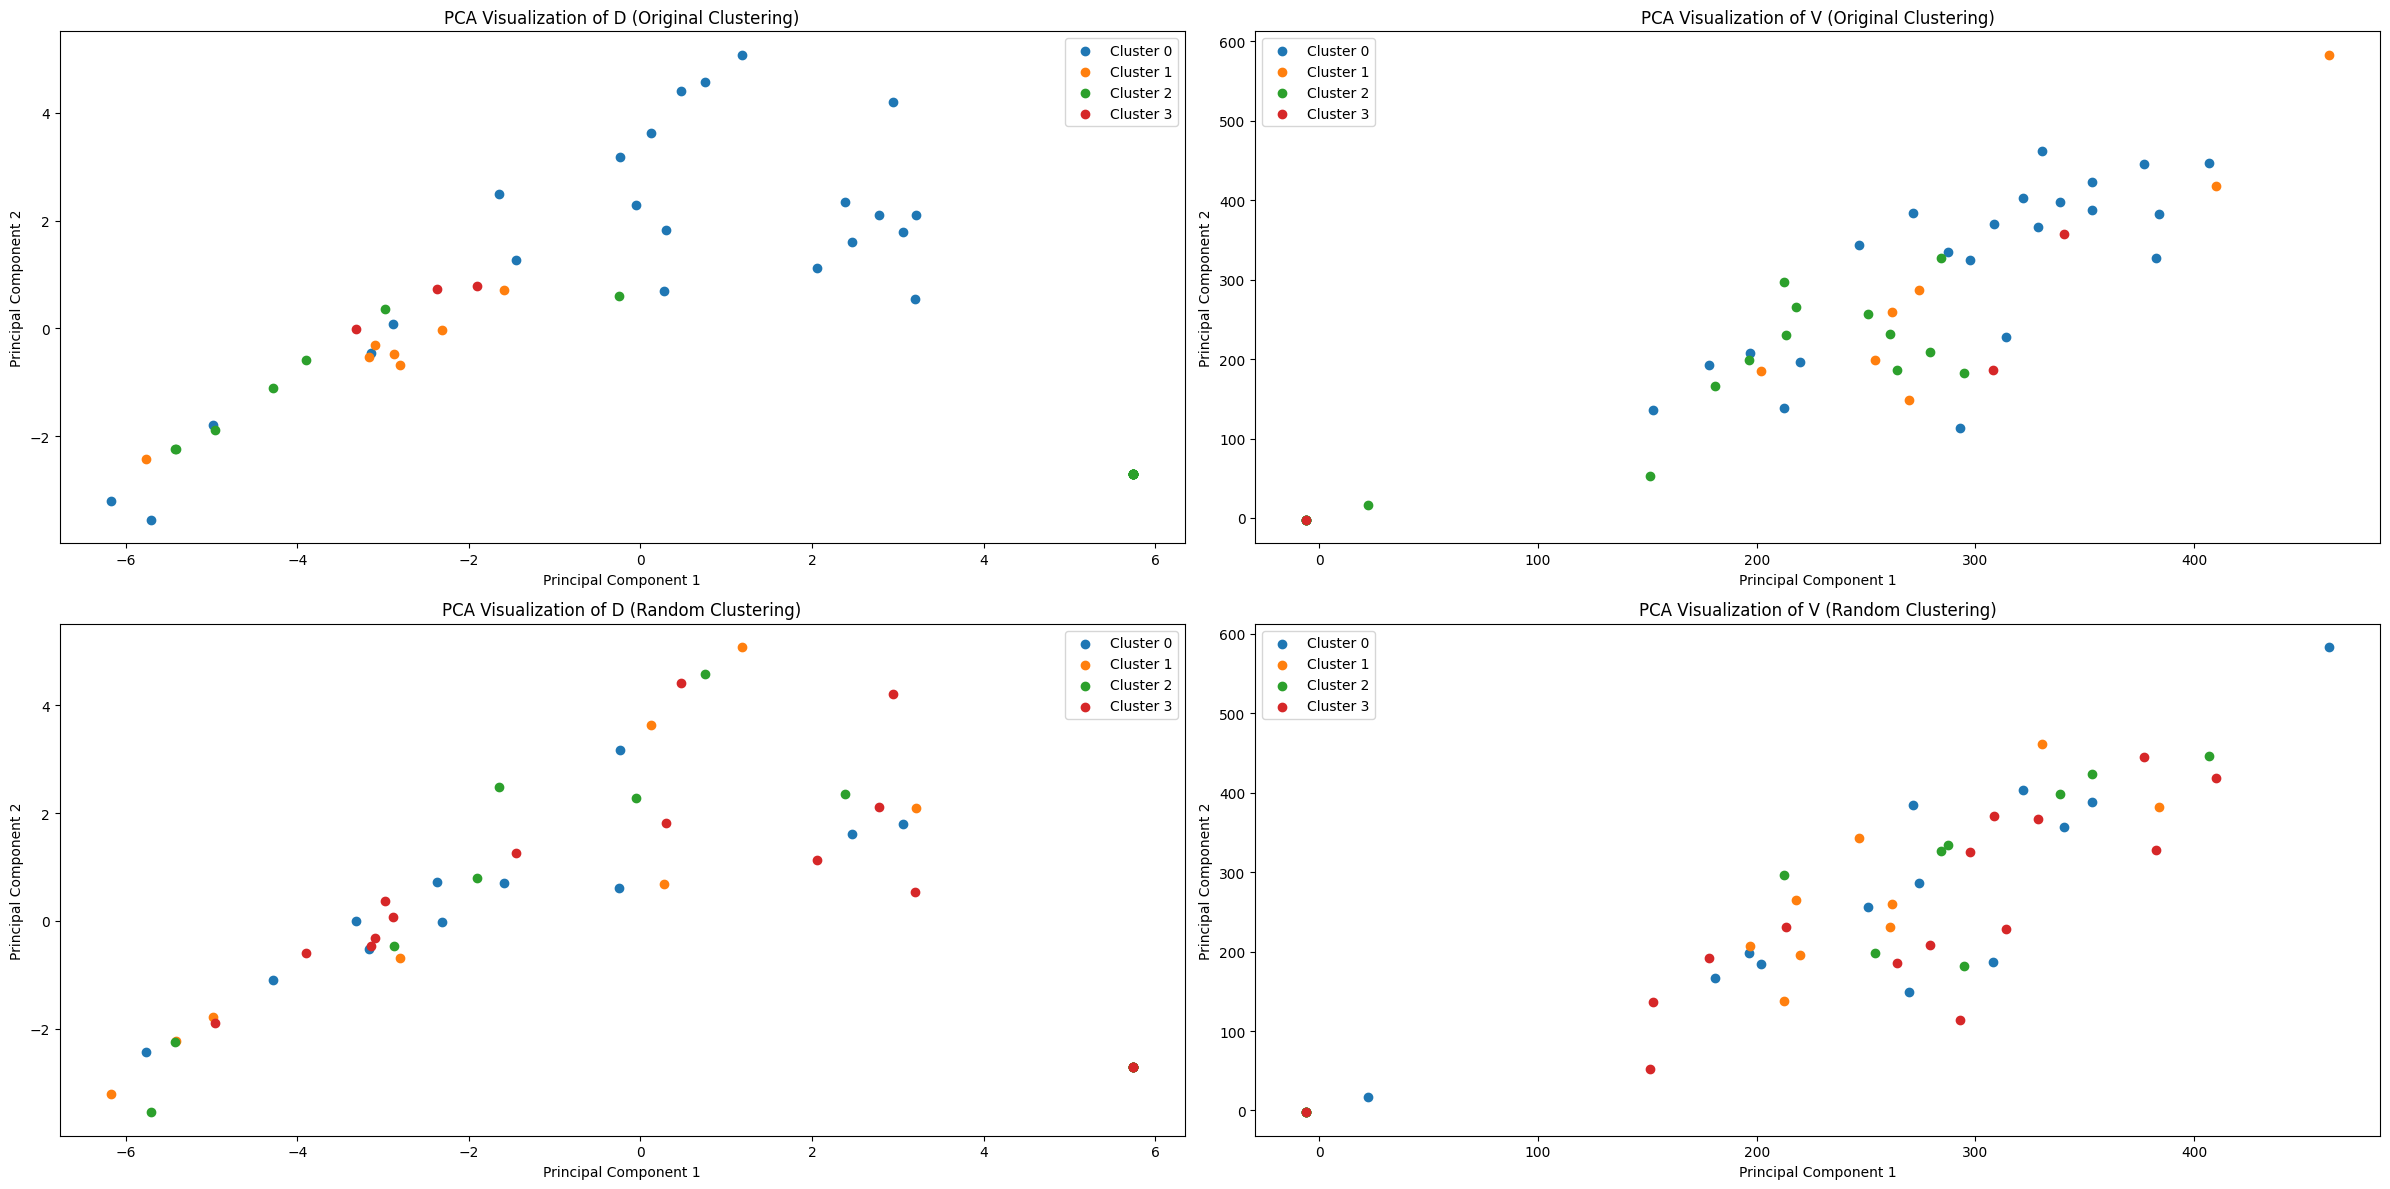

The silhouette score for D data (Original) is: 0.12063505058643022
The silhouette score for V data (Original) is: -0.039461288761855534
The silhouette score for D data (Random) is: -0.042439799299705566
The silhouette score for V data (Random) is: -0.04970676426321195


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


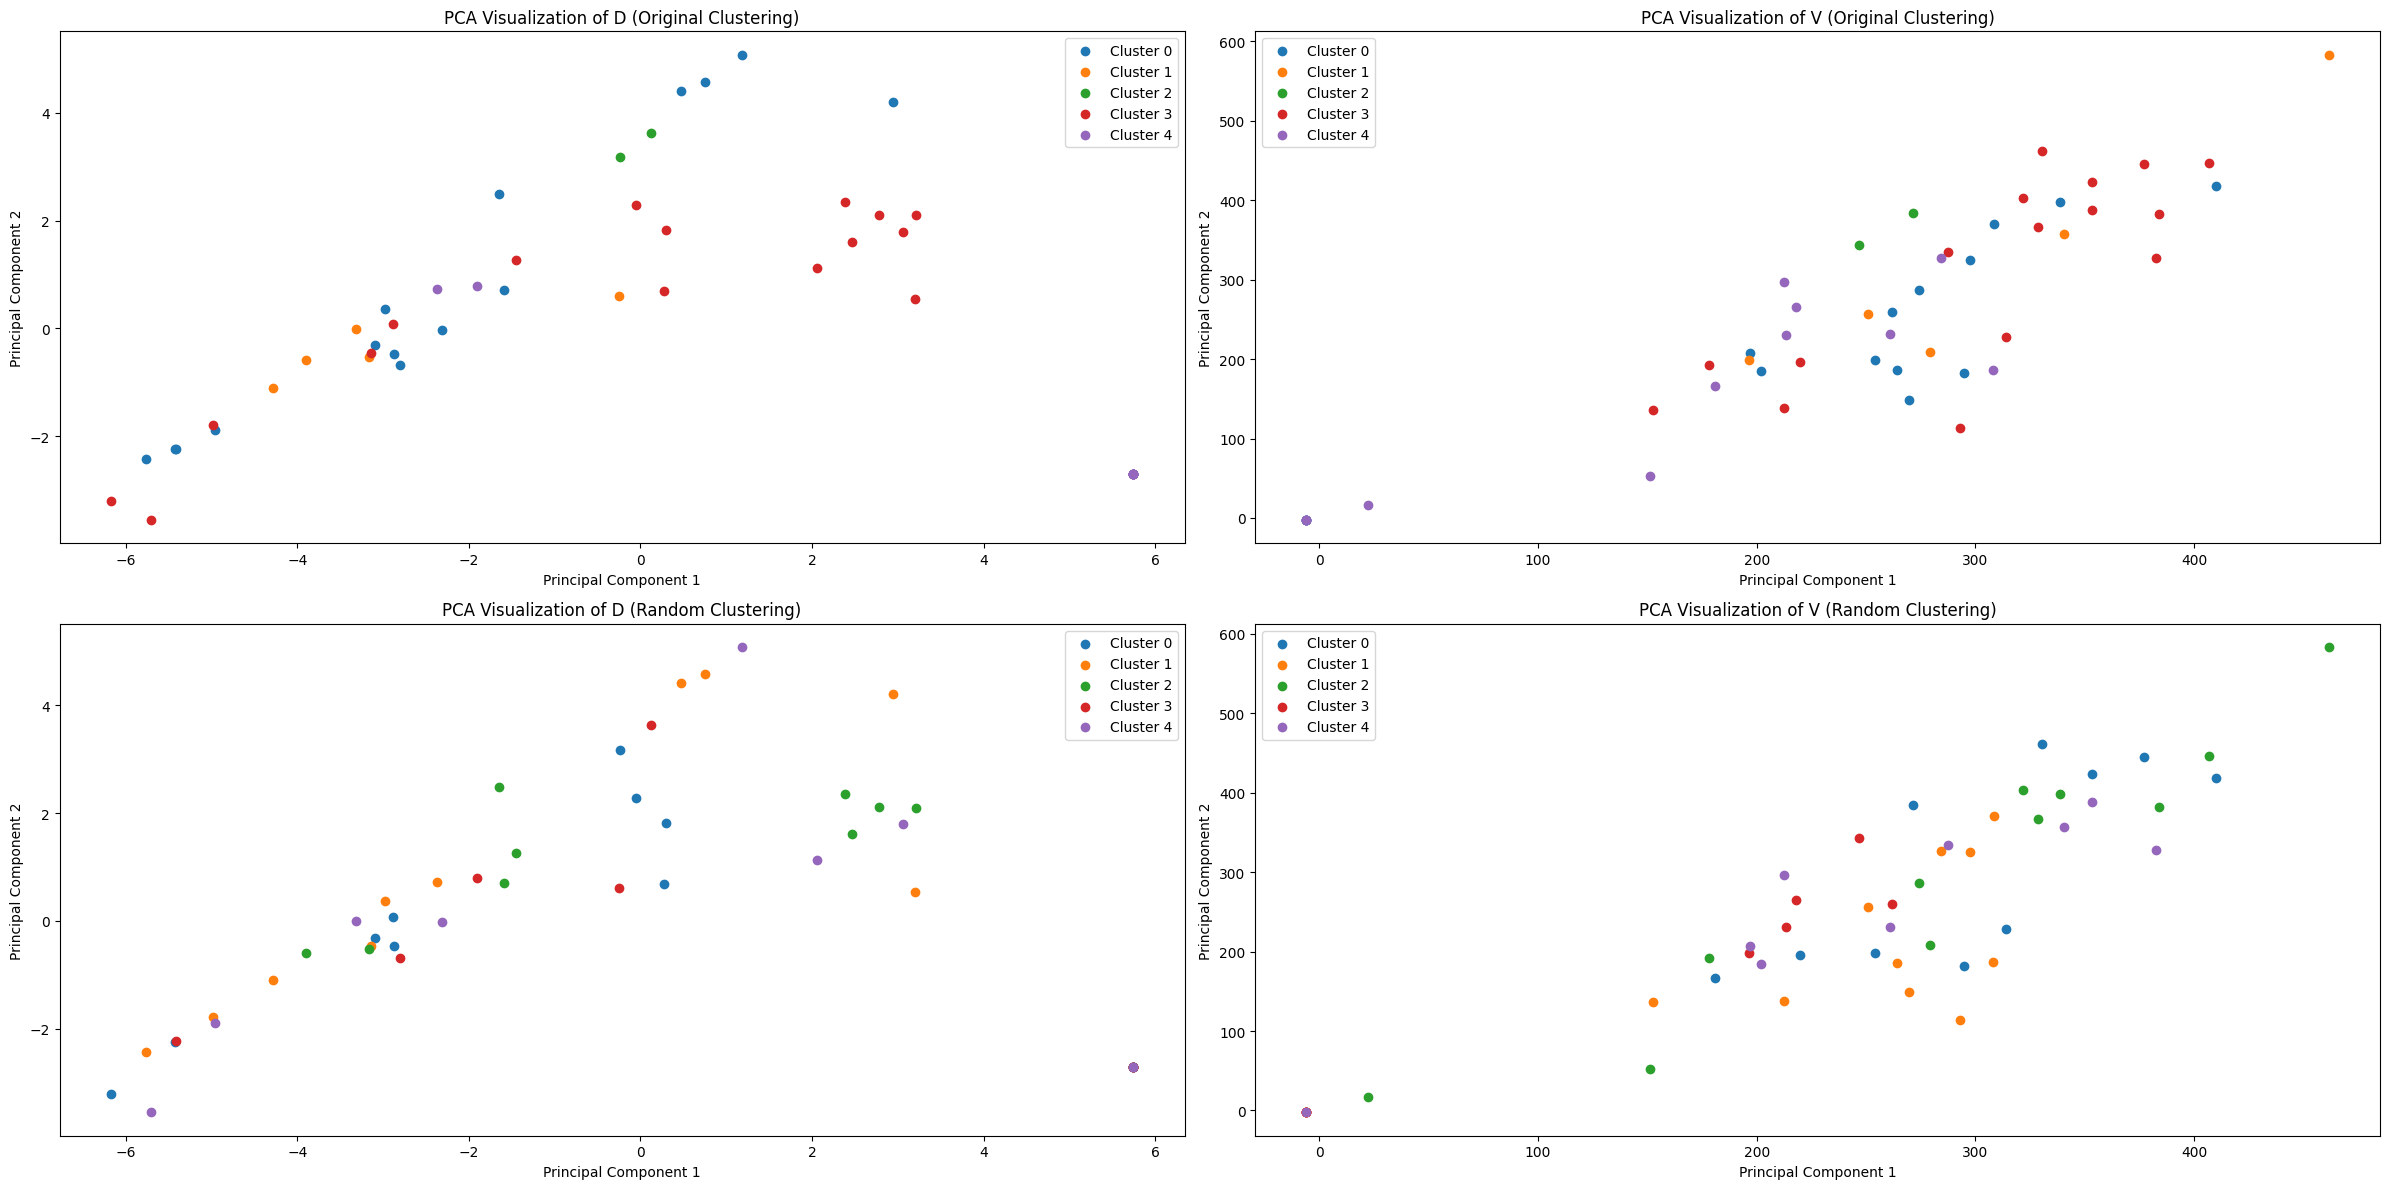

The silhouette score for D data (Original) is: 0.15377292333505296
The silhouette score for V data (Original) is: -0.0847493720789759
The silhouette score for D data (Random) is: -0.07060983509745276
The silhouette score for V data (Random) is: -0.05909737912801731


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


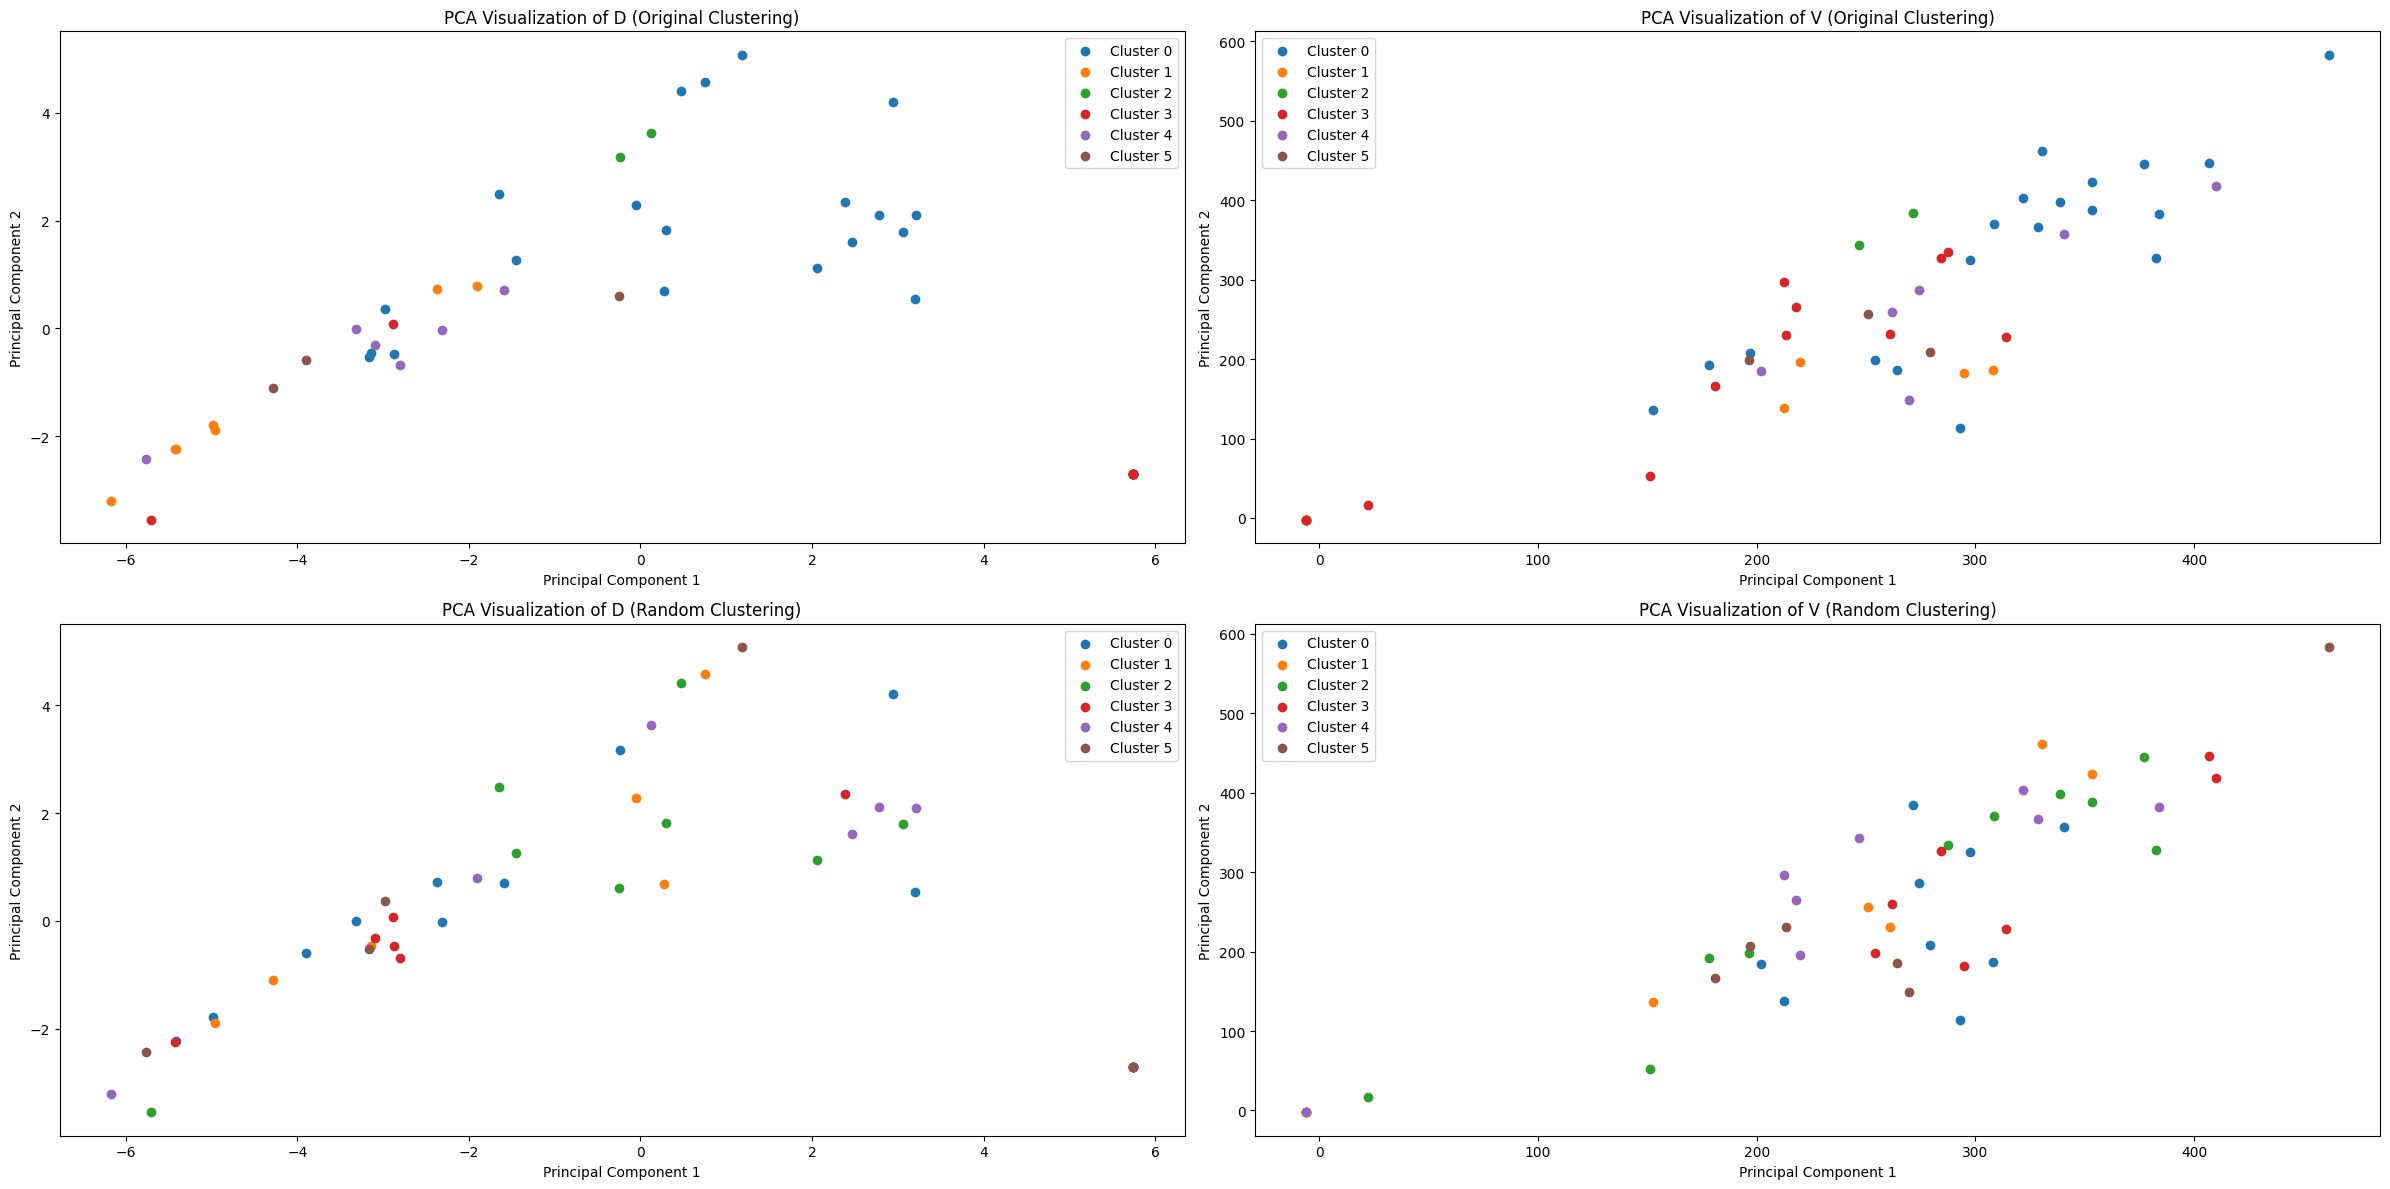

The silhouette score for D data (Original) is: 0.19511085690248017
The silhouette score for V data (Original) is: -0.09983406968890413
The silhouette score for D data (Random) is: -0.09067909910206341
The silhouette score for V data (Random) is: -0.07437403530749714


In [43]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 6, method='SpectralClustering')

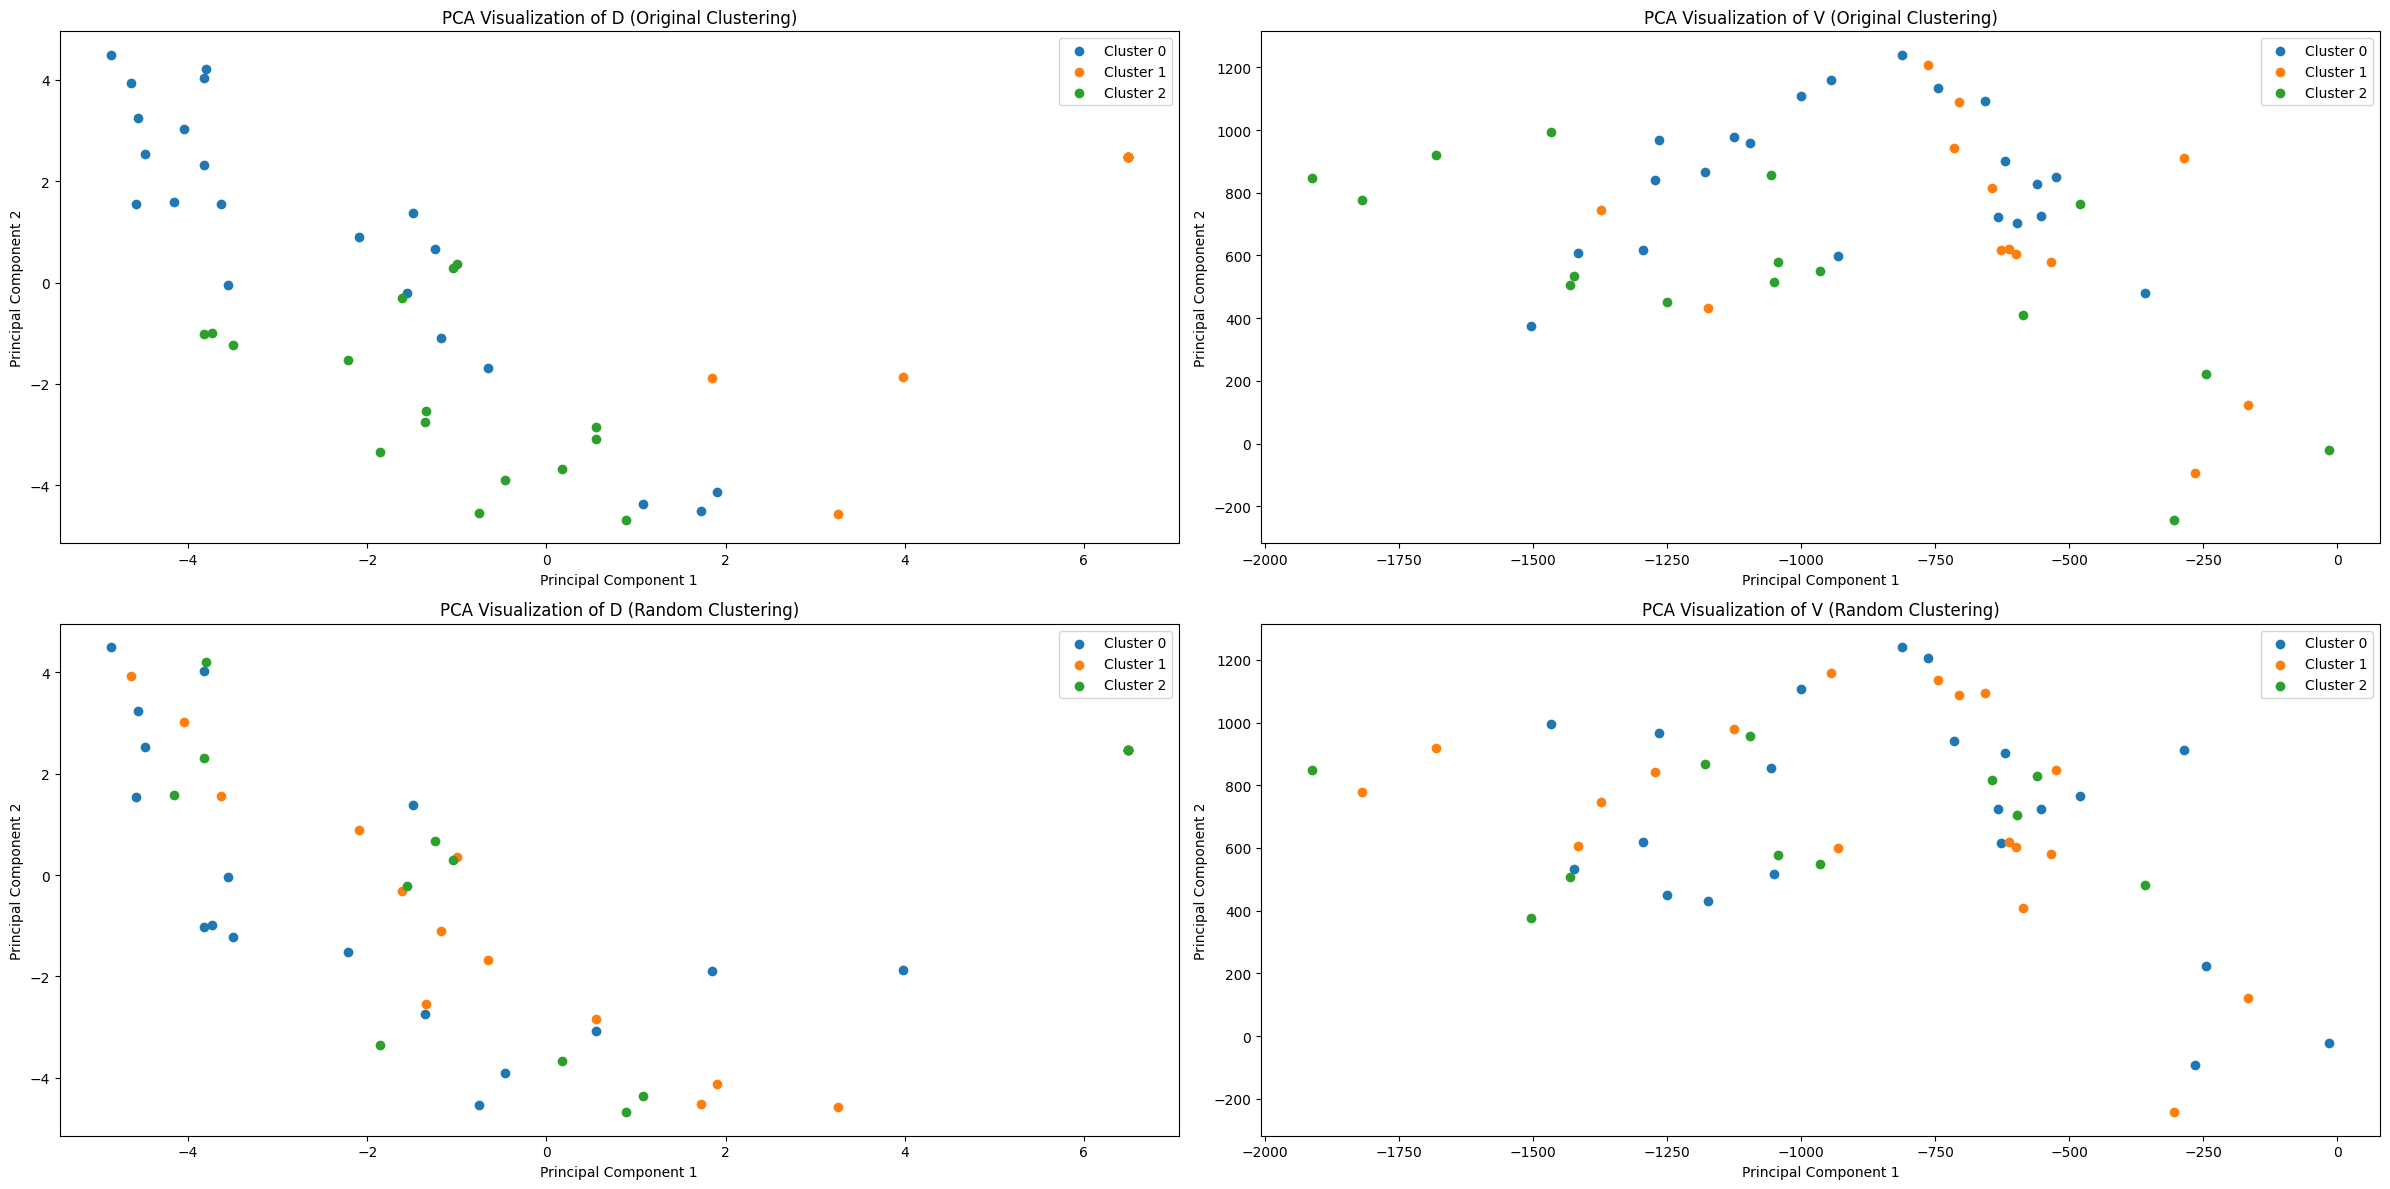

The silhouette score for D data (Original) is: 0.27343912346199784
The silhouette score for V data (Original) is: -0.01547402498638839
The silhouette score for D data (Random) is: -0.036898686518616476
The silhouette score for V data (Random) is: -0.038436360378759186


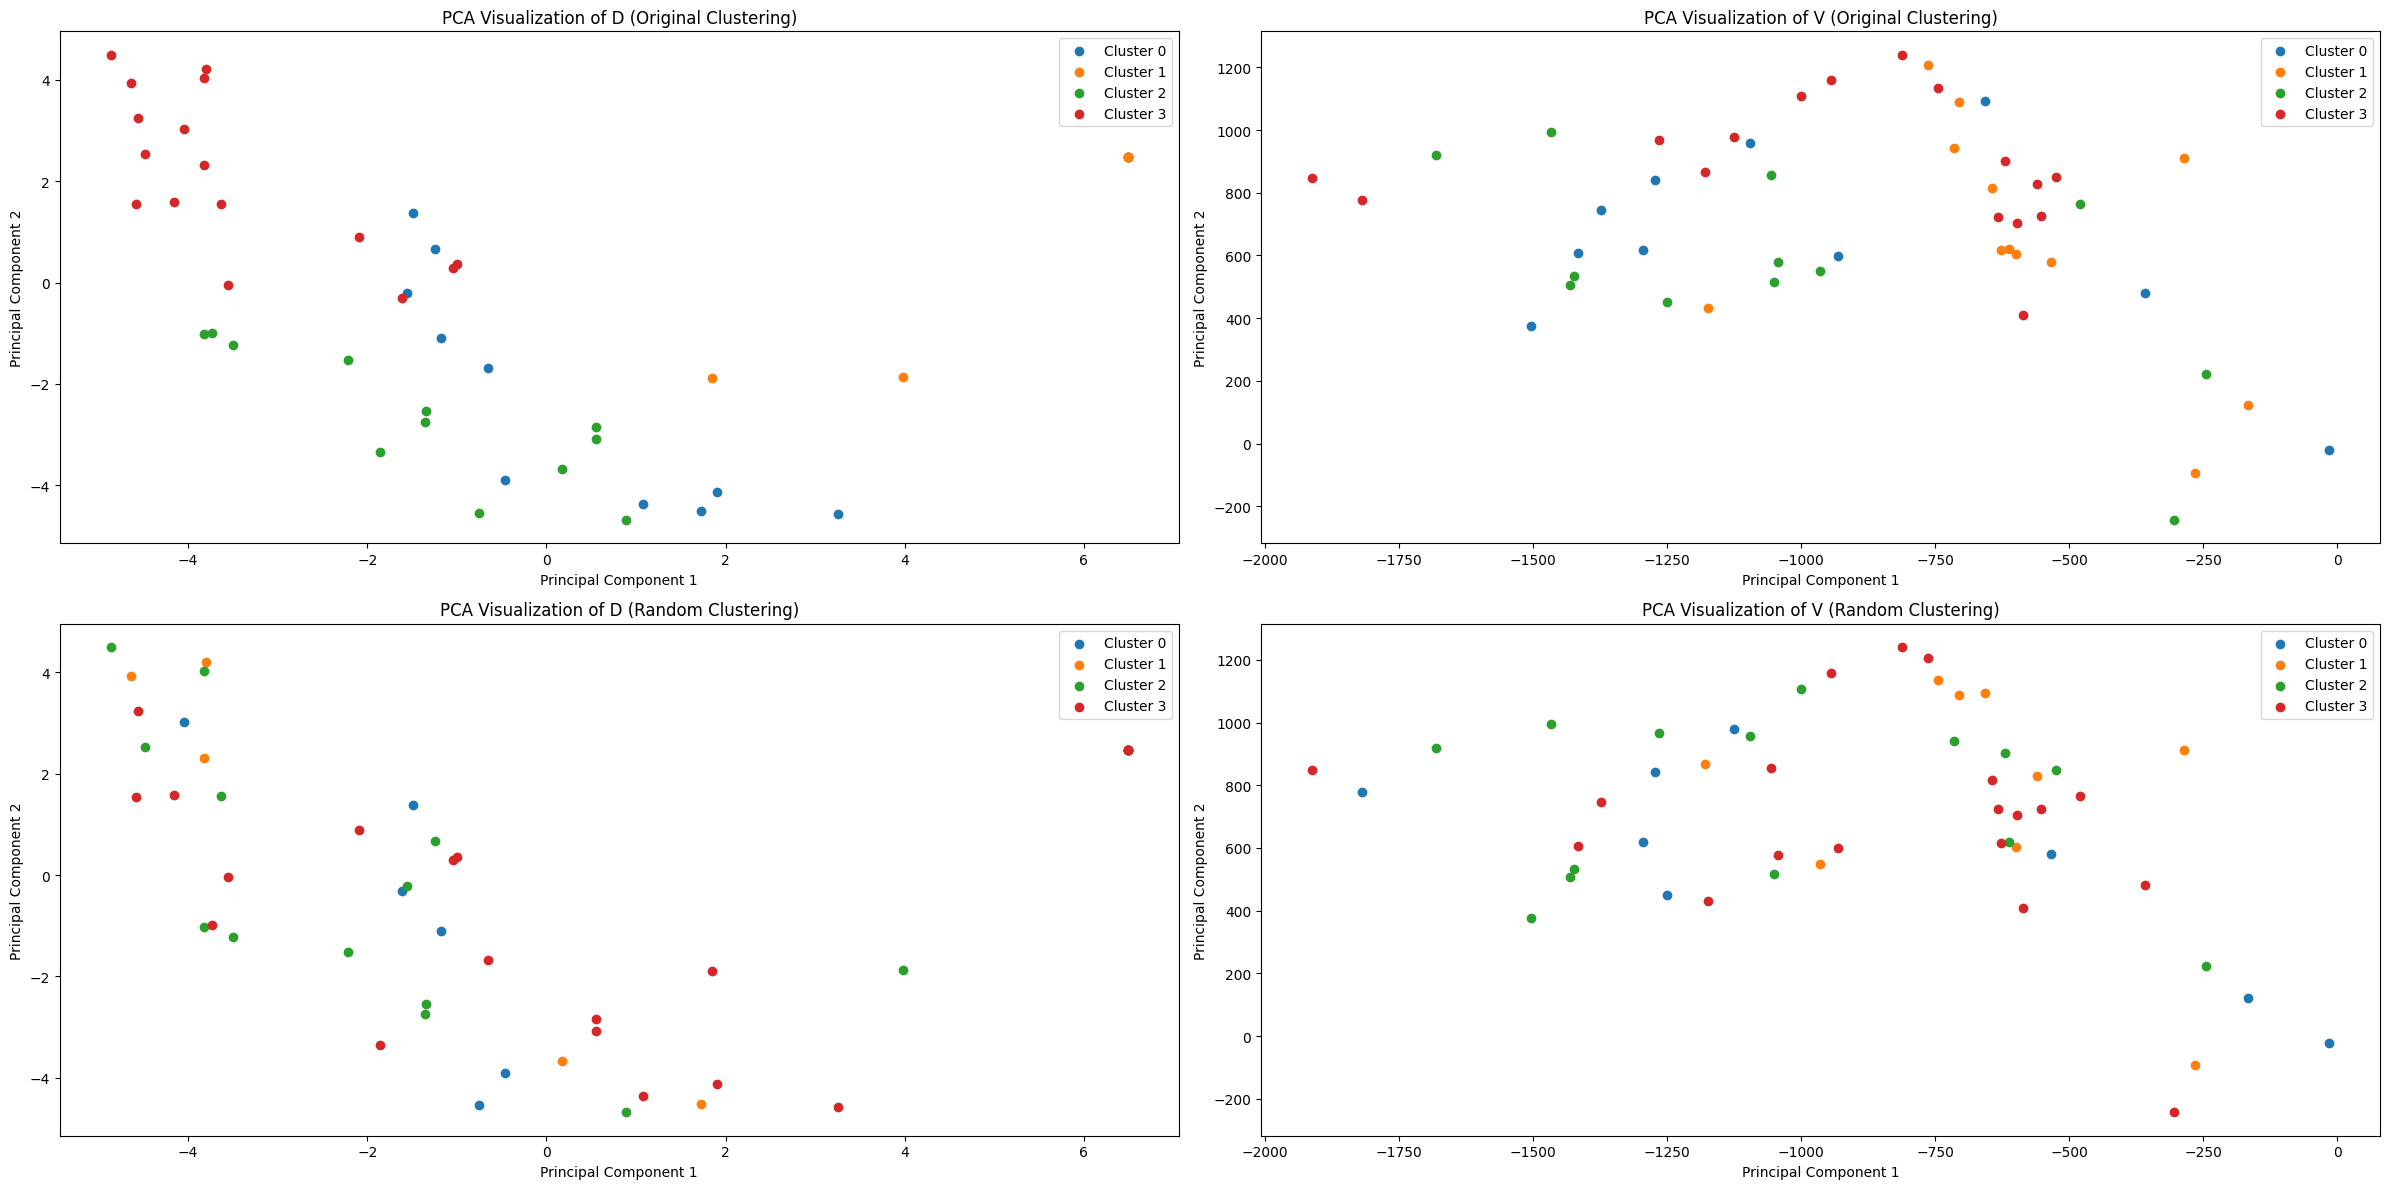

The silhouette score for D data (Original) is: 0.3203752068939478
The silhouette score for V data (Original) is: -0.04413184626820688
The silhouette score for D data (Random) is: -0.06993393077064647
The silhouette score for V data (Random) is: -0.06695868237938536


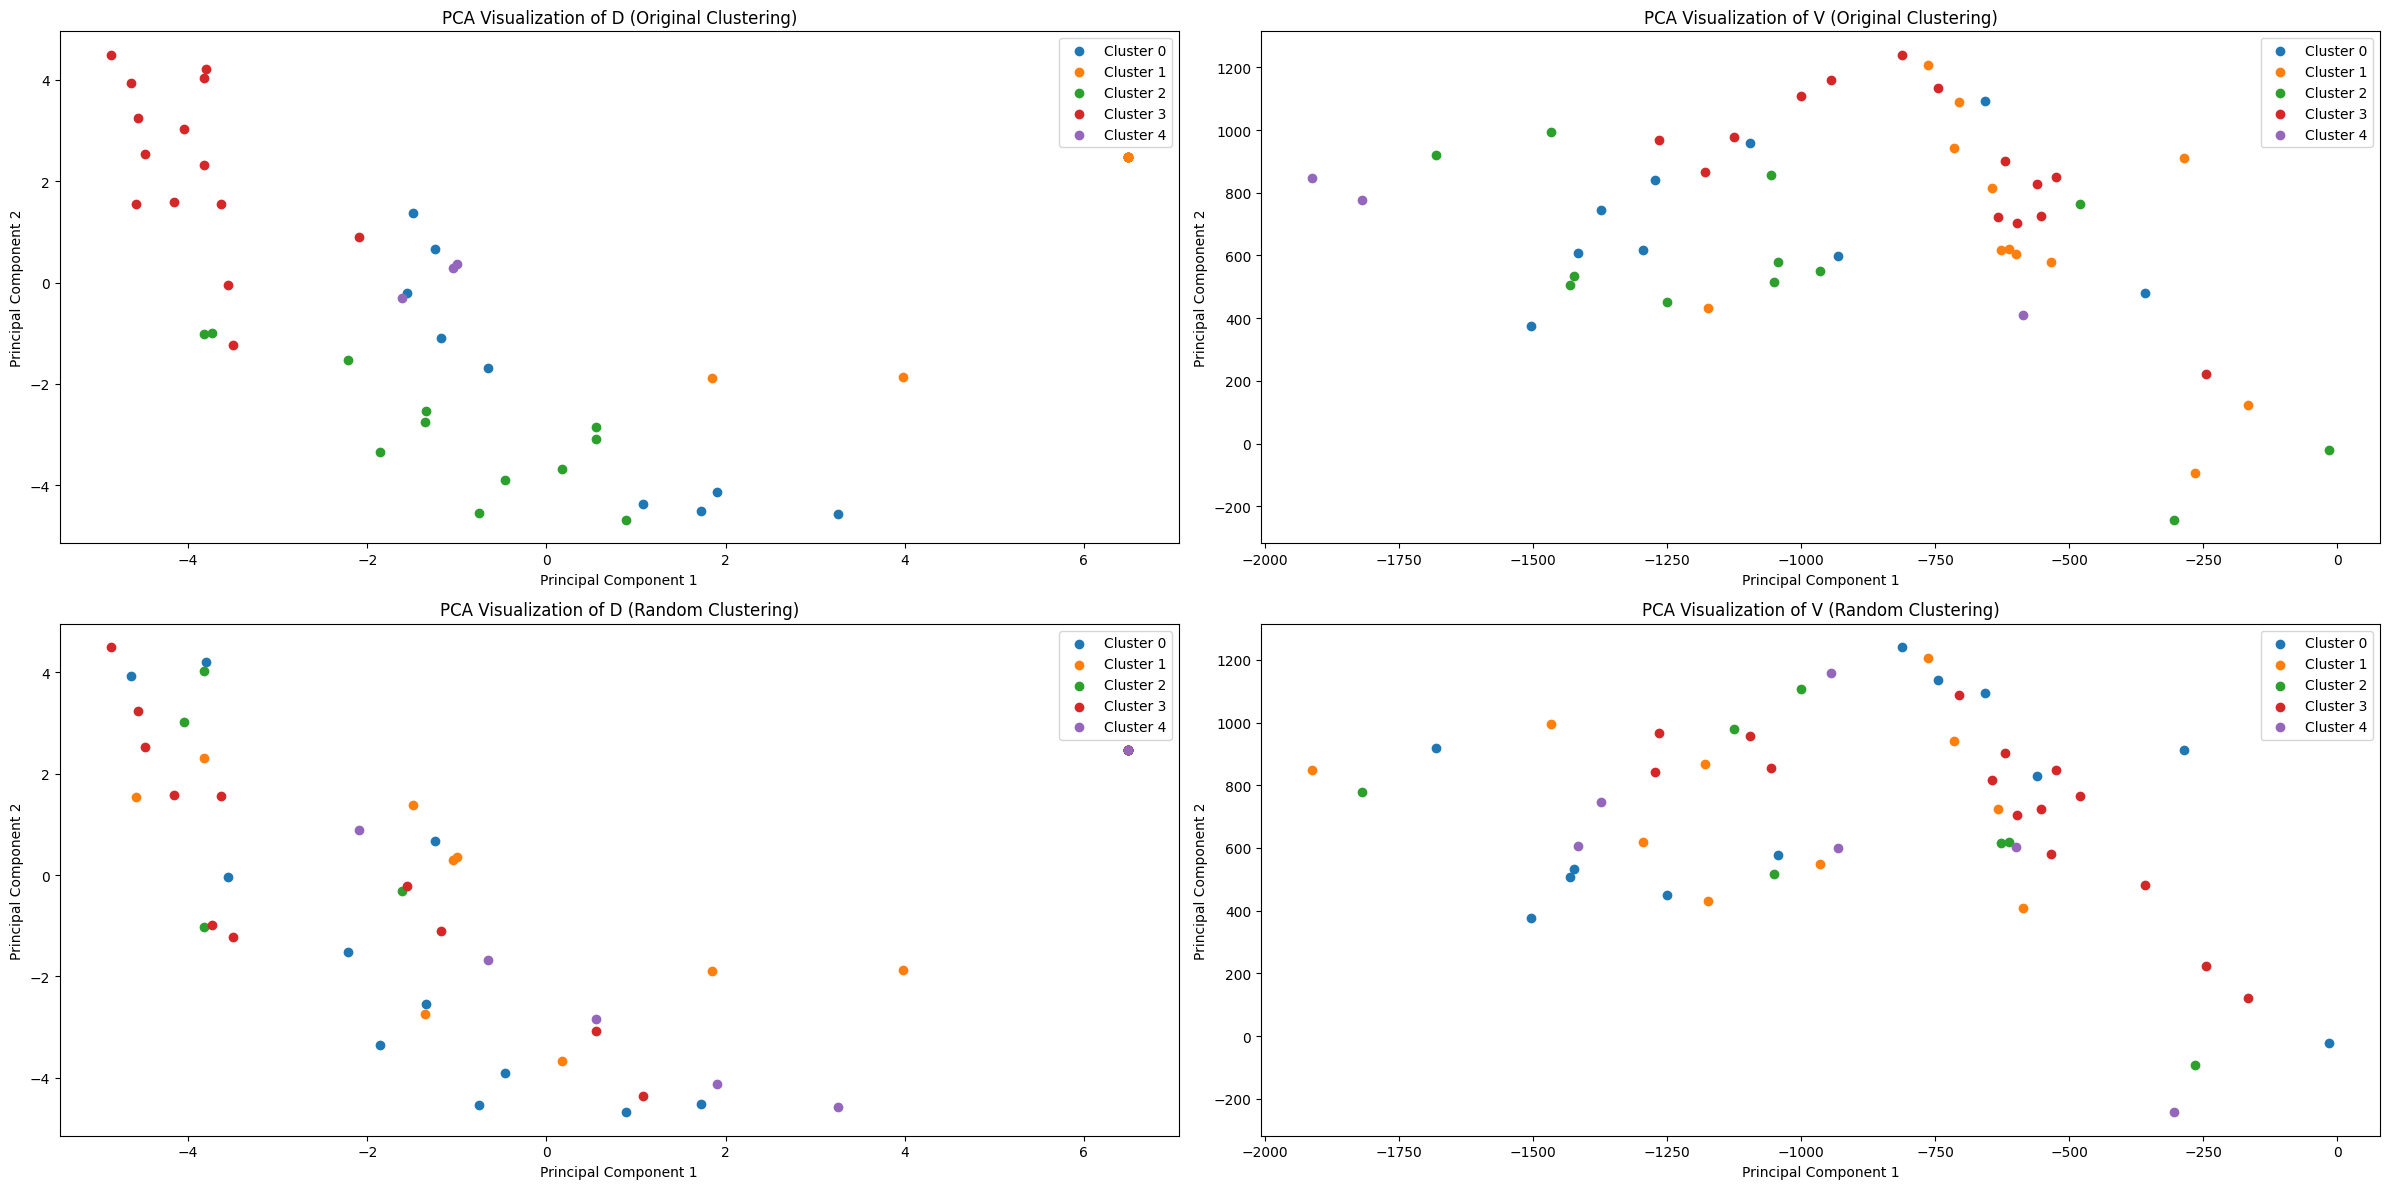

The silhouette score for D data (Original) is: 0.3399109489774598
The silhouette score for V data (Original) is: -0.06359787298613372
The silhouette score for D data (Random) is: -0.07490258610623828
The silhouette score for V data (Random) is: -0.0800132952465262


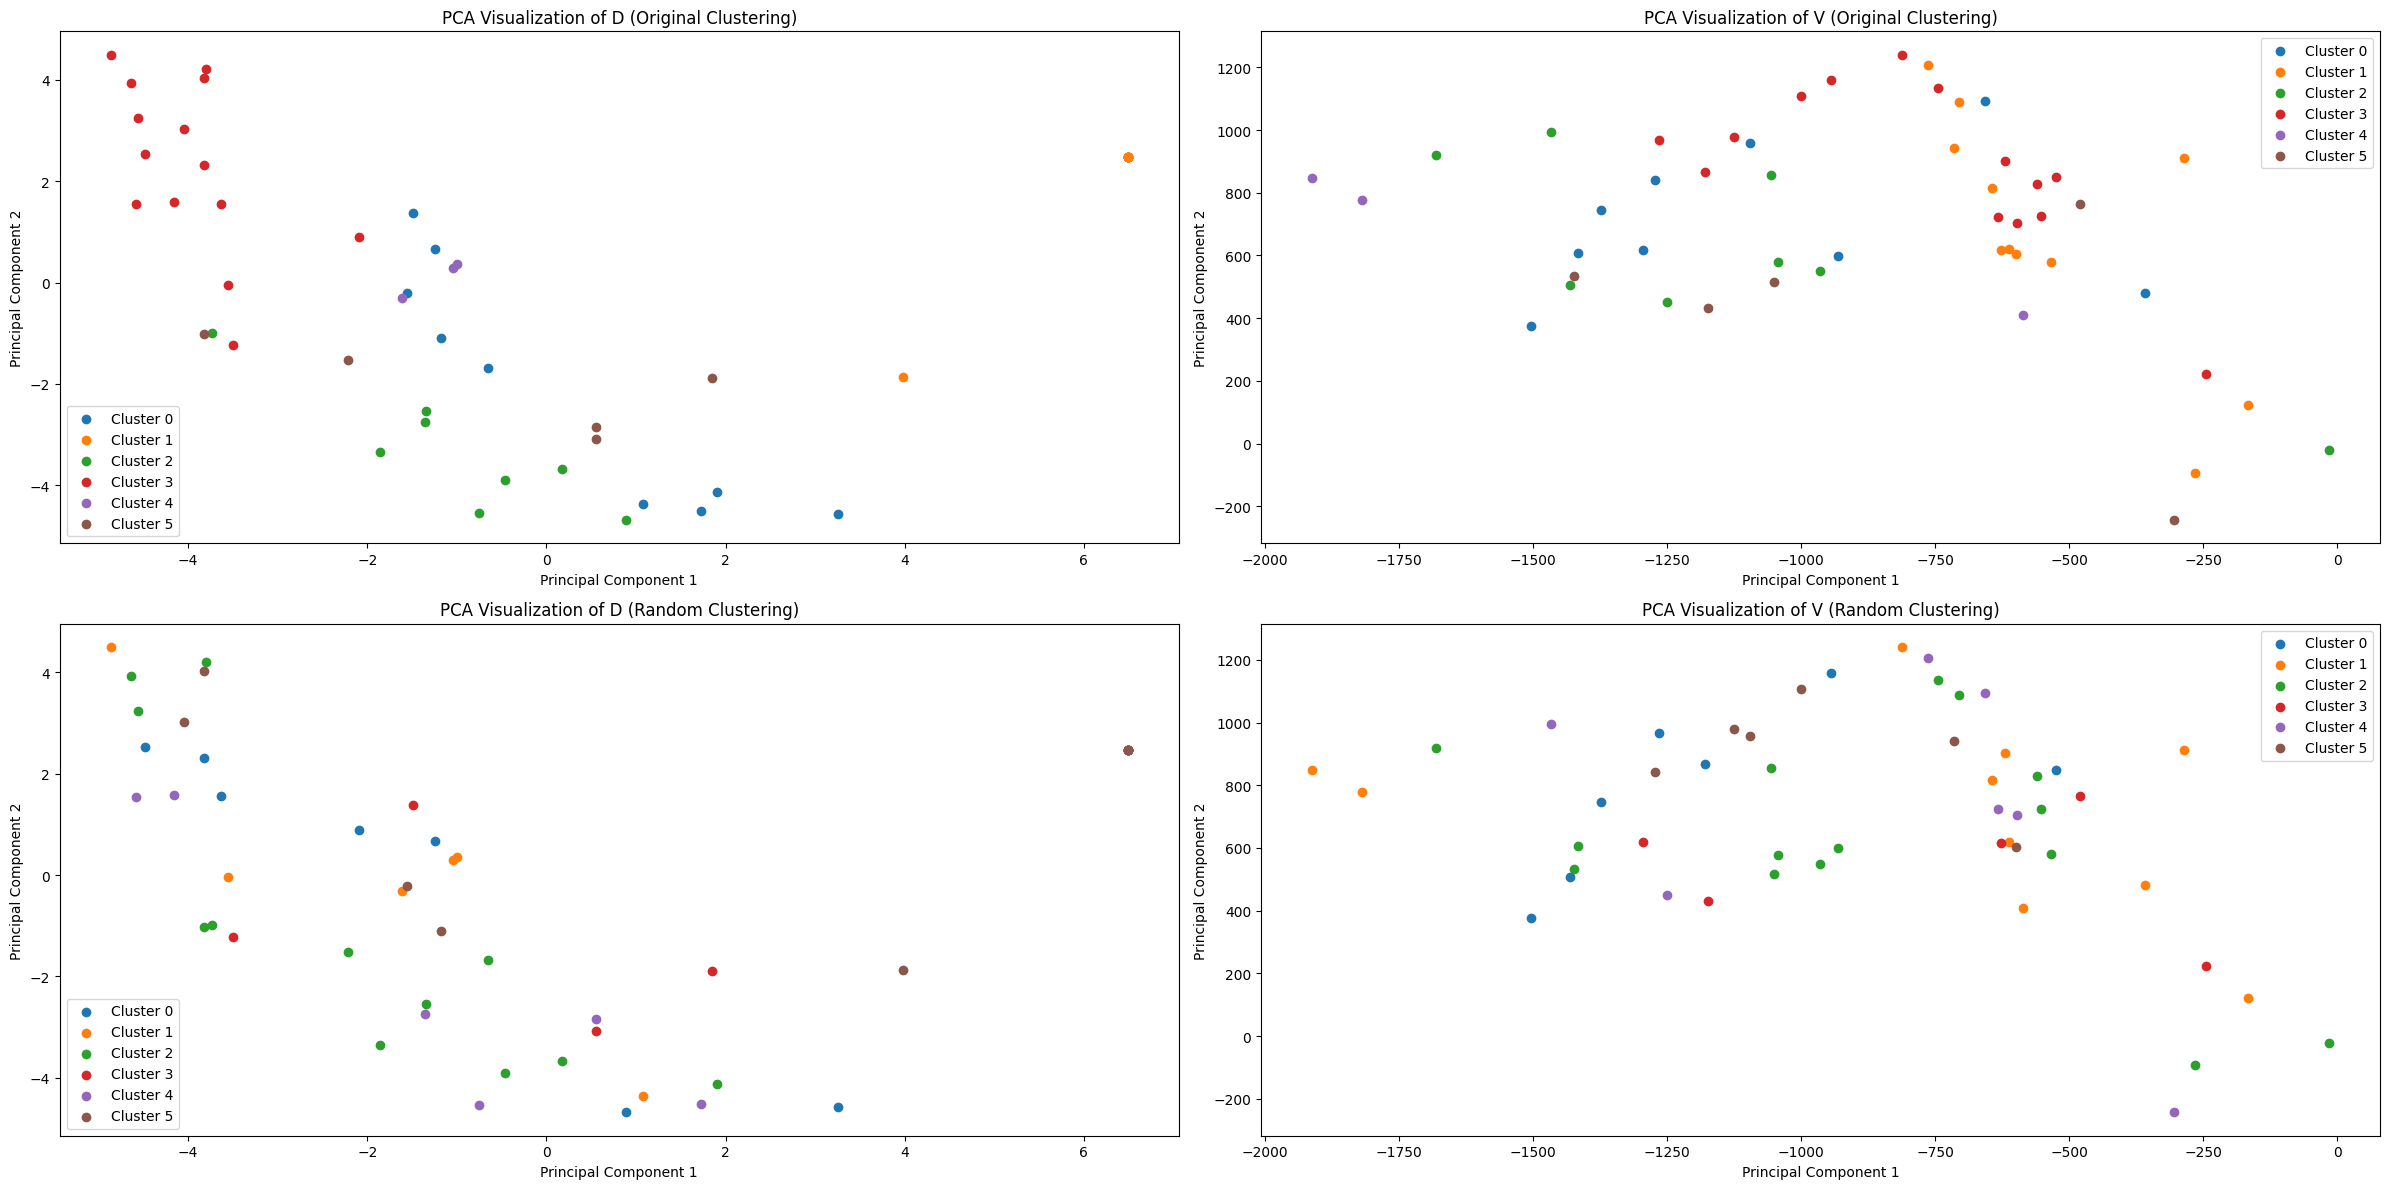

The silhouette score for D data (Original) is: 0.3177506662858891
The silhouette score for V data (Original) is: -0.07141513847264015
The silhouette score for D data (Random) is: -0.09084898601428776
The silhouette score for V data (Random) is: -0.09919999563727418


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


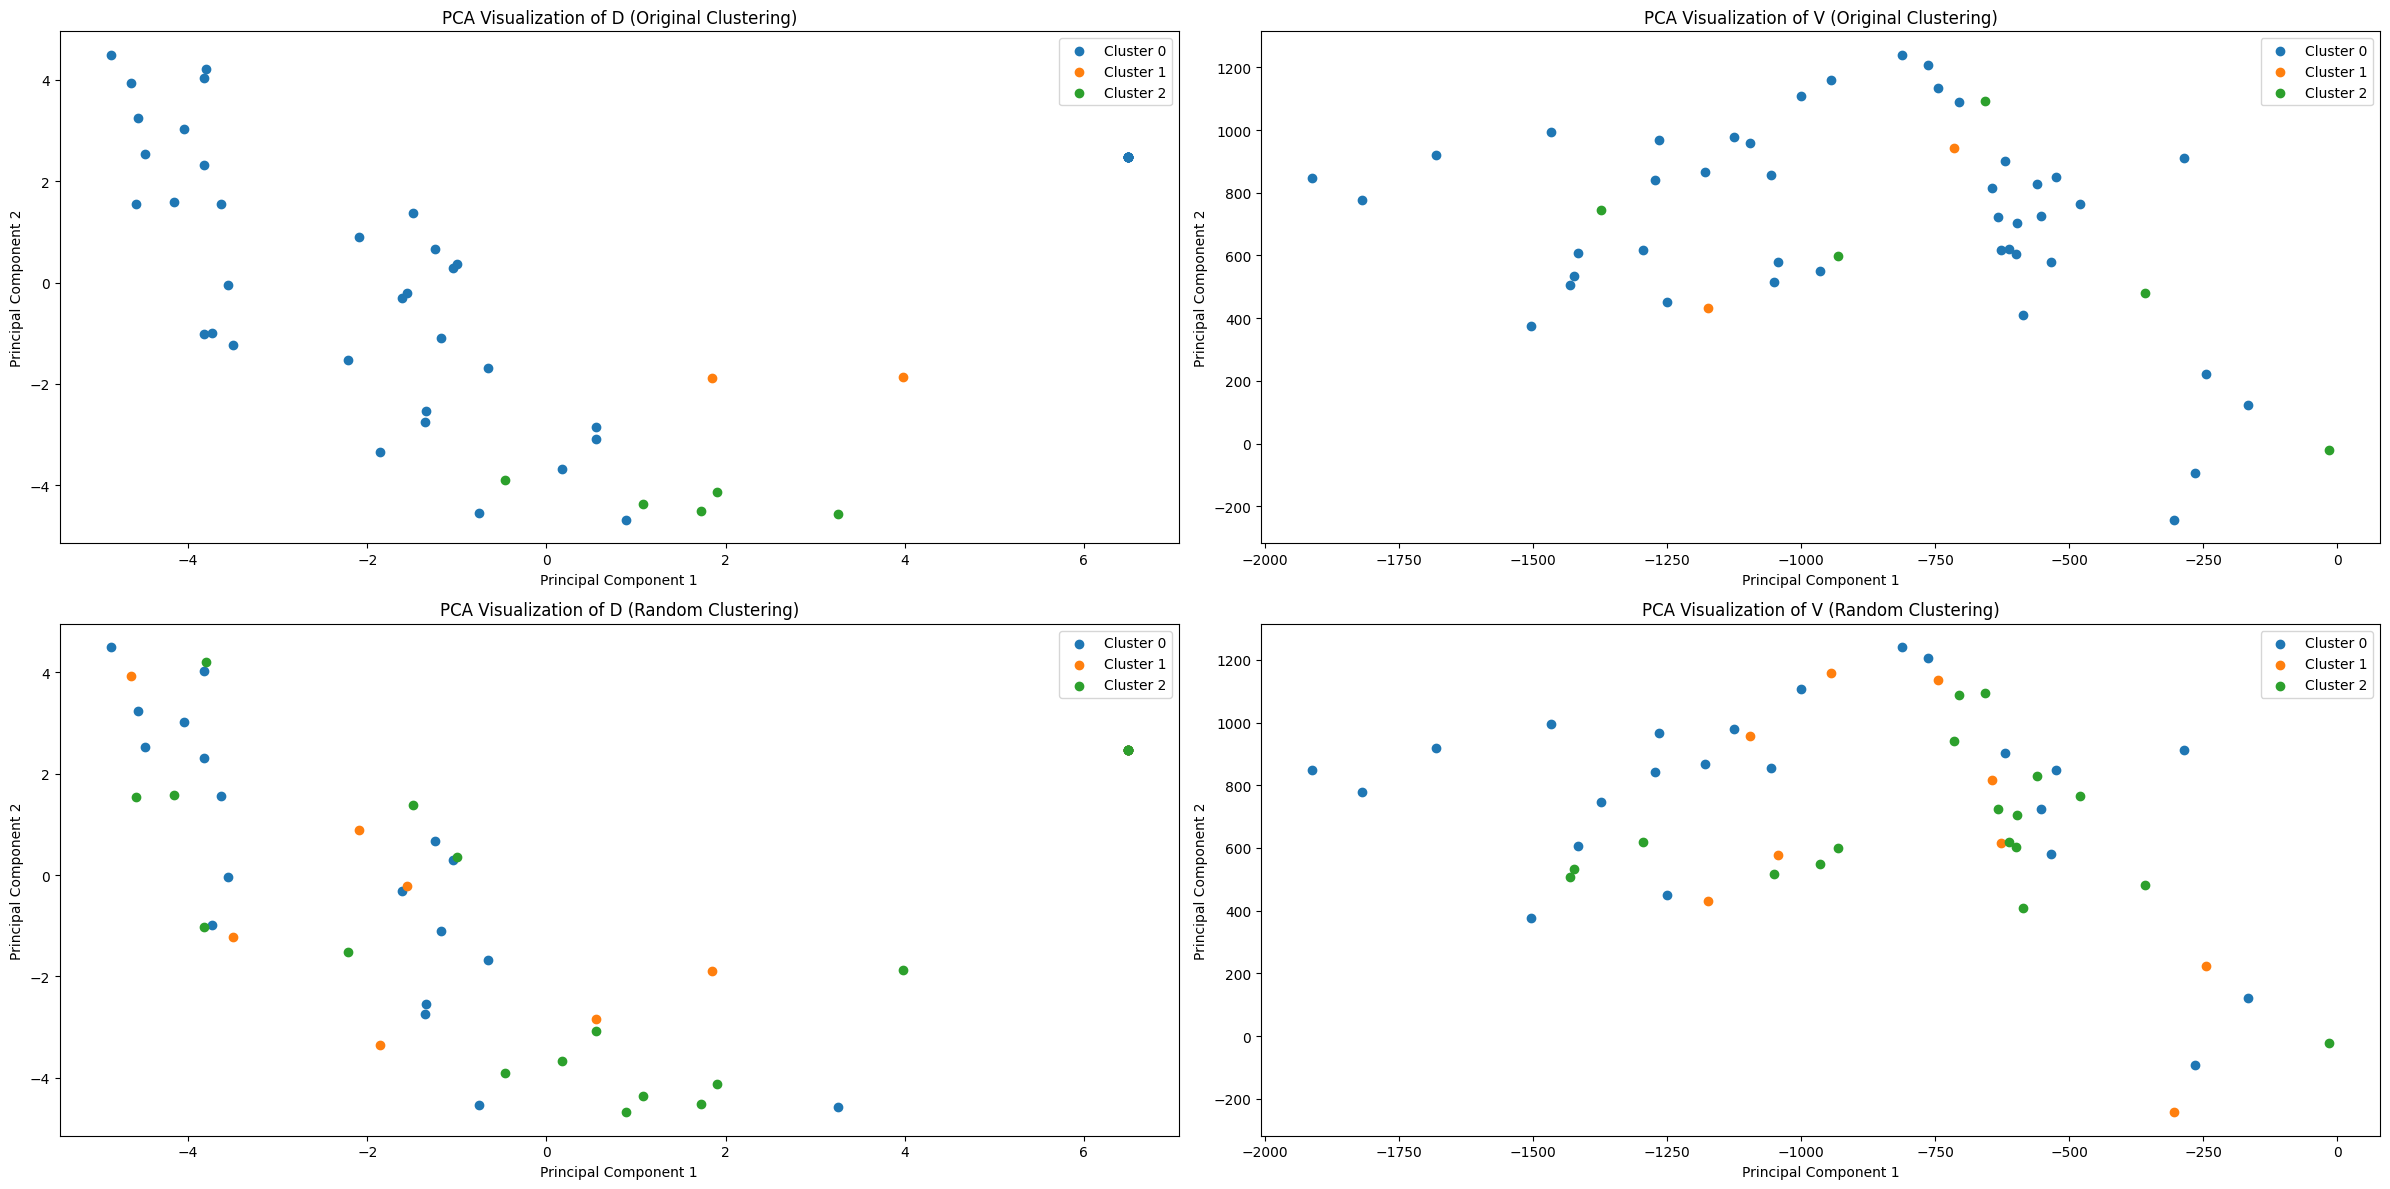

The silhouette score for D data (Original) is: 0.09894566771759679
The silhouette score for V data (Original) is: -0.06603391701314541
The silhouette score for D data (Random) is: -0.0401568845611242
The silhouette score for V data (Random) is: -0.05111857692077135


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


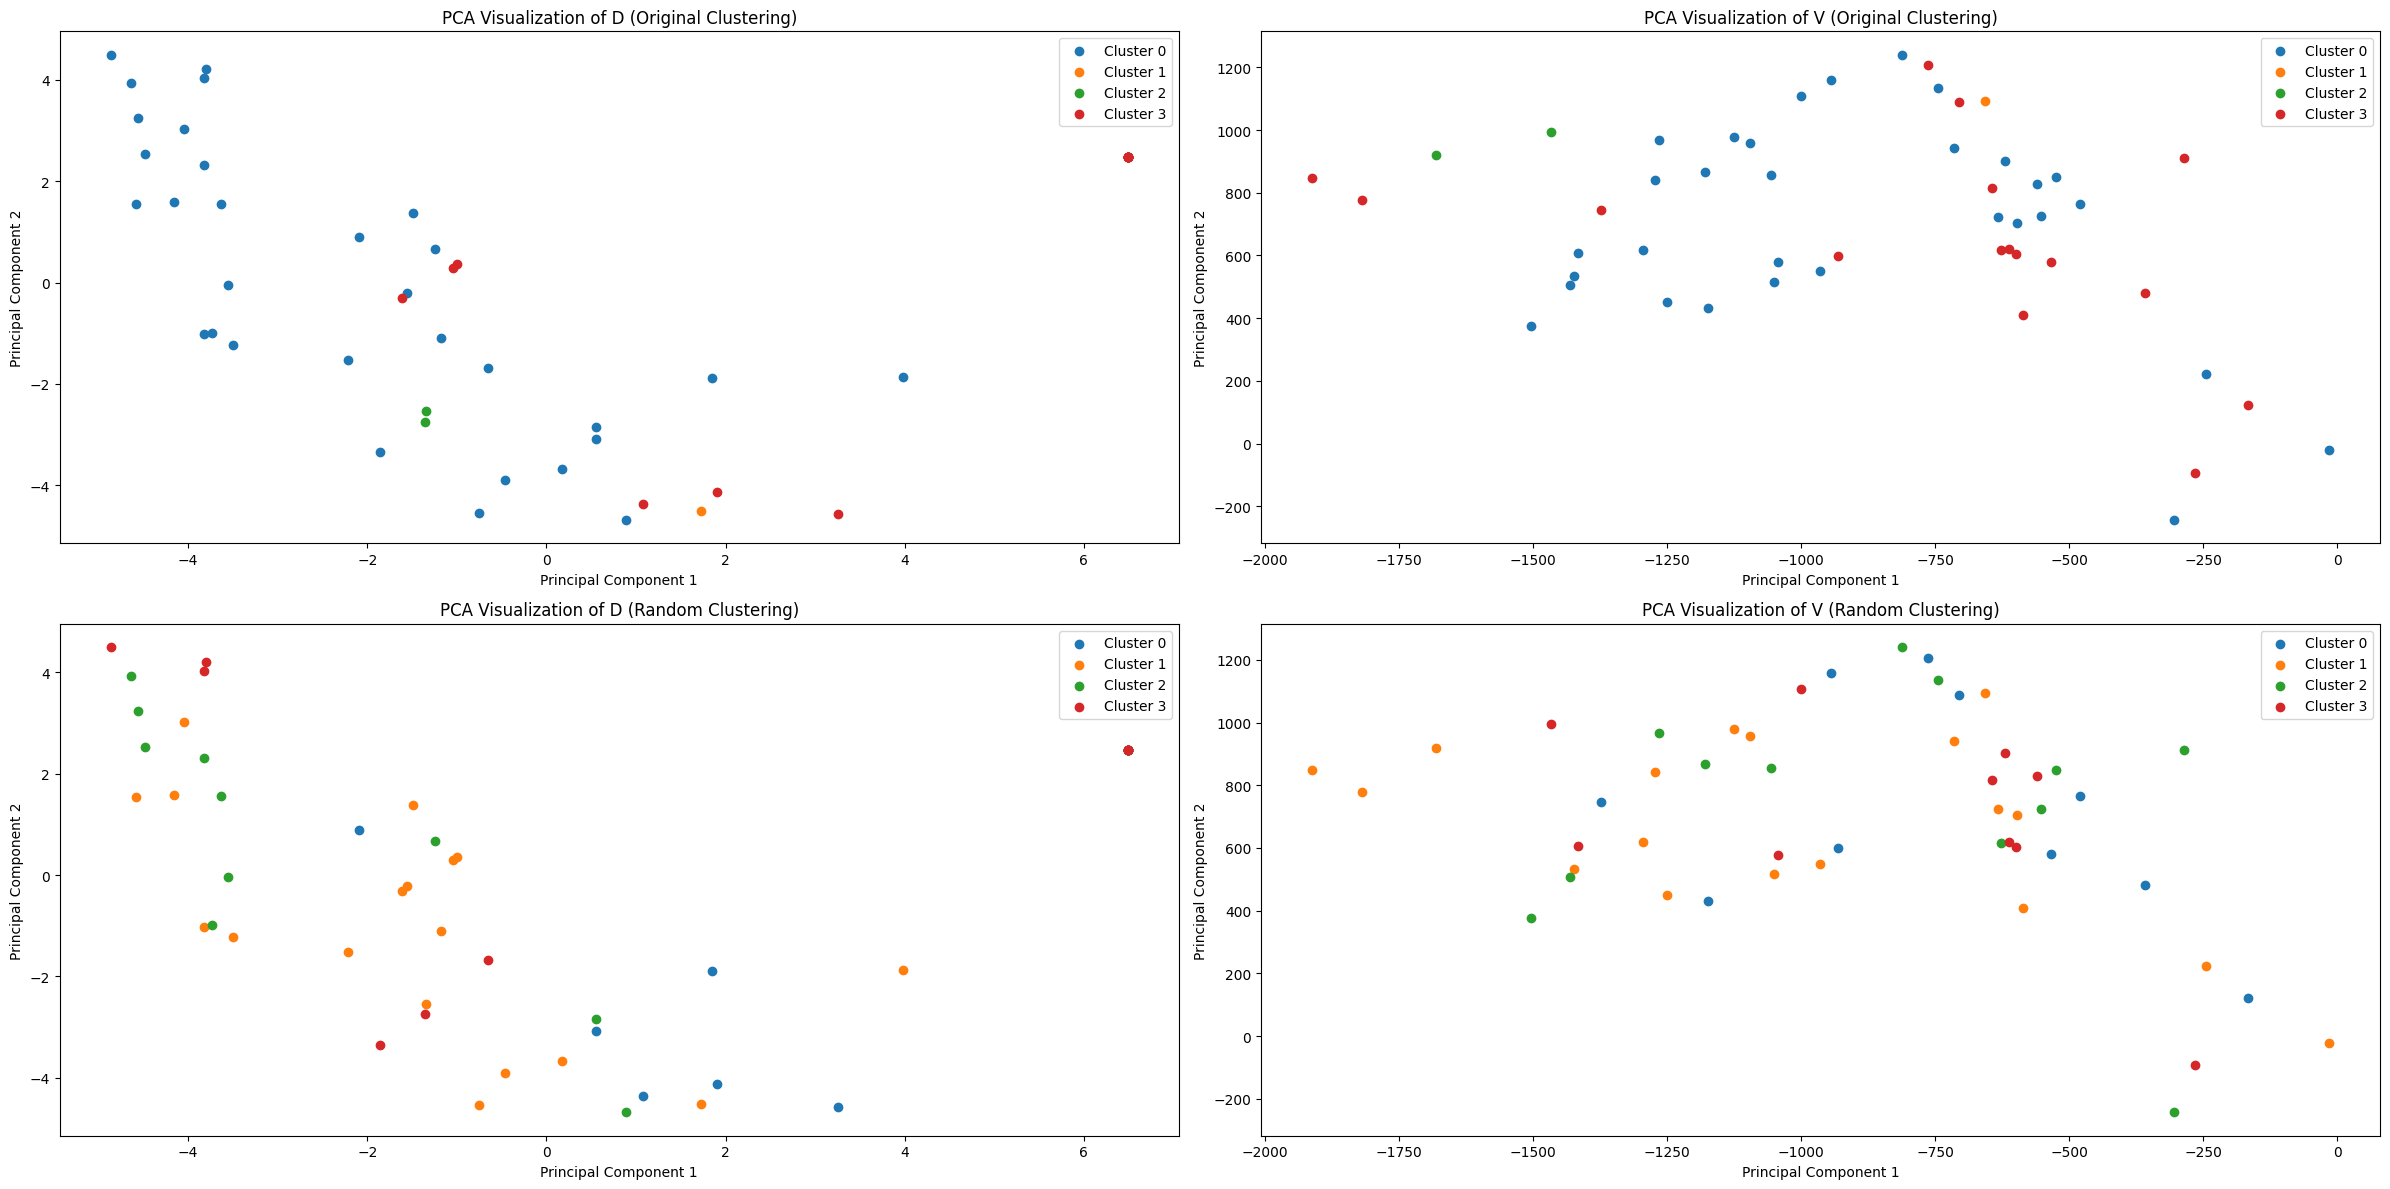

The silhouette score for D data (Original) is: 0.16070419254348547
The silhouette score for V data (Original) is: -0.17748496093105653
The silhouette score for D data (Random) is: -0.054270653876030674
The silhouette score for V data (Random) is: -0.05745155599070402


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


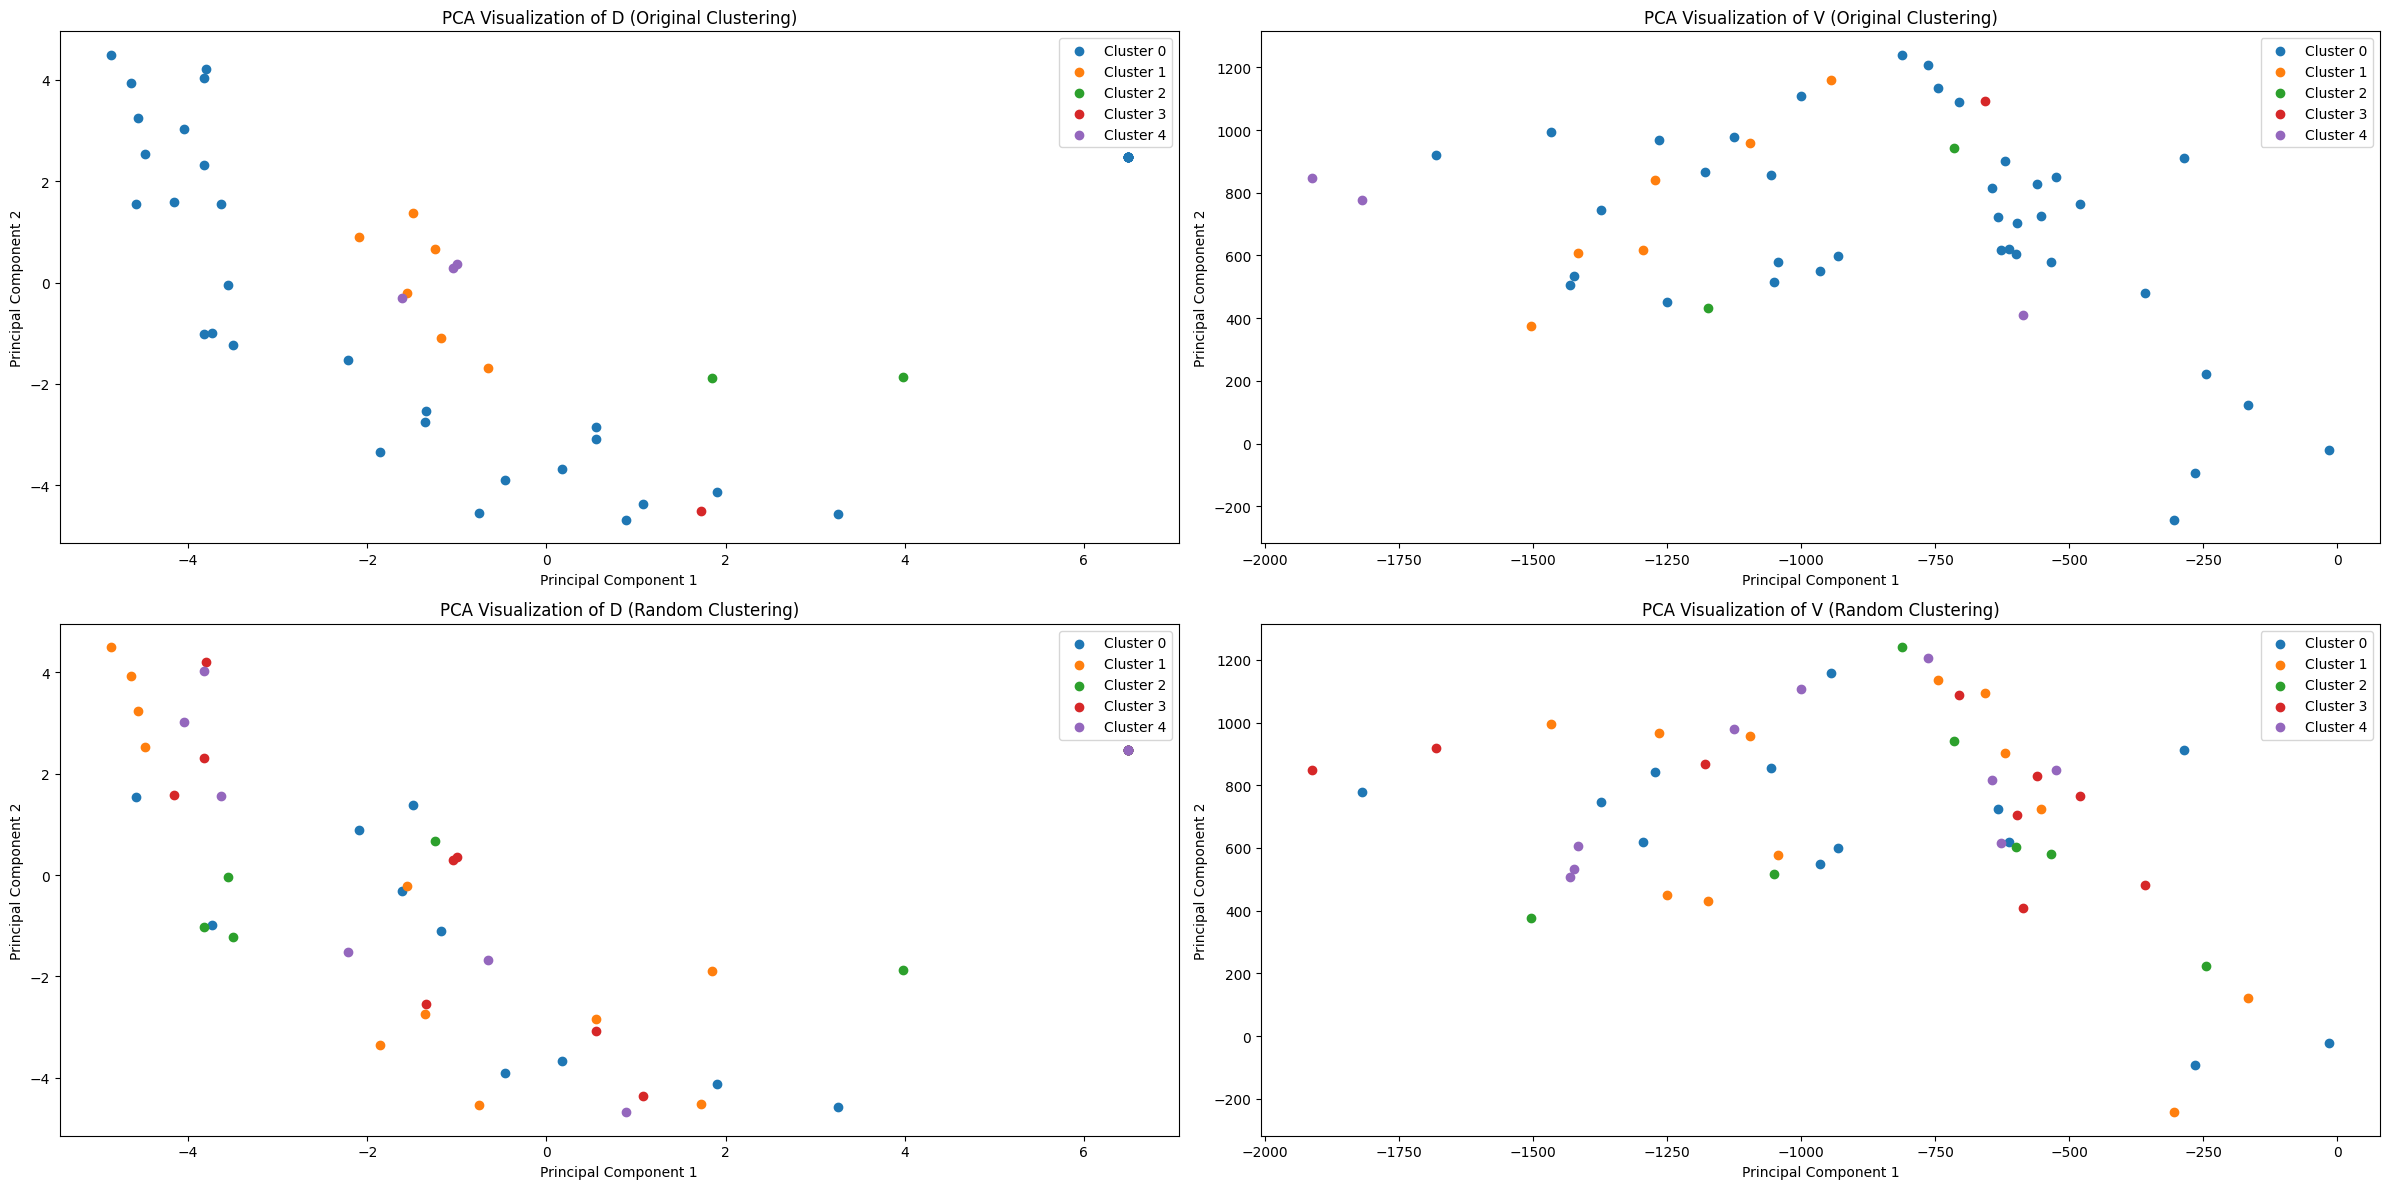

The silhouette score for D data (Original) is: 0.05402981734882715
The silhouette score for V data (Original) is: -0.2091916033269911
The silhouette score for D data (Random) is: -0.07970087738891019
The silhouette score for V data (Random) is: -0.06124497070247254


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


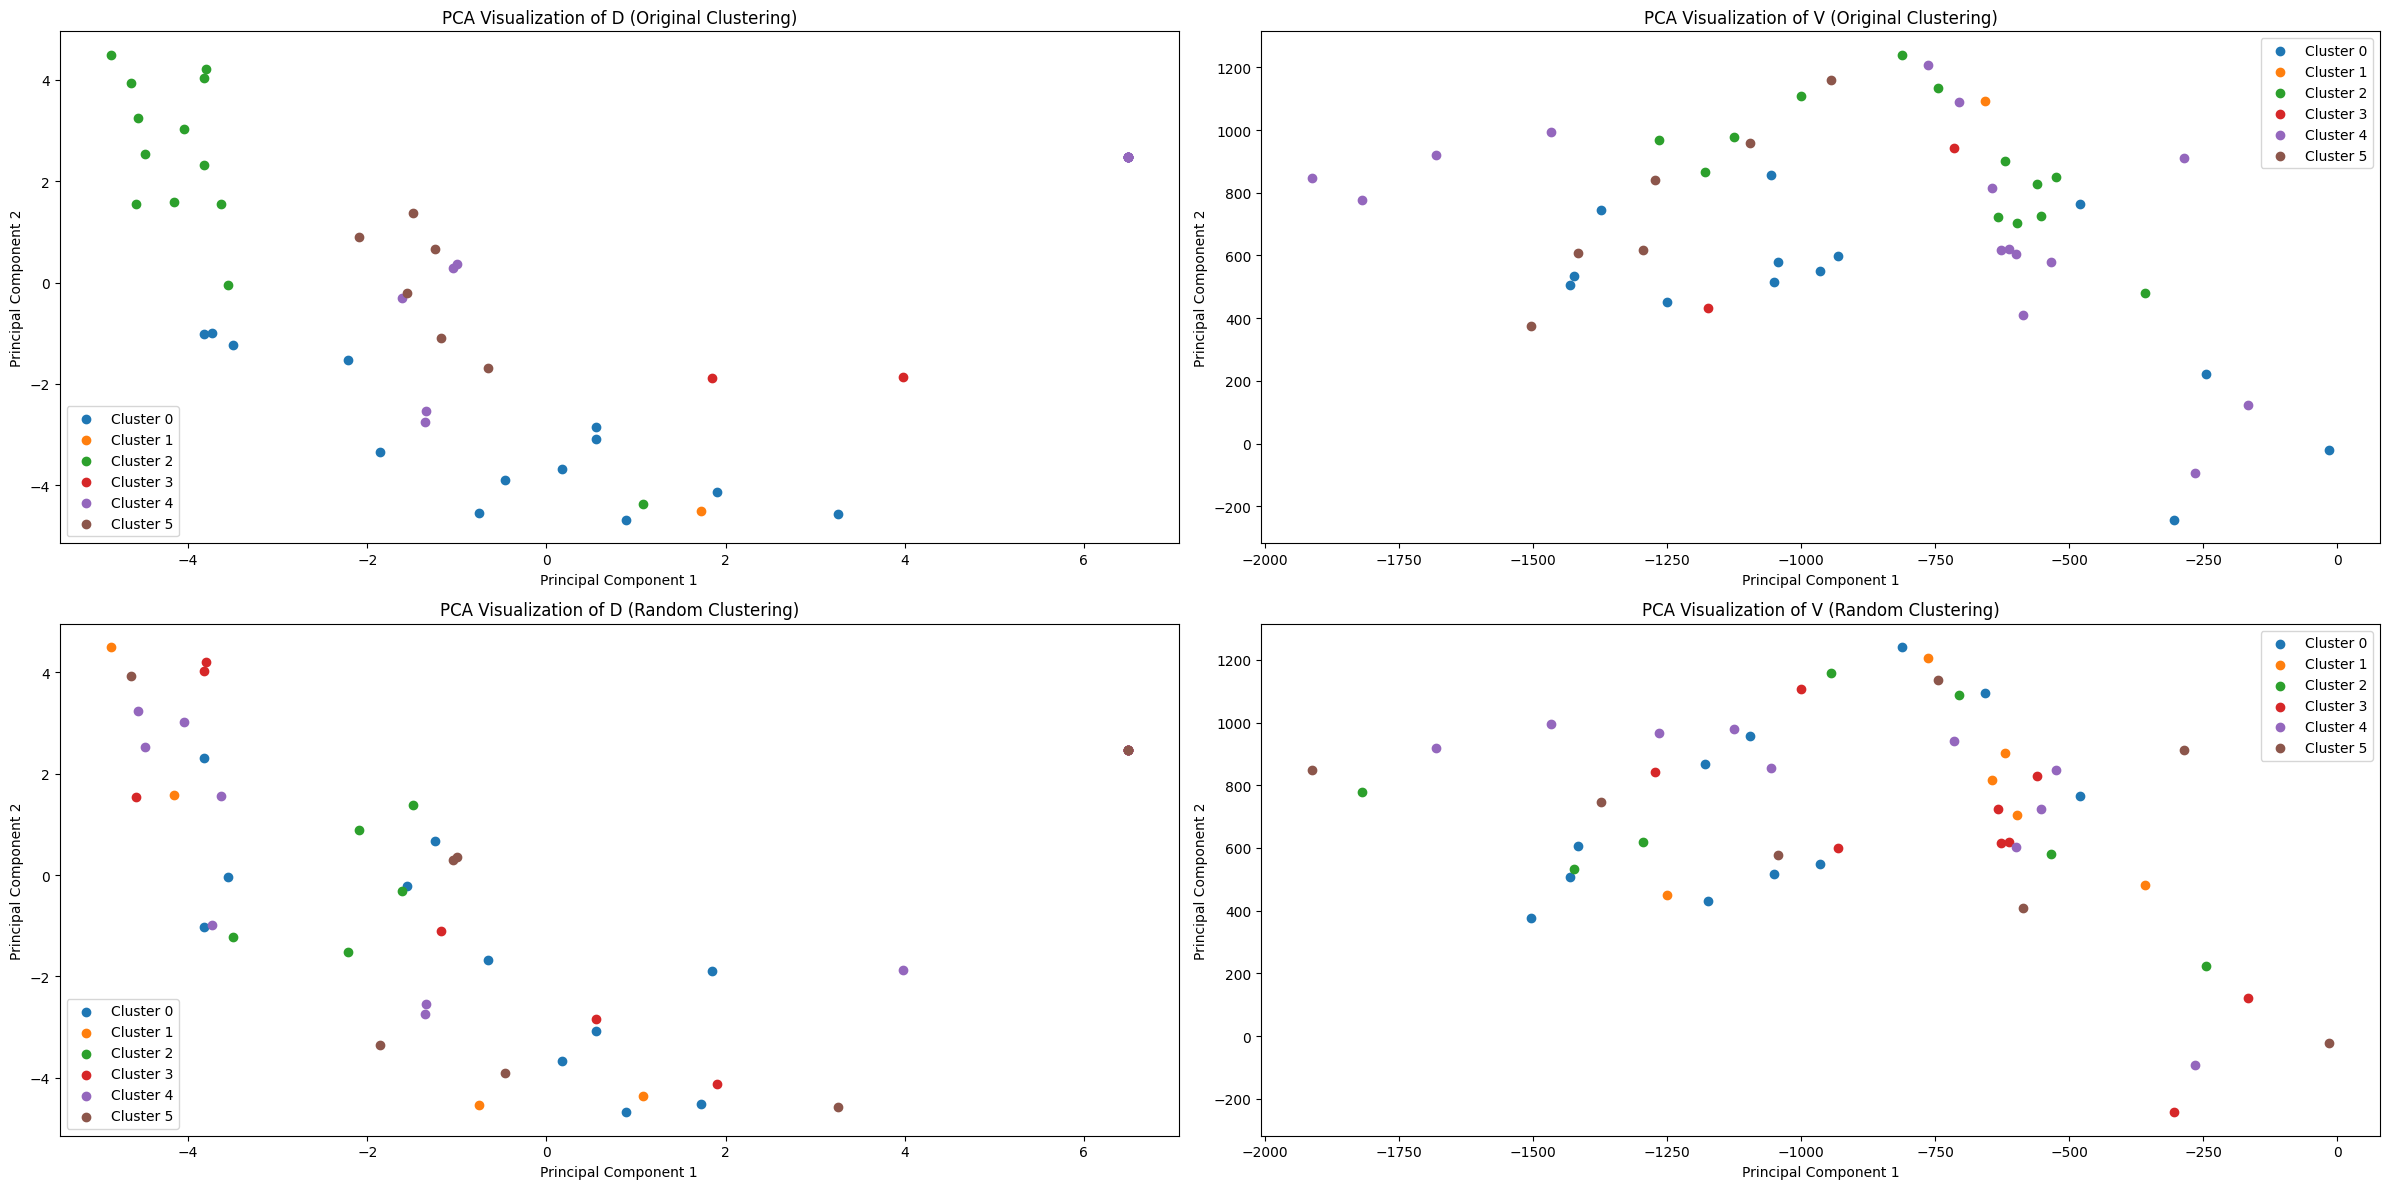

The silhouette score for D data (Original) is: 0.23544784408658118
The silhouette score for V data (Original) is: -0.18163105831254162
The silhouette score for D data (Random) is: -0.09178797248888093
The silhouette score for V data (Random) is: -0.11685376825841776


In [44]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 6, method='SpectralClustering')

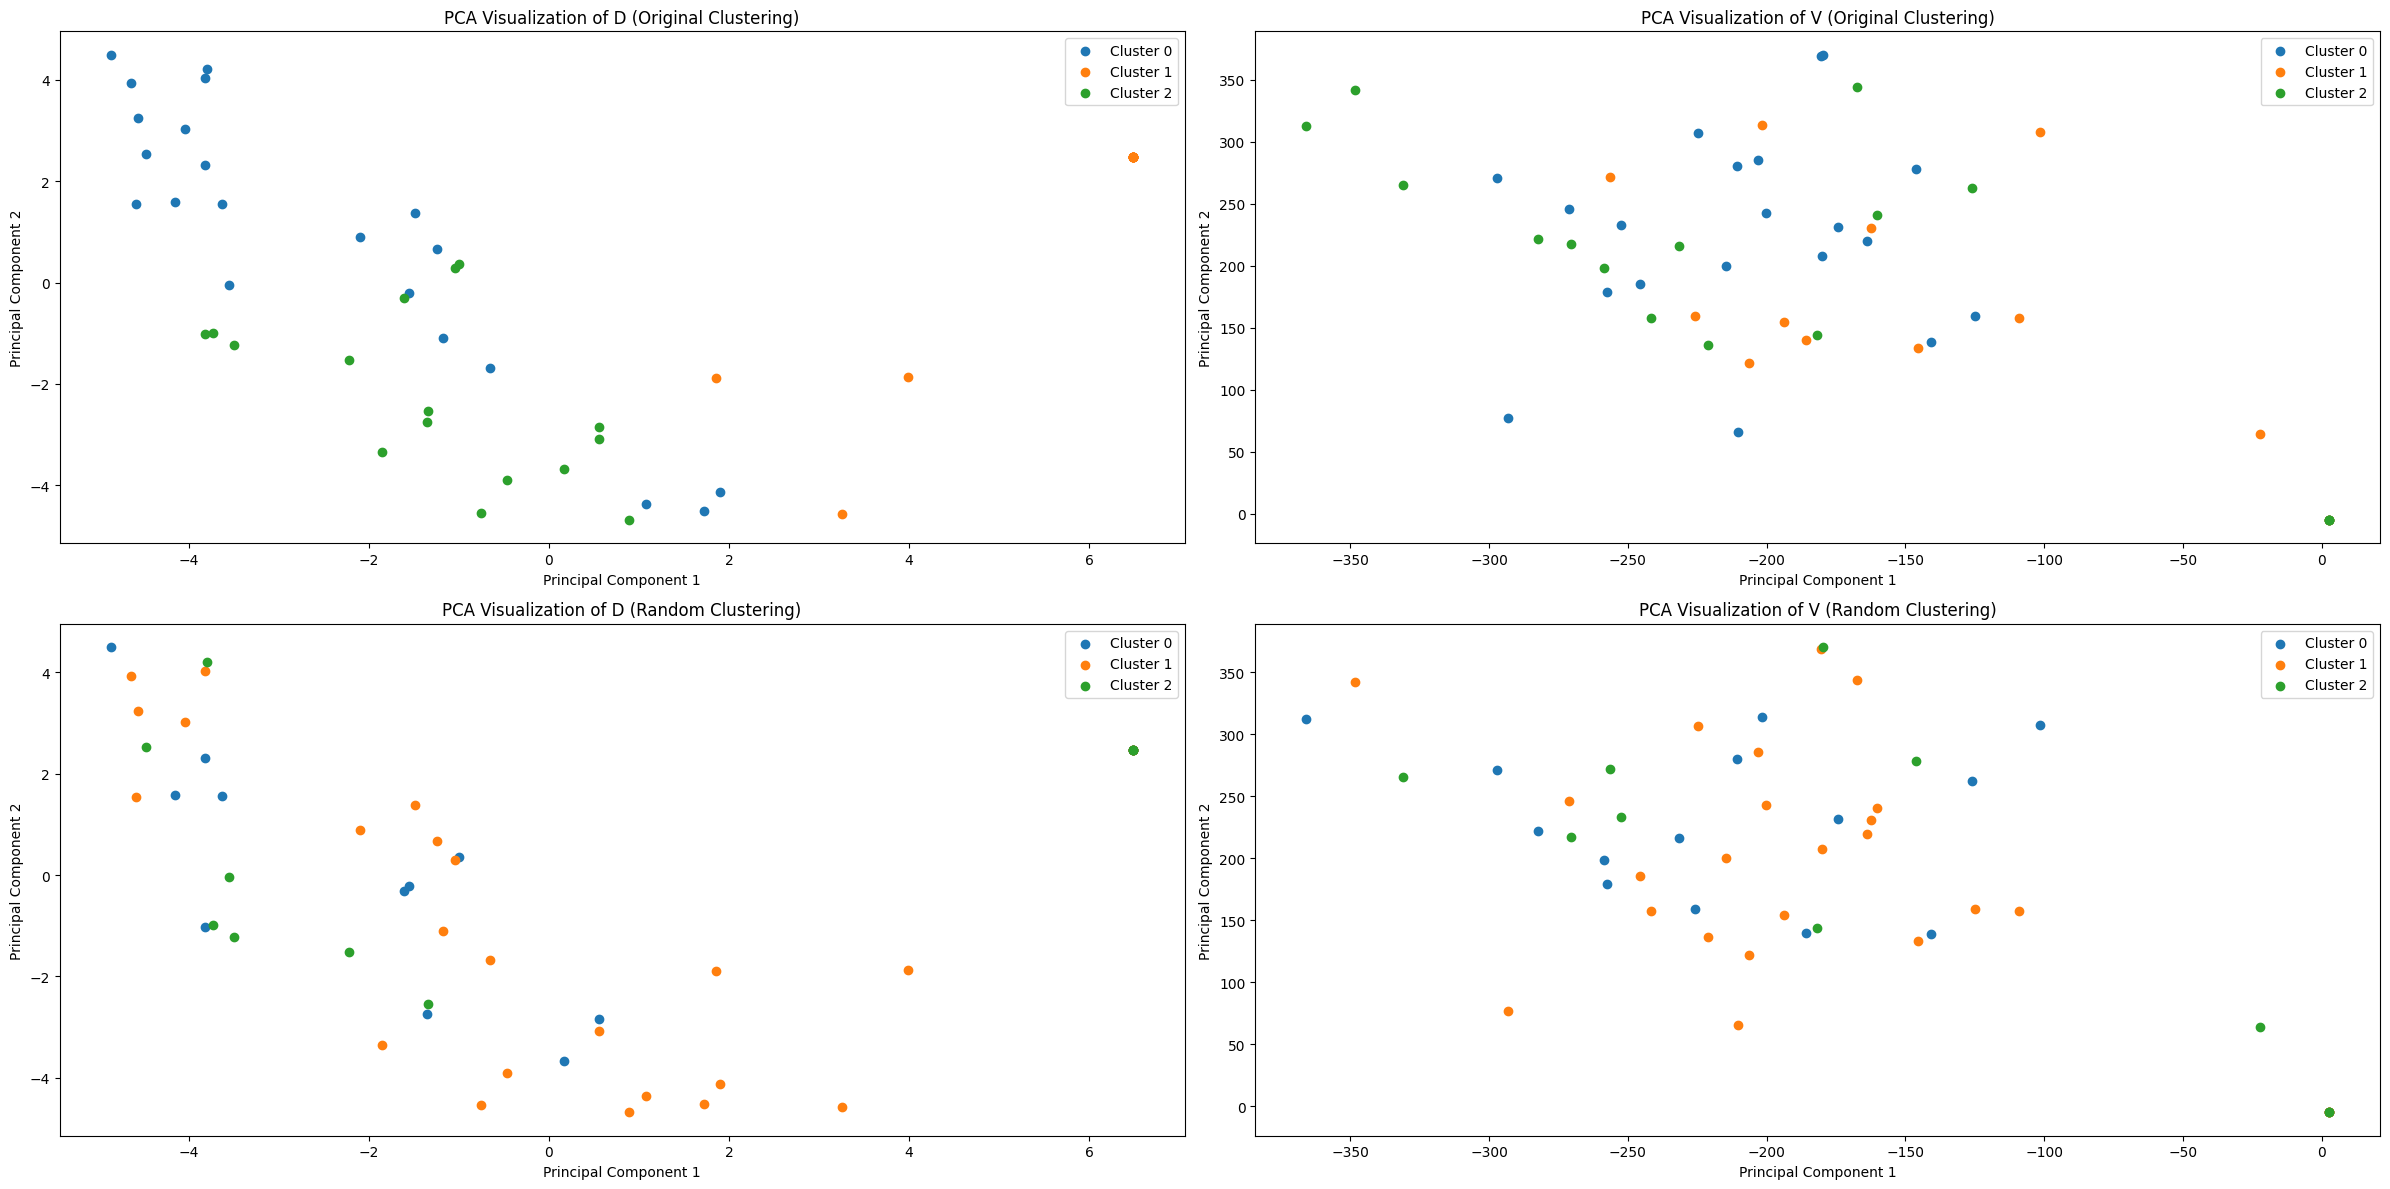

The silhouette score for D data (Original) is: 0.27343912346199784
The silhouette score for V data (Original) is: -0.024301368351392422
The silhouette score for D data (Random) is: -0.05286145246907589
The silhouette score for V data (Random) is: -0.02371082365900169


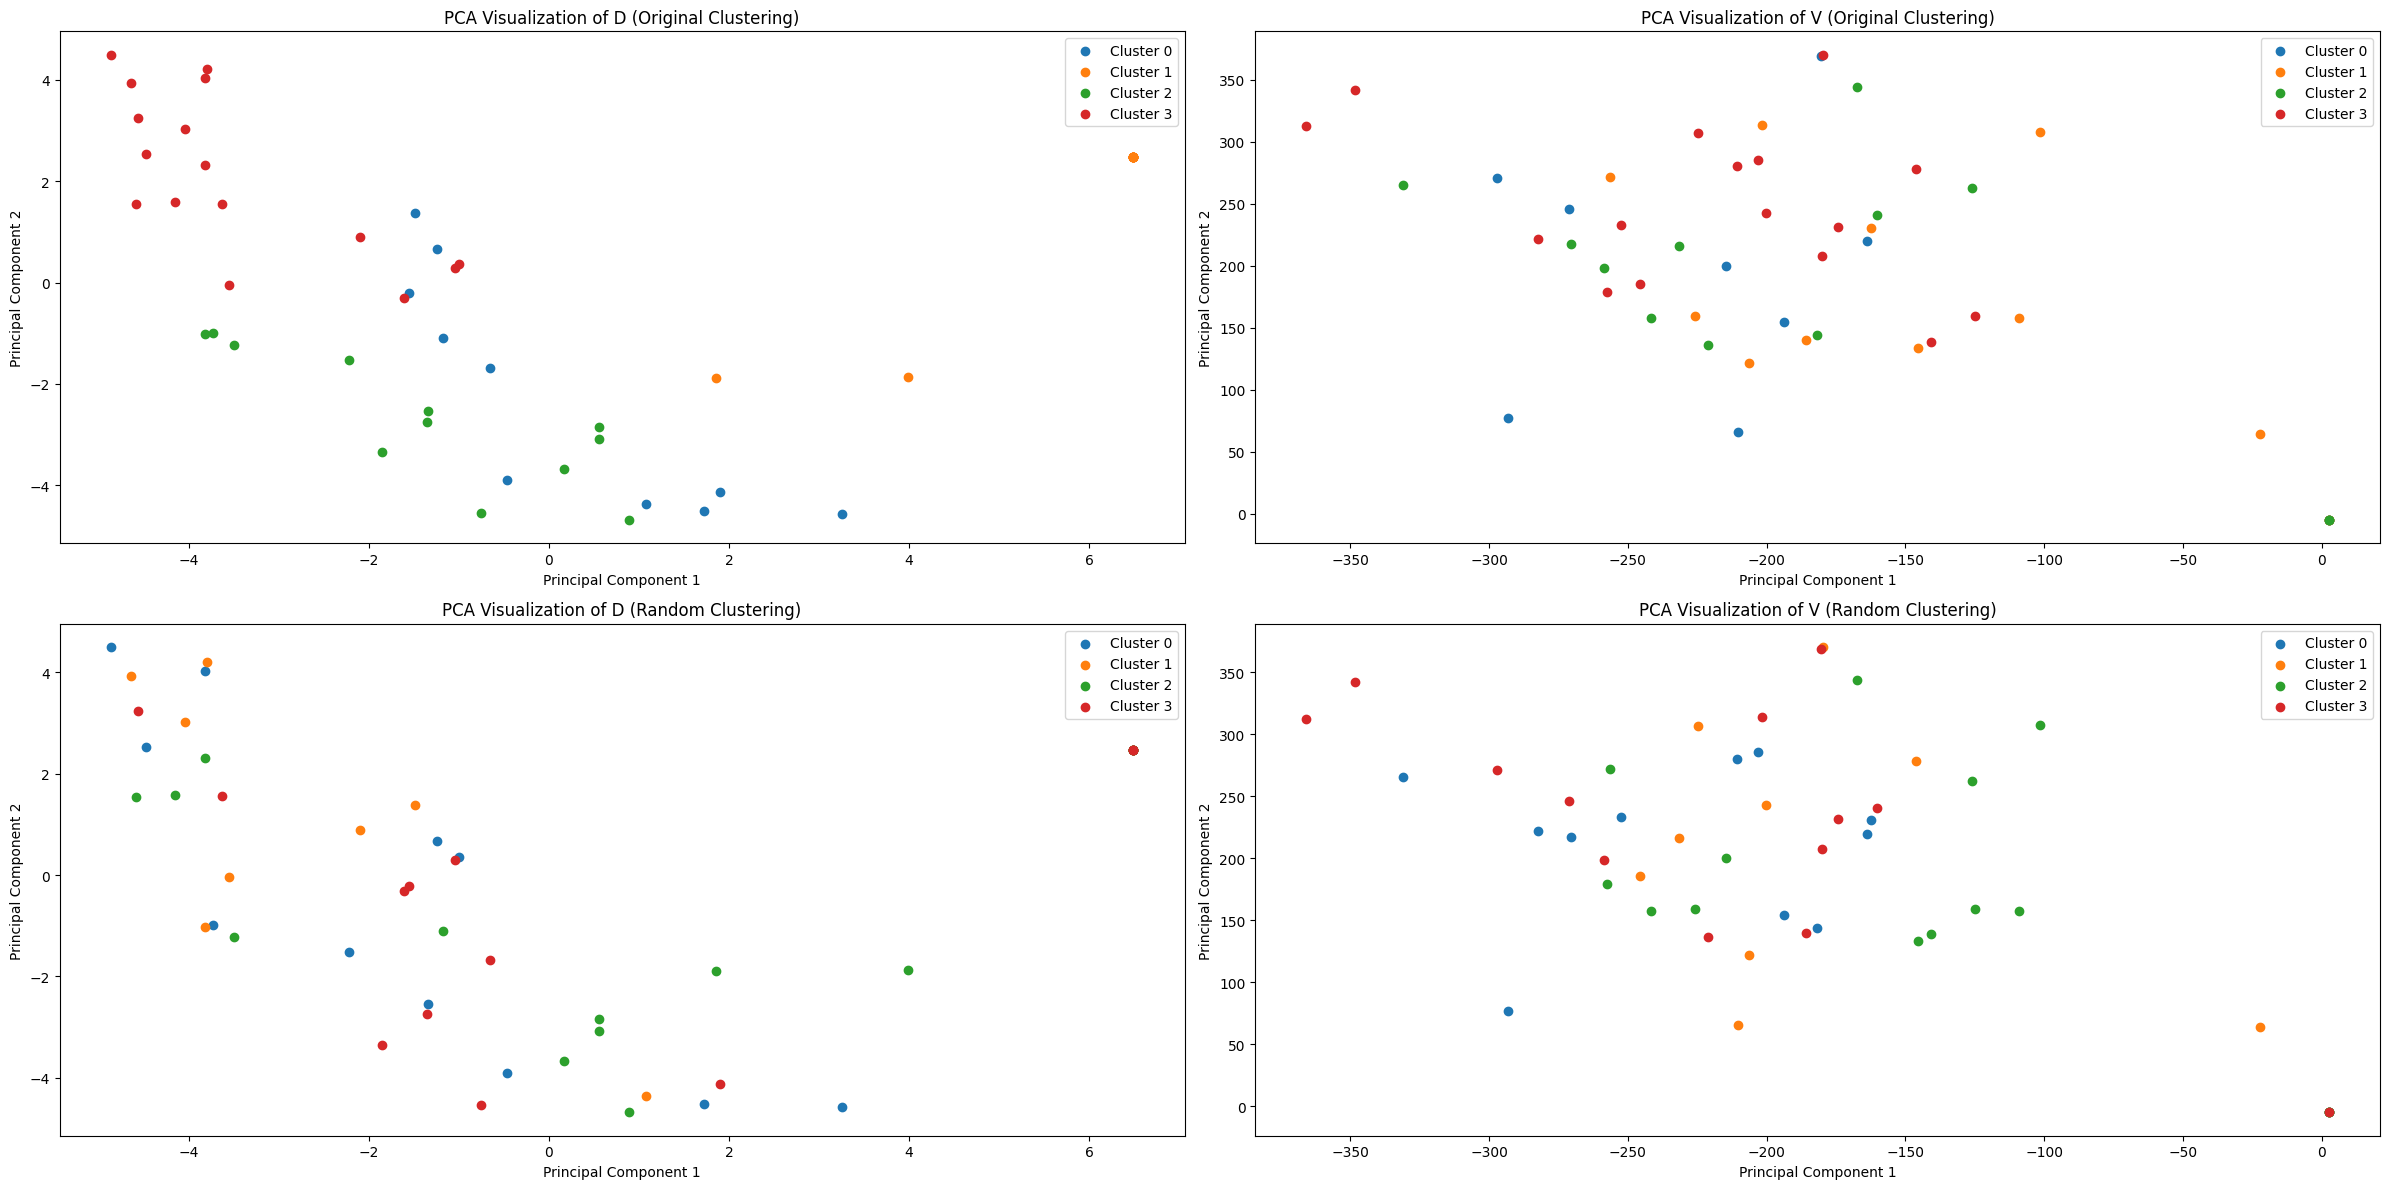

The silhouette score for D data (Original) is: 0.3203752068939478
The silhouette score for V data (Original) is: -0.036985969946301336
The silhouette score for D data (Random) is: -0.06070818017726697
The silhouette score for V data (Random) is: -0.05314884687523171


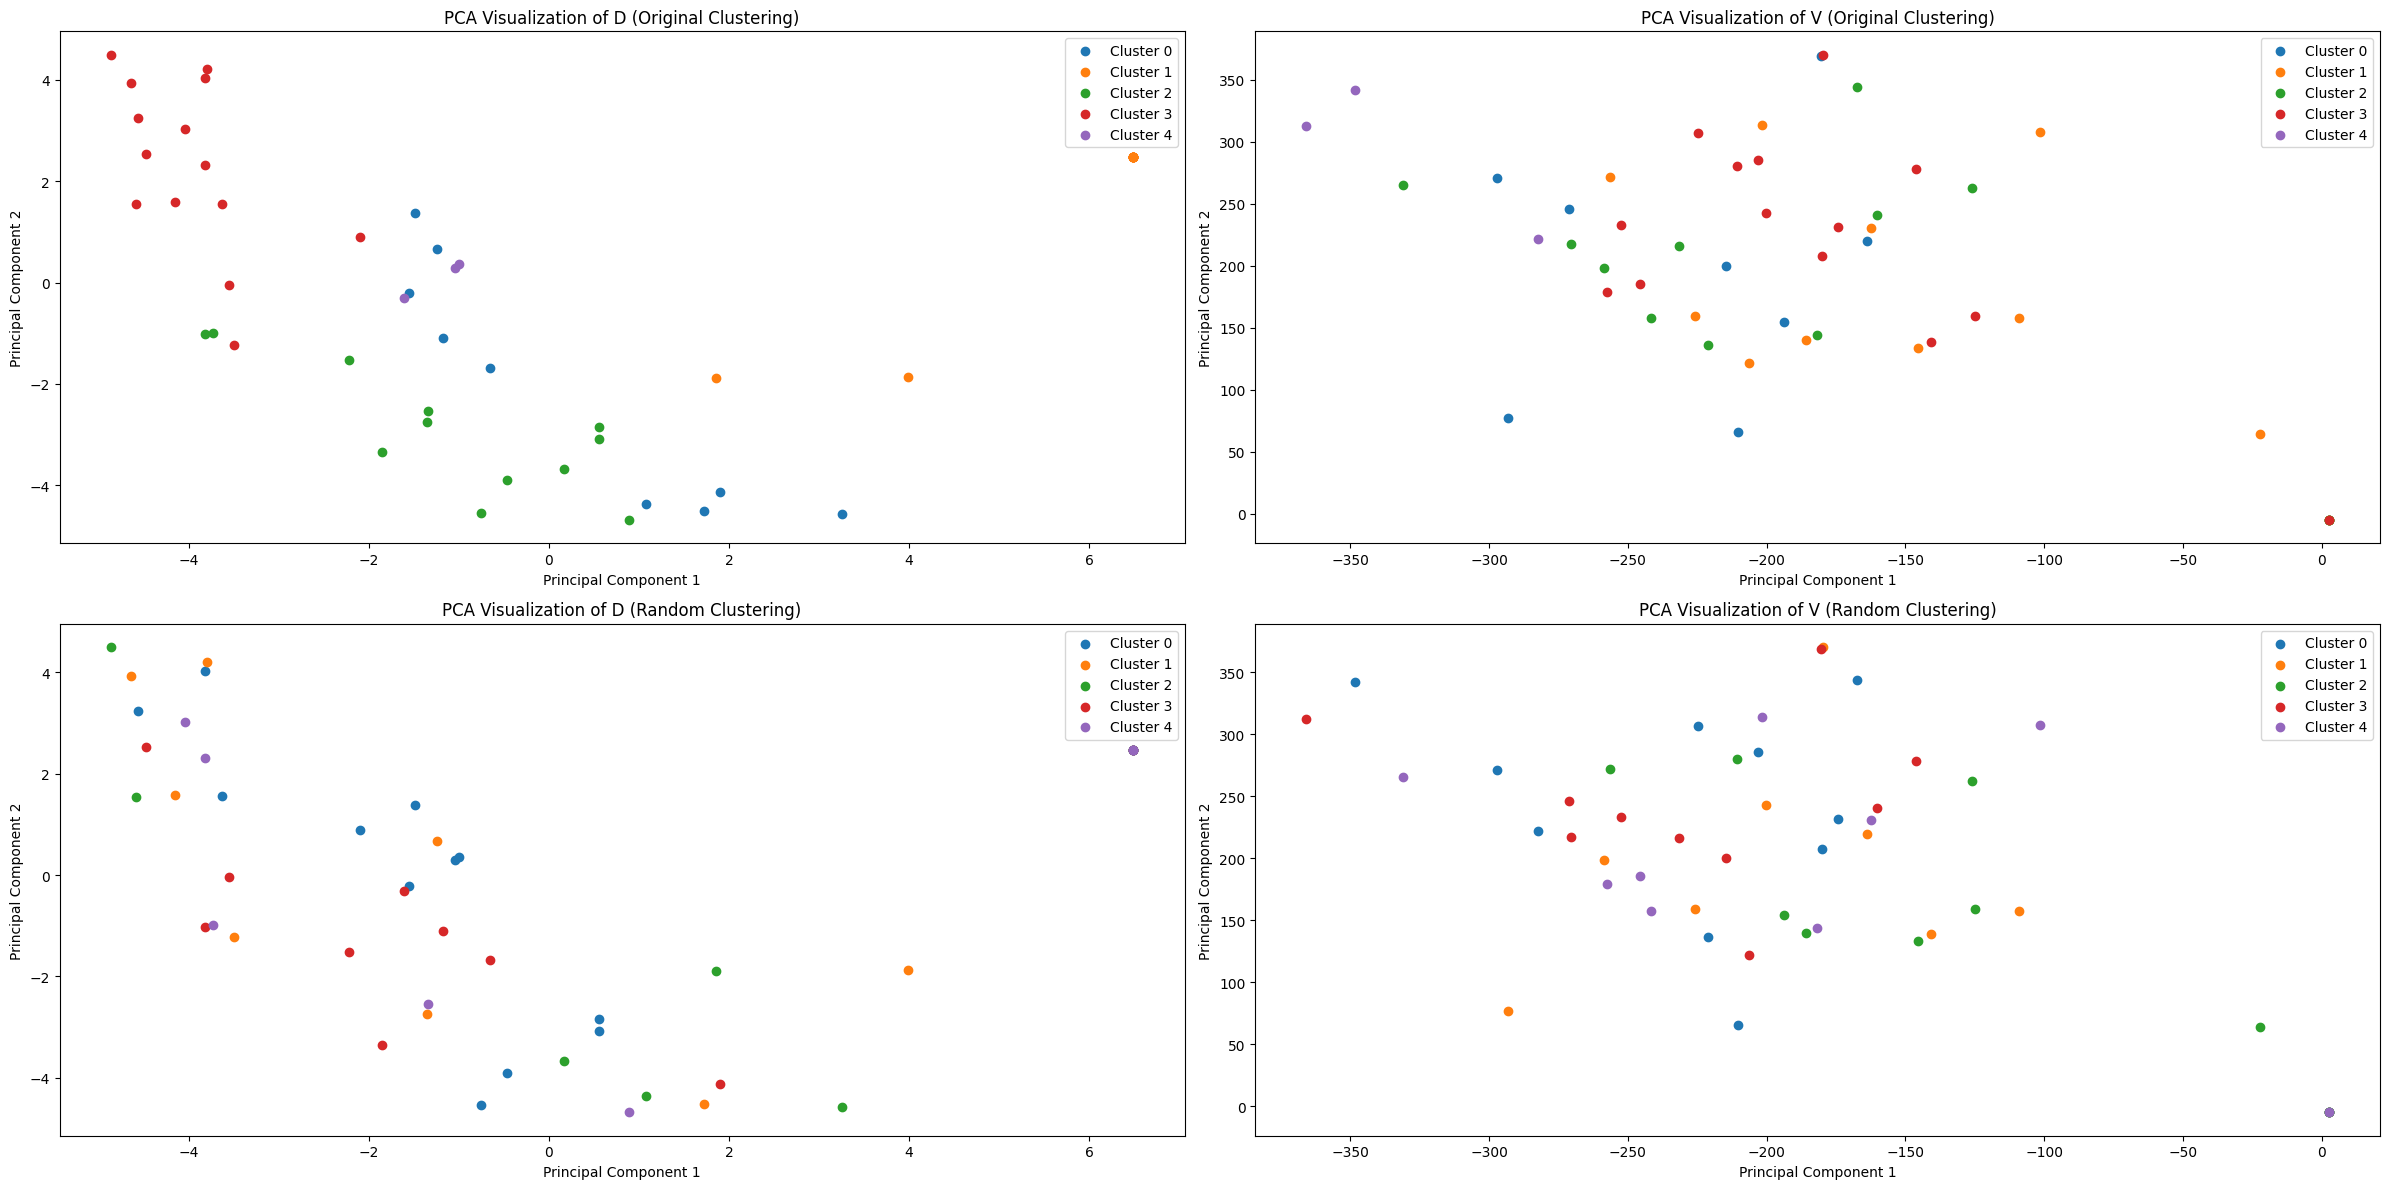

The silhouette score for D data (Original) is: 0.3399109489774598
The silhouette score for V data (Original) is: -0.046015109964091166
The silhouette score for D data (Random) is: -0.0746957375141979
The silhouette score for V data (Random) is: -0.05634366910379009


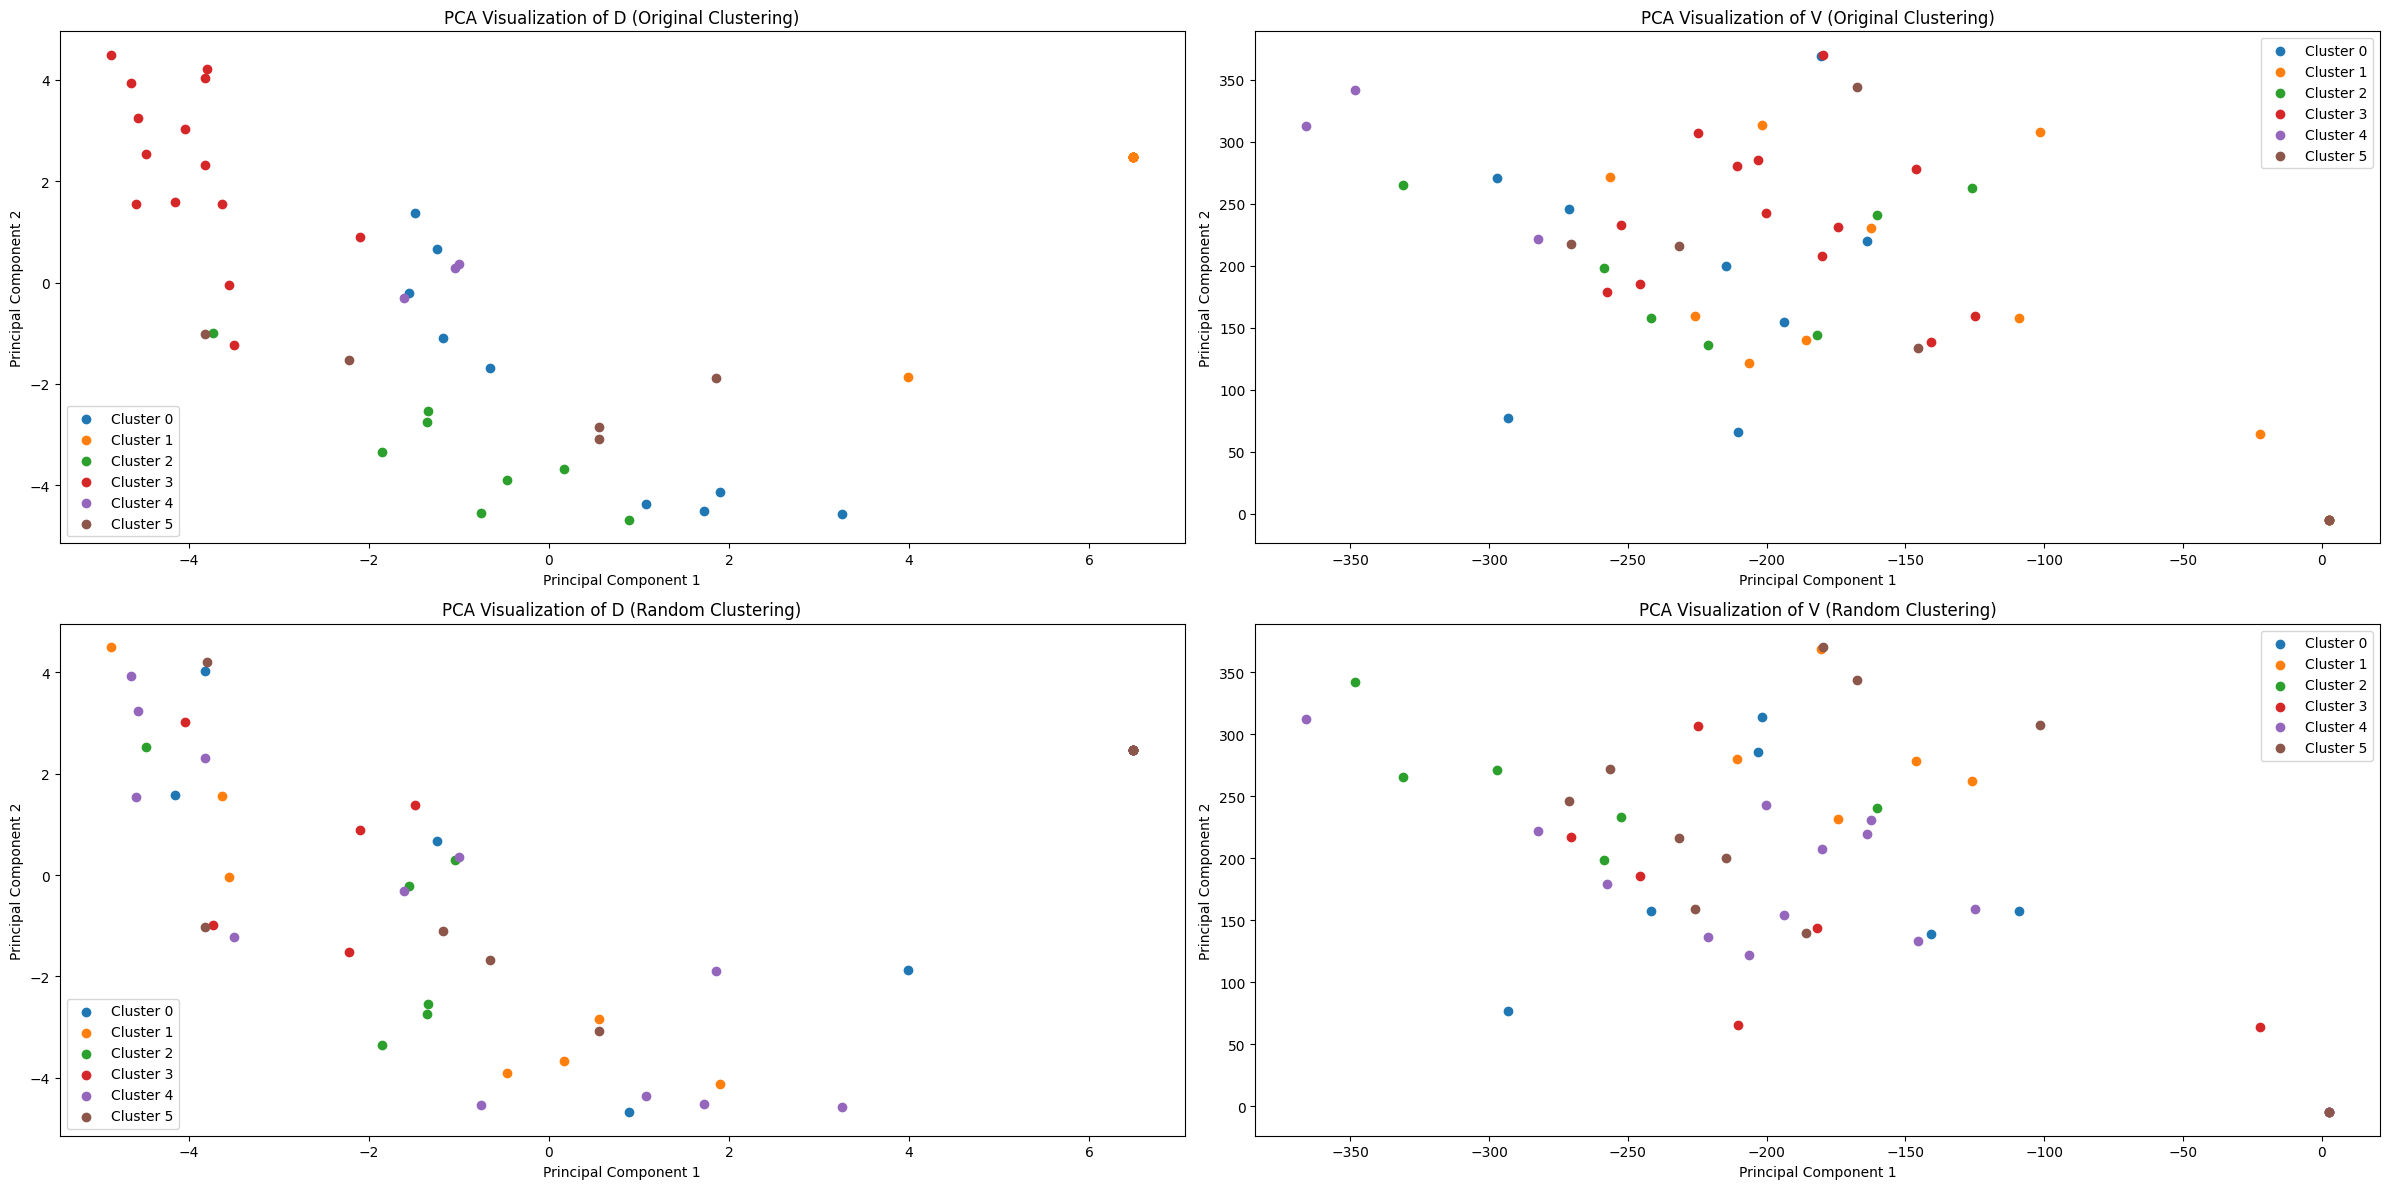

The silhouette score for D data (Original) is: 0.3177506662858891
The silhouette score for V data (Original) is: -0.06970794899617334
The silhouette score for D data (Random) is: -0.08917382180969254
The silhouette score for V data (Random) is: -0.07607432371773869


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


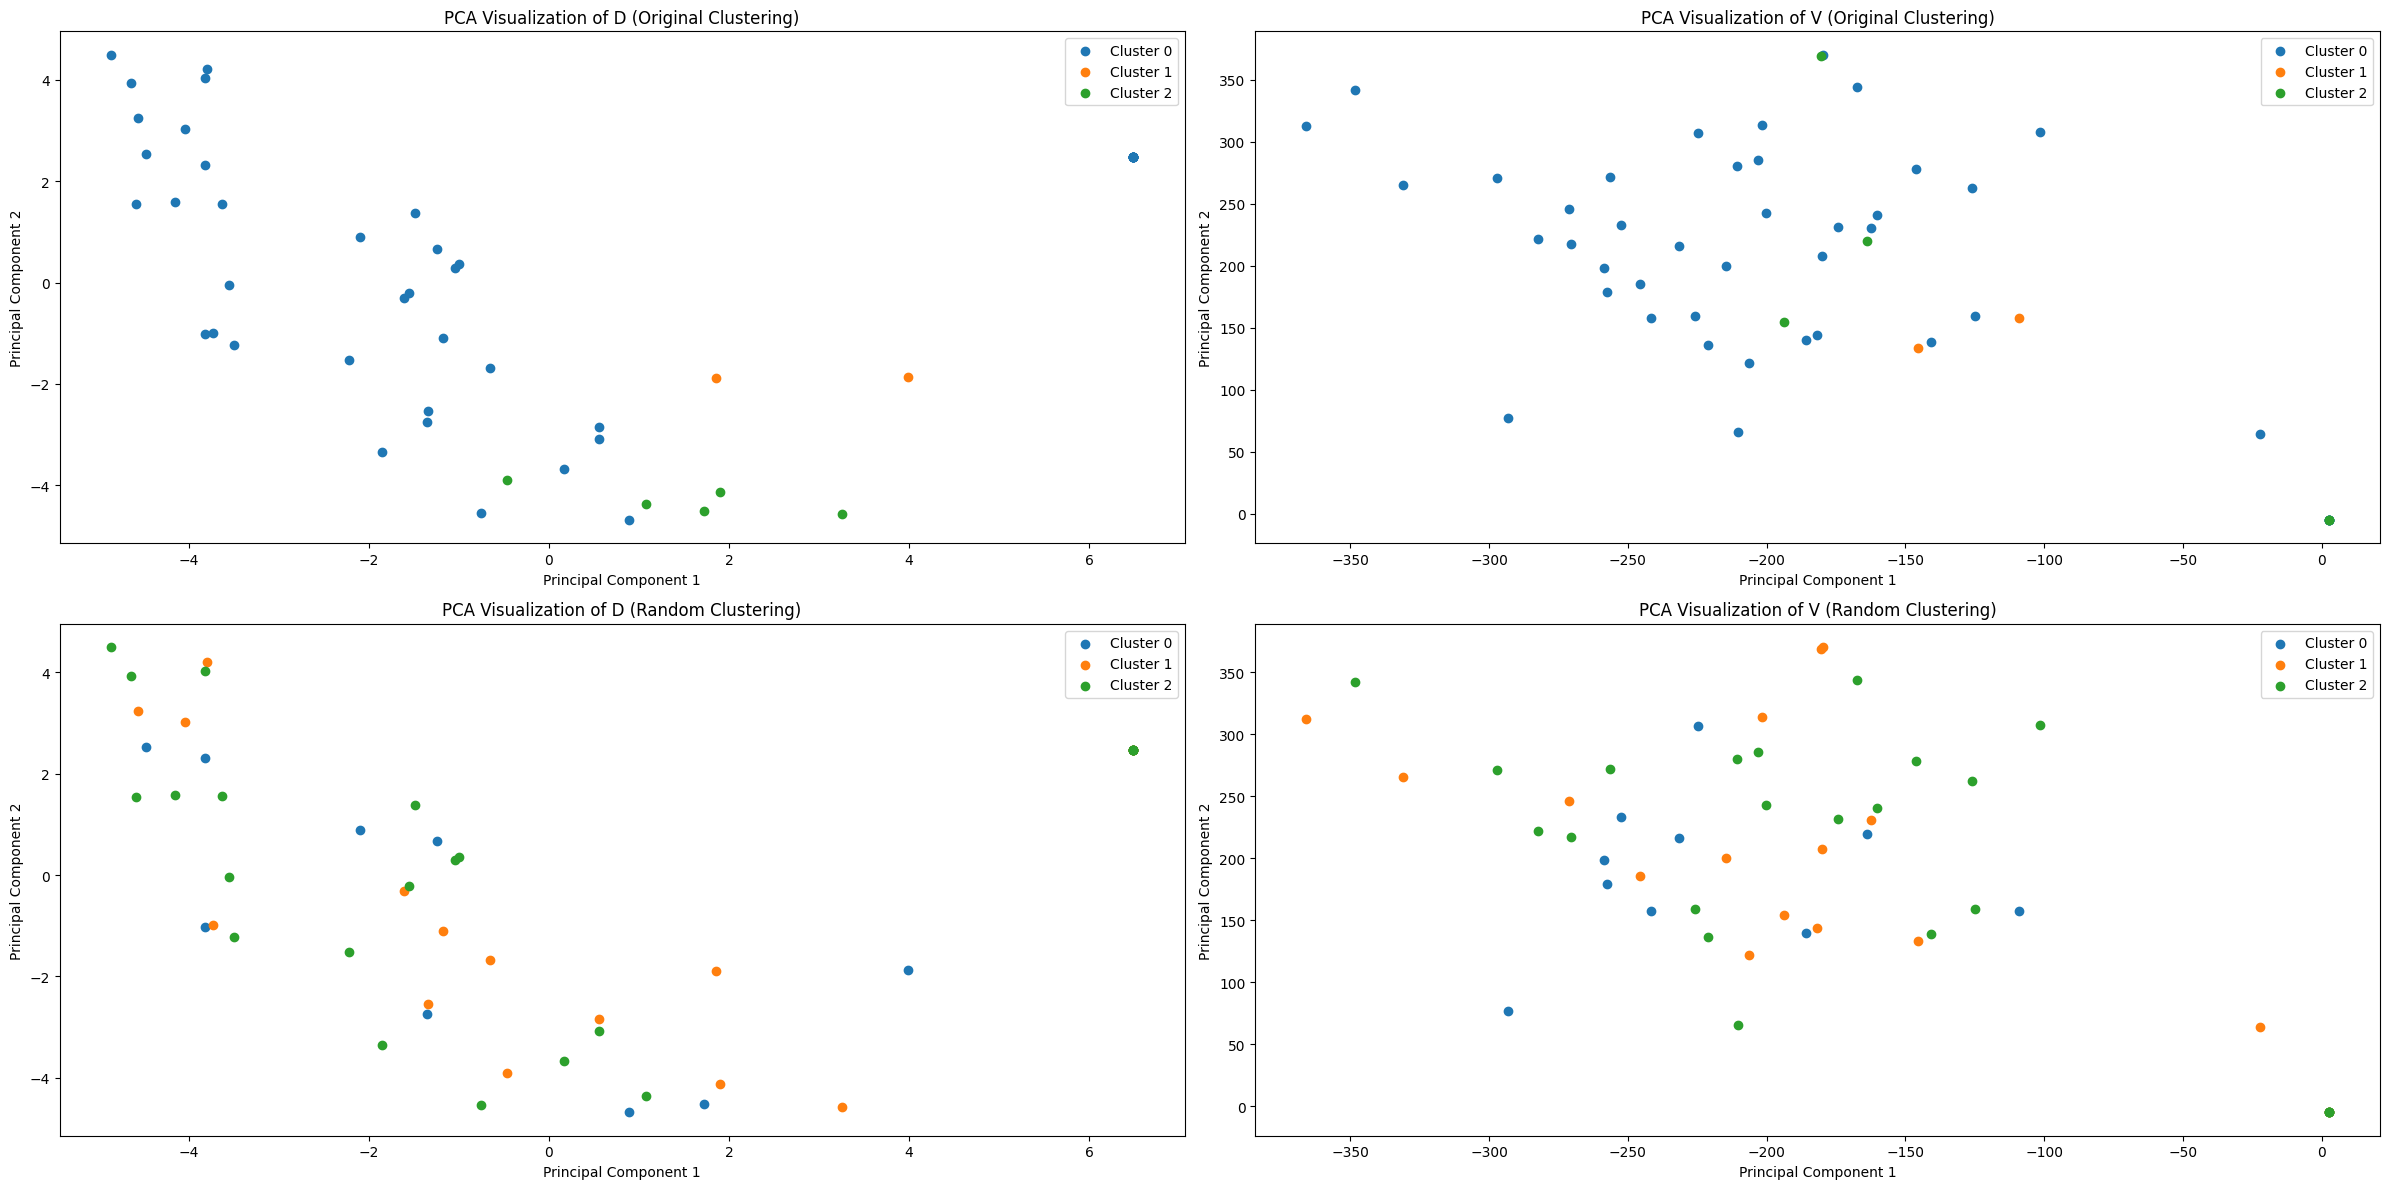

The silhouette score for D data (Original) is: 0.09894566771759679
The silhouette score for V data (Original) is: -0.10933257568141093
The silhouette score for D data (Random) is: -0.03440463310823902
The silhouette score for V data (Random) is: -0.024528267613806644


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


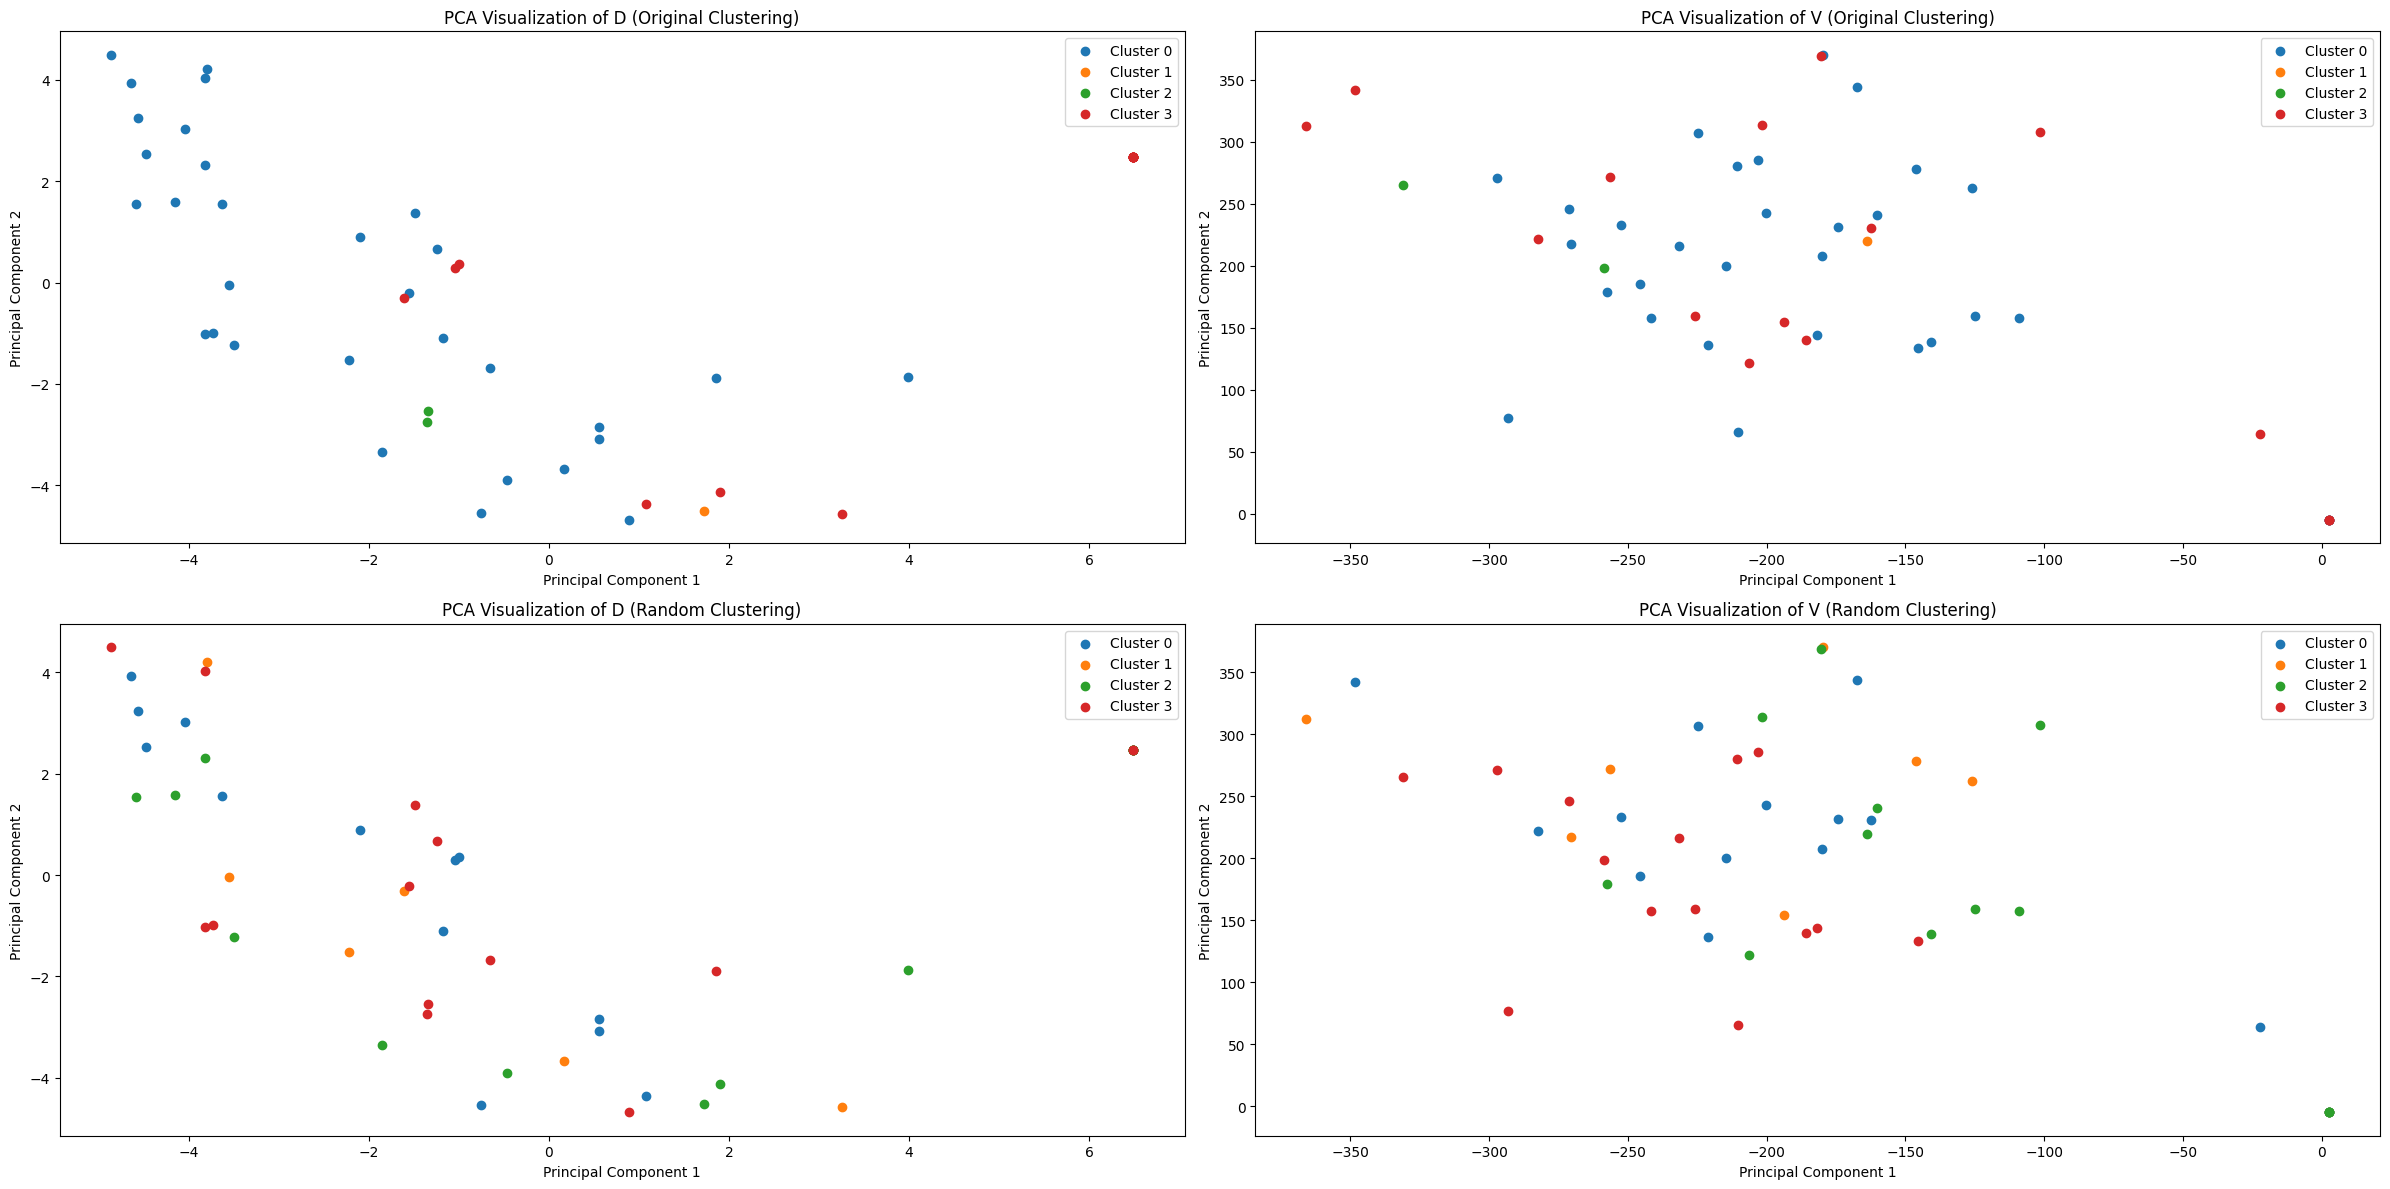

The silhouette score for D data (Original) is: 0.16070419254348547
The silhouette score for V data (Original) is: -0.16311001806429407
The silhouette score for D data (Random) is: -0.06282105425418981
The silhouette score for V data (Random) is: -0.02642299892161712


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


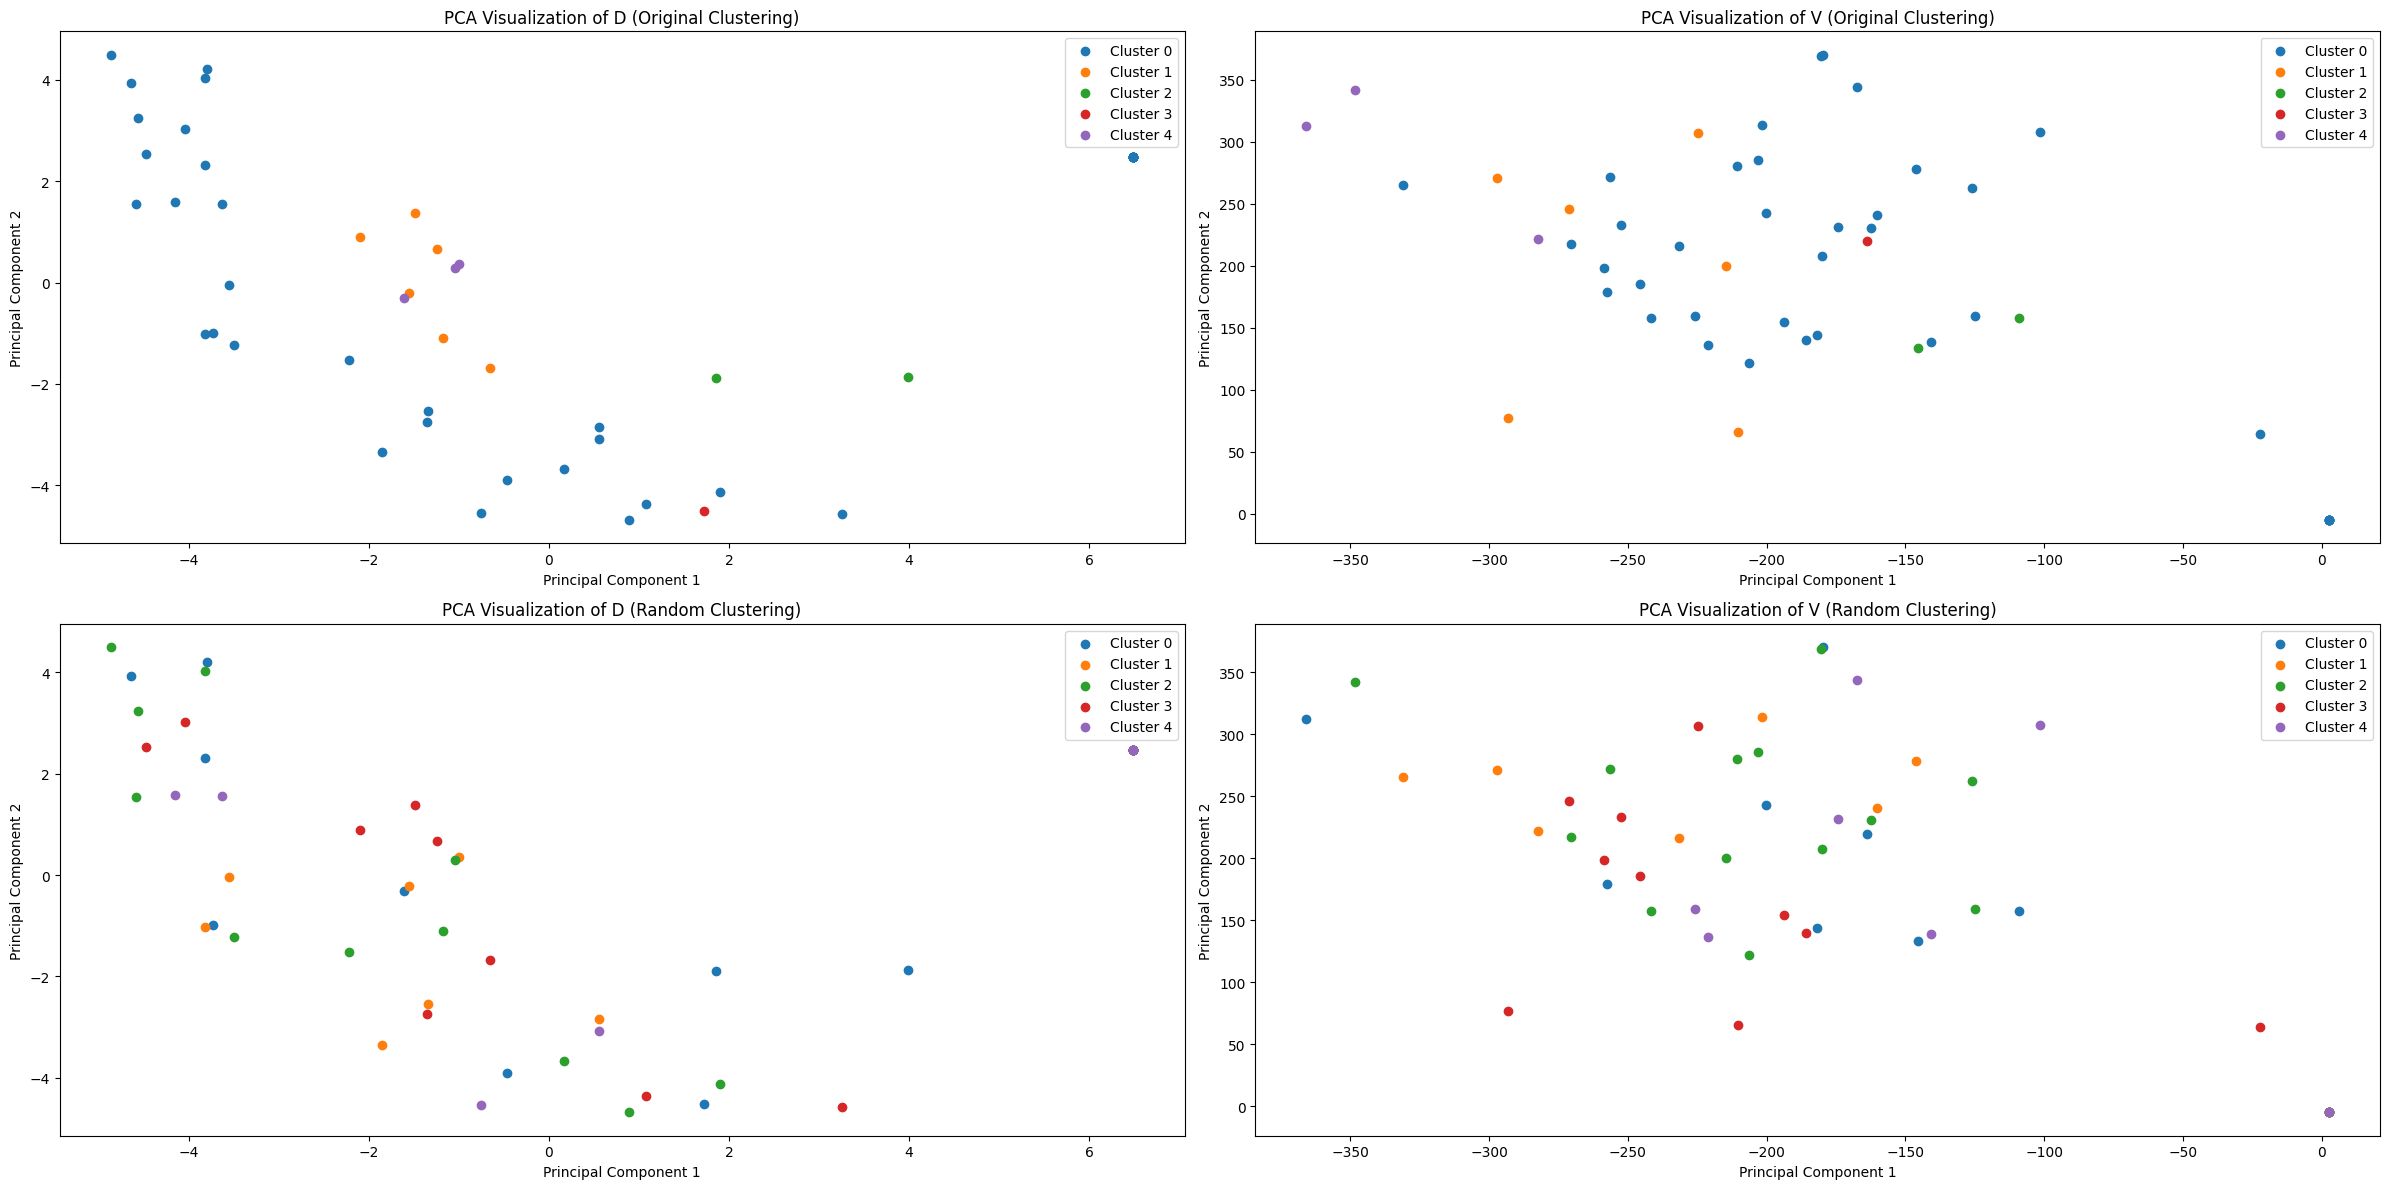

The silhouette score for D data (Original) is: 0.05402981734882715
The silhouette score for V data (Original) is: -0.1480600650926881
The silhouette score for D data (Random) is: -0.09405614635357315
The silhouette score for V data (Random) is: -0.06194601613100158


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


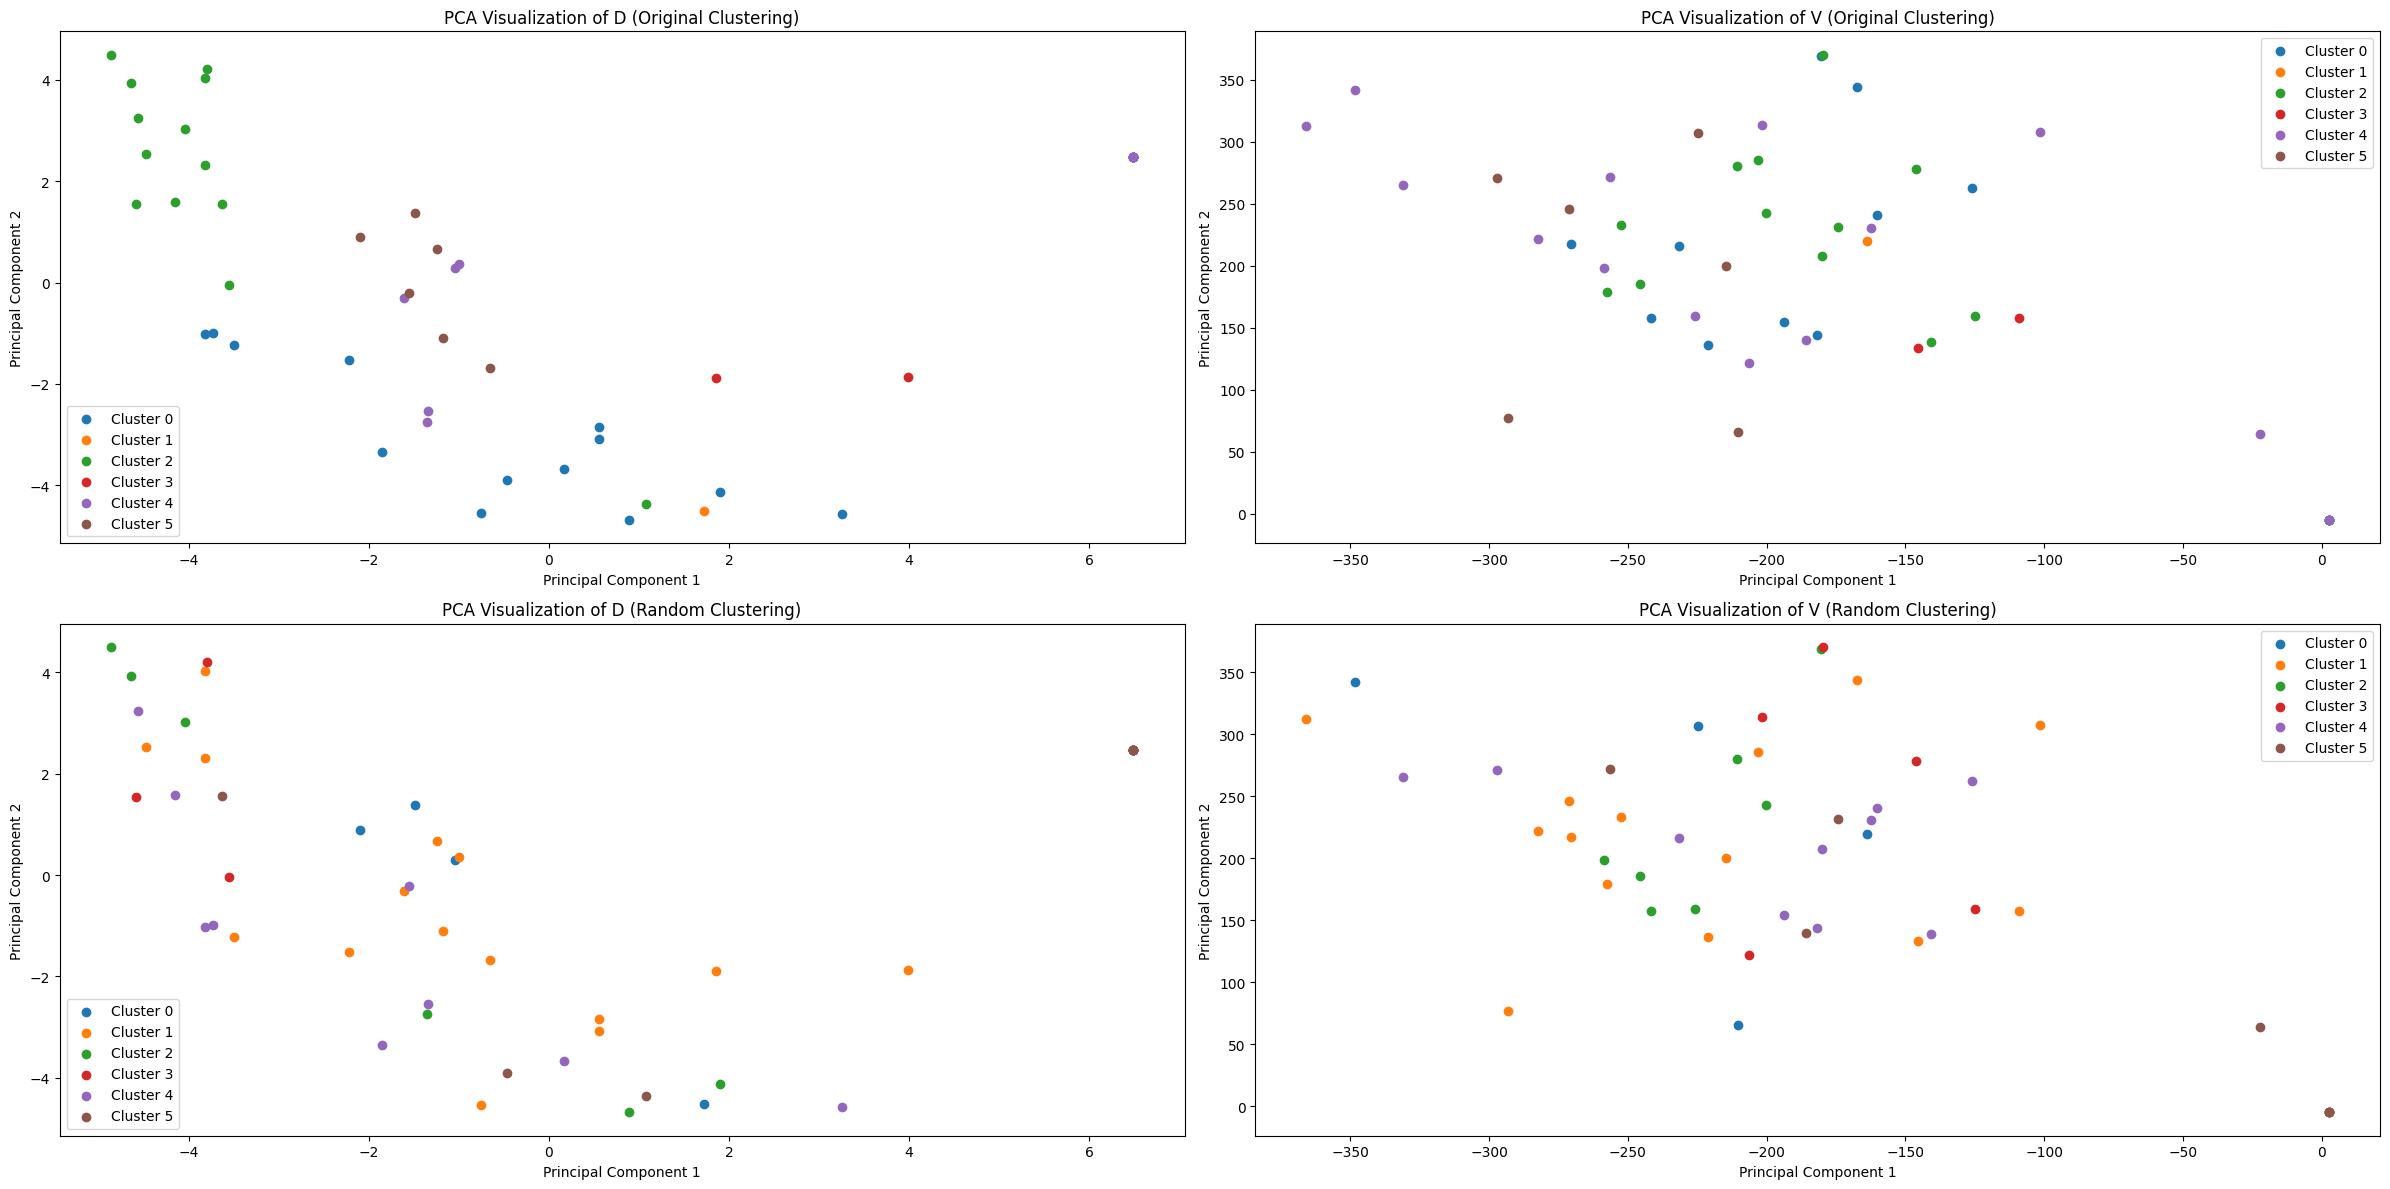

The silhouette score for D data (Original) is: 0.23544784408658118
The silhouette score for V data (Original) is: -0.15855417033257016
The silhouette score for D data (Random) is: -0.12538951133427784
The silhouette score for V data (Random) is: -0.07589395275700814


In [45]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 6, method='SpectralClustering')

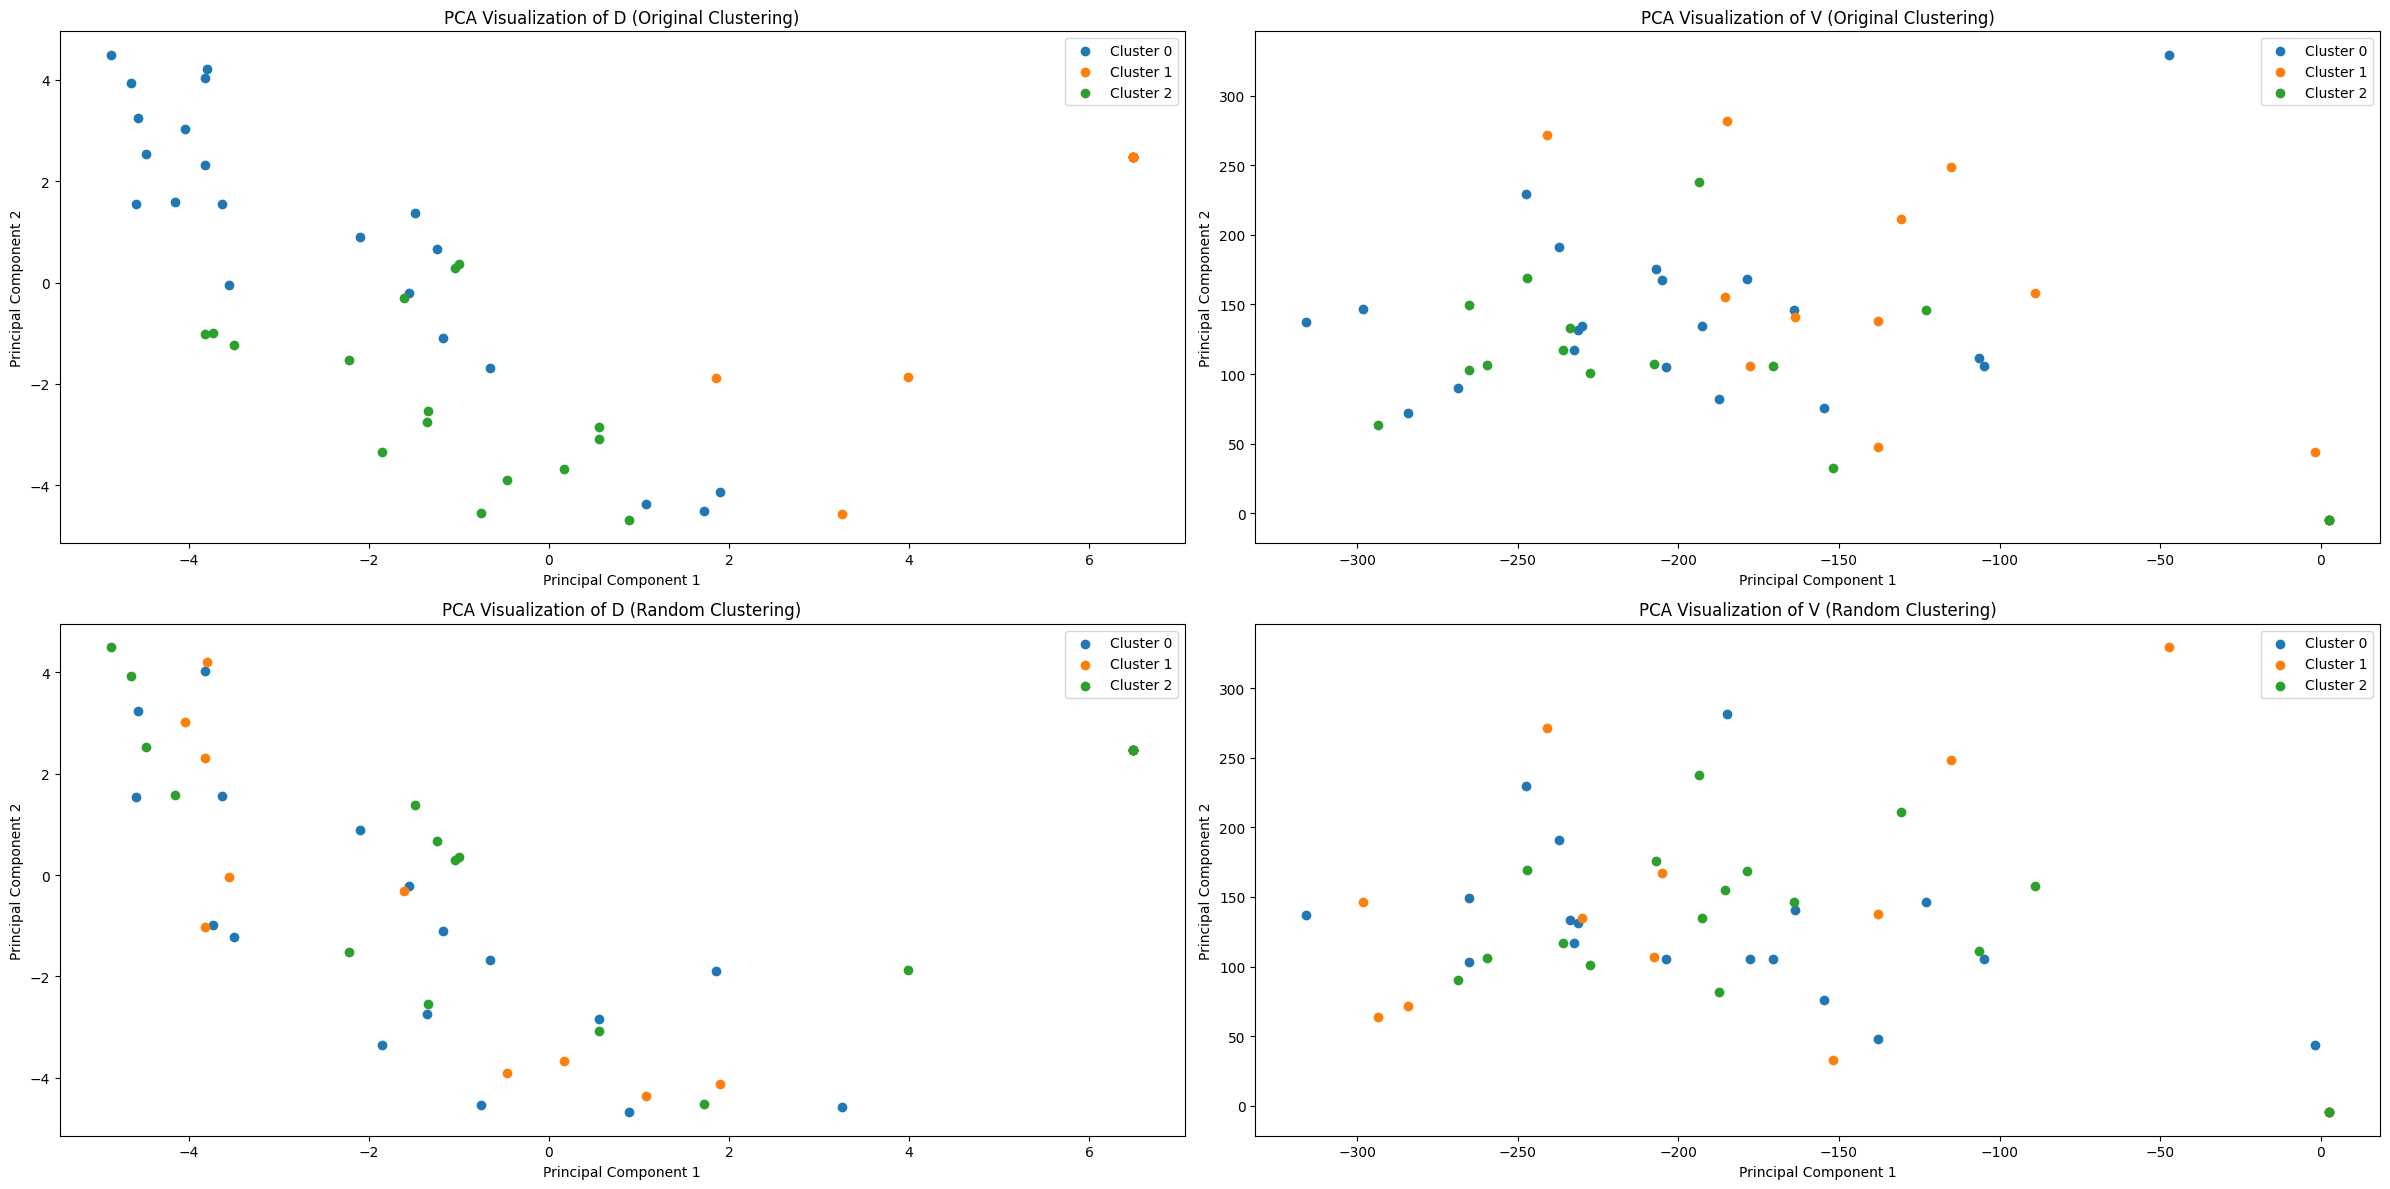

The silhouette score for D data (Original) is: 0.27343912346199784
The silhouette score for V data (Original) is: -0.0162914134437871
The silhouette score for D data (Random) is: -0.029482799494622847
The silhouette score for V data (Random) is: -0.034267022400568815


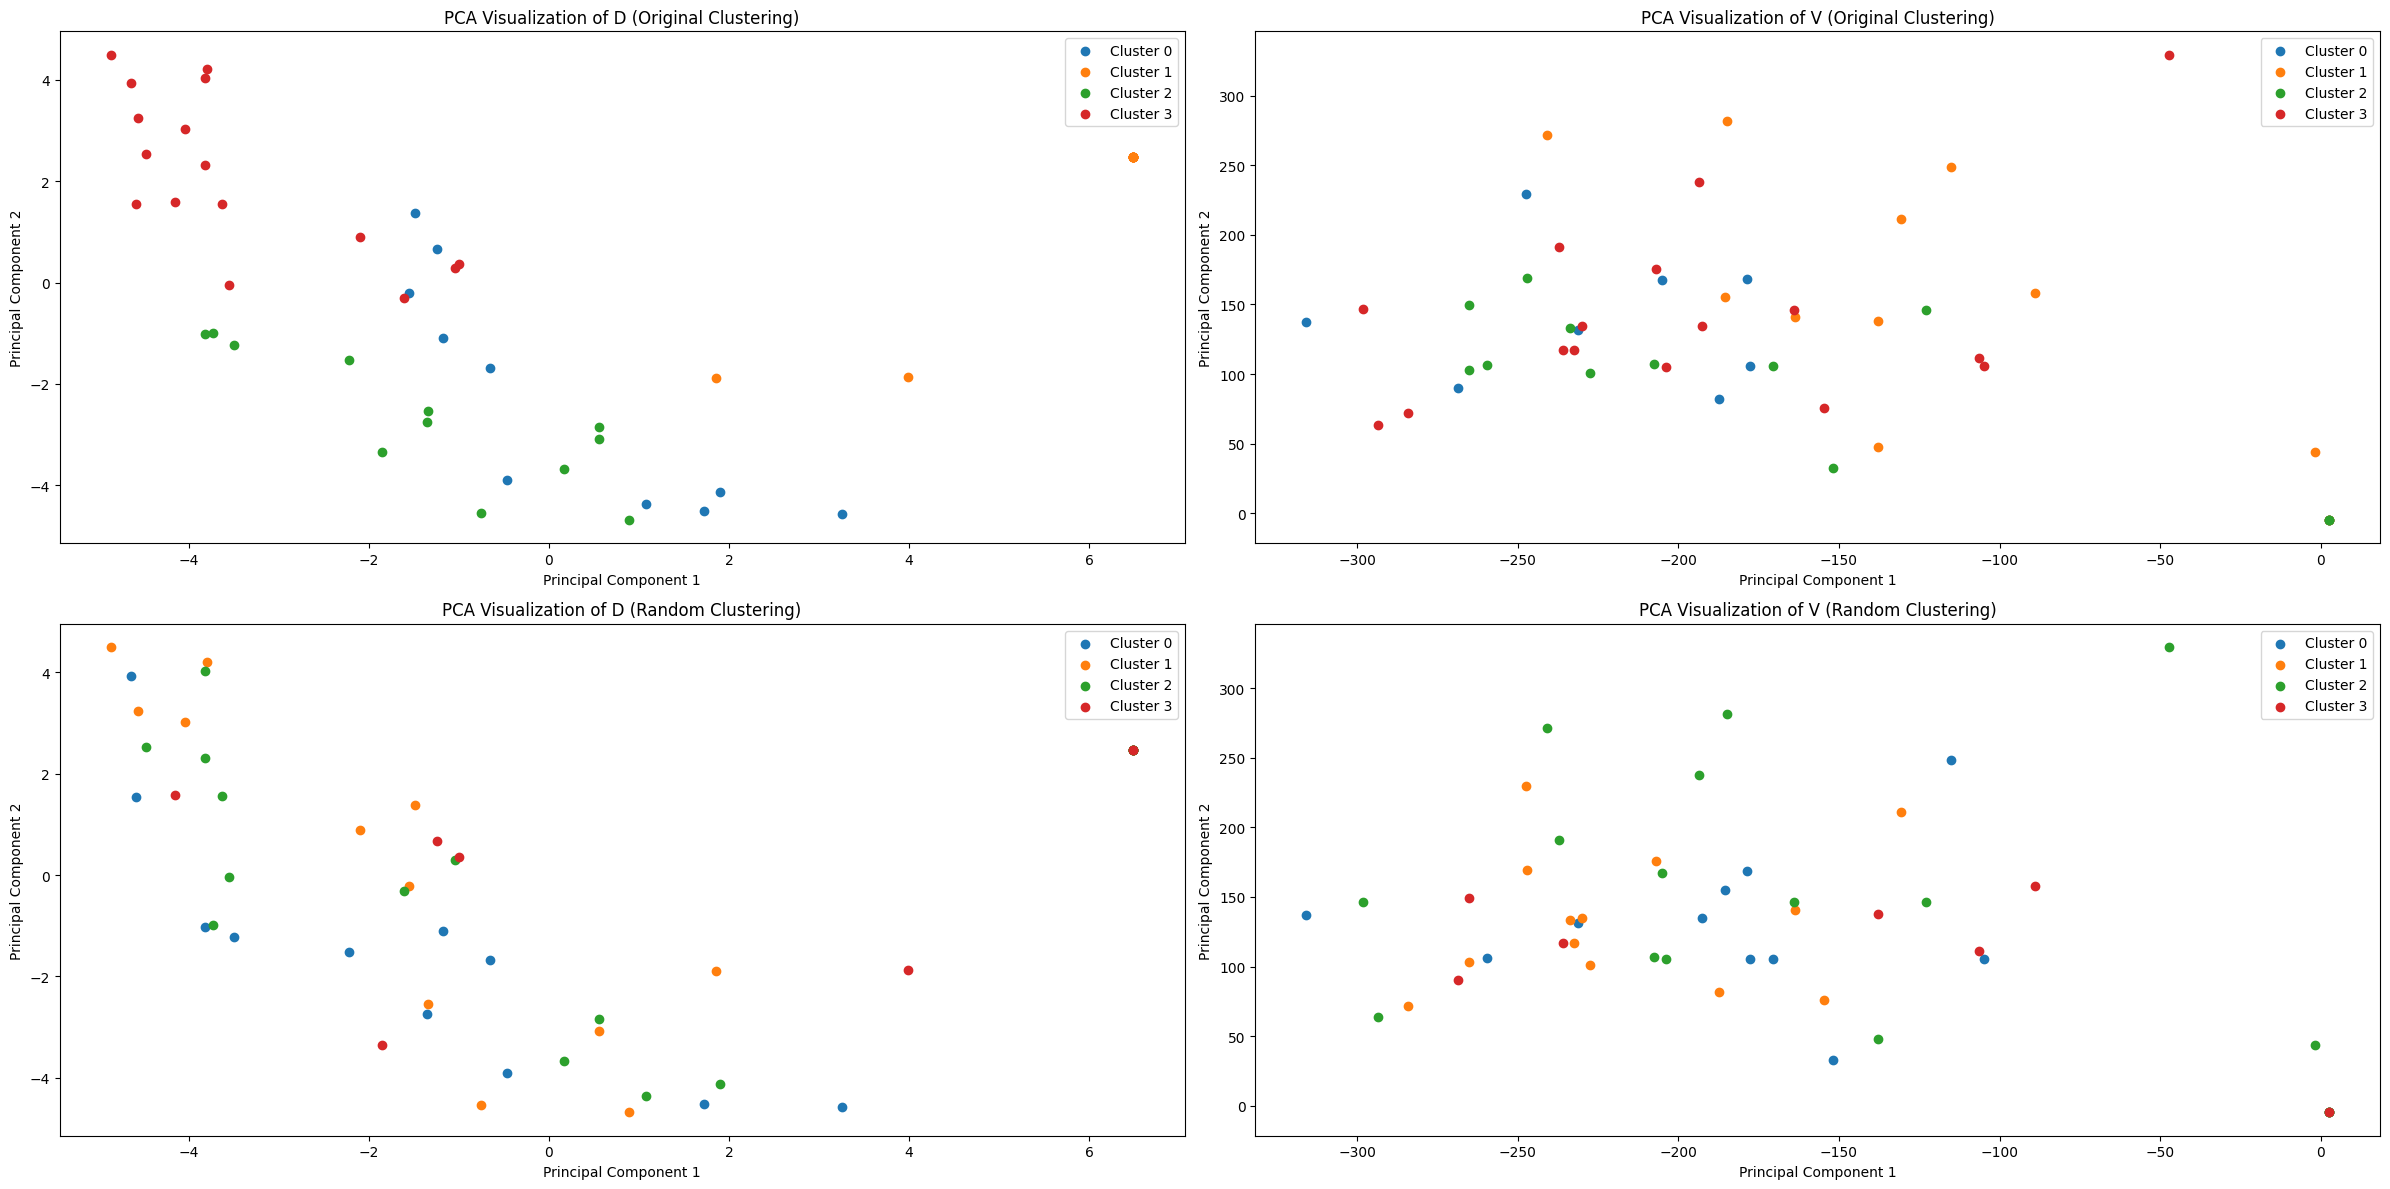

The silhouette score for D data (Original) is: 0.3203752068939478
The silhouette score for V data (Original) is: -0.03901030040899128
The silhouette score for D data (Random) is: -0.06980734861935954
The silhouette score for V data (Random) is: -0.048777608540636896


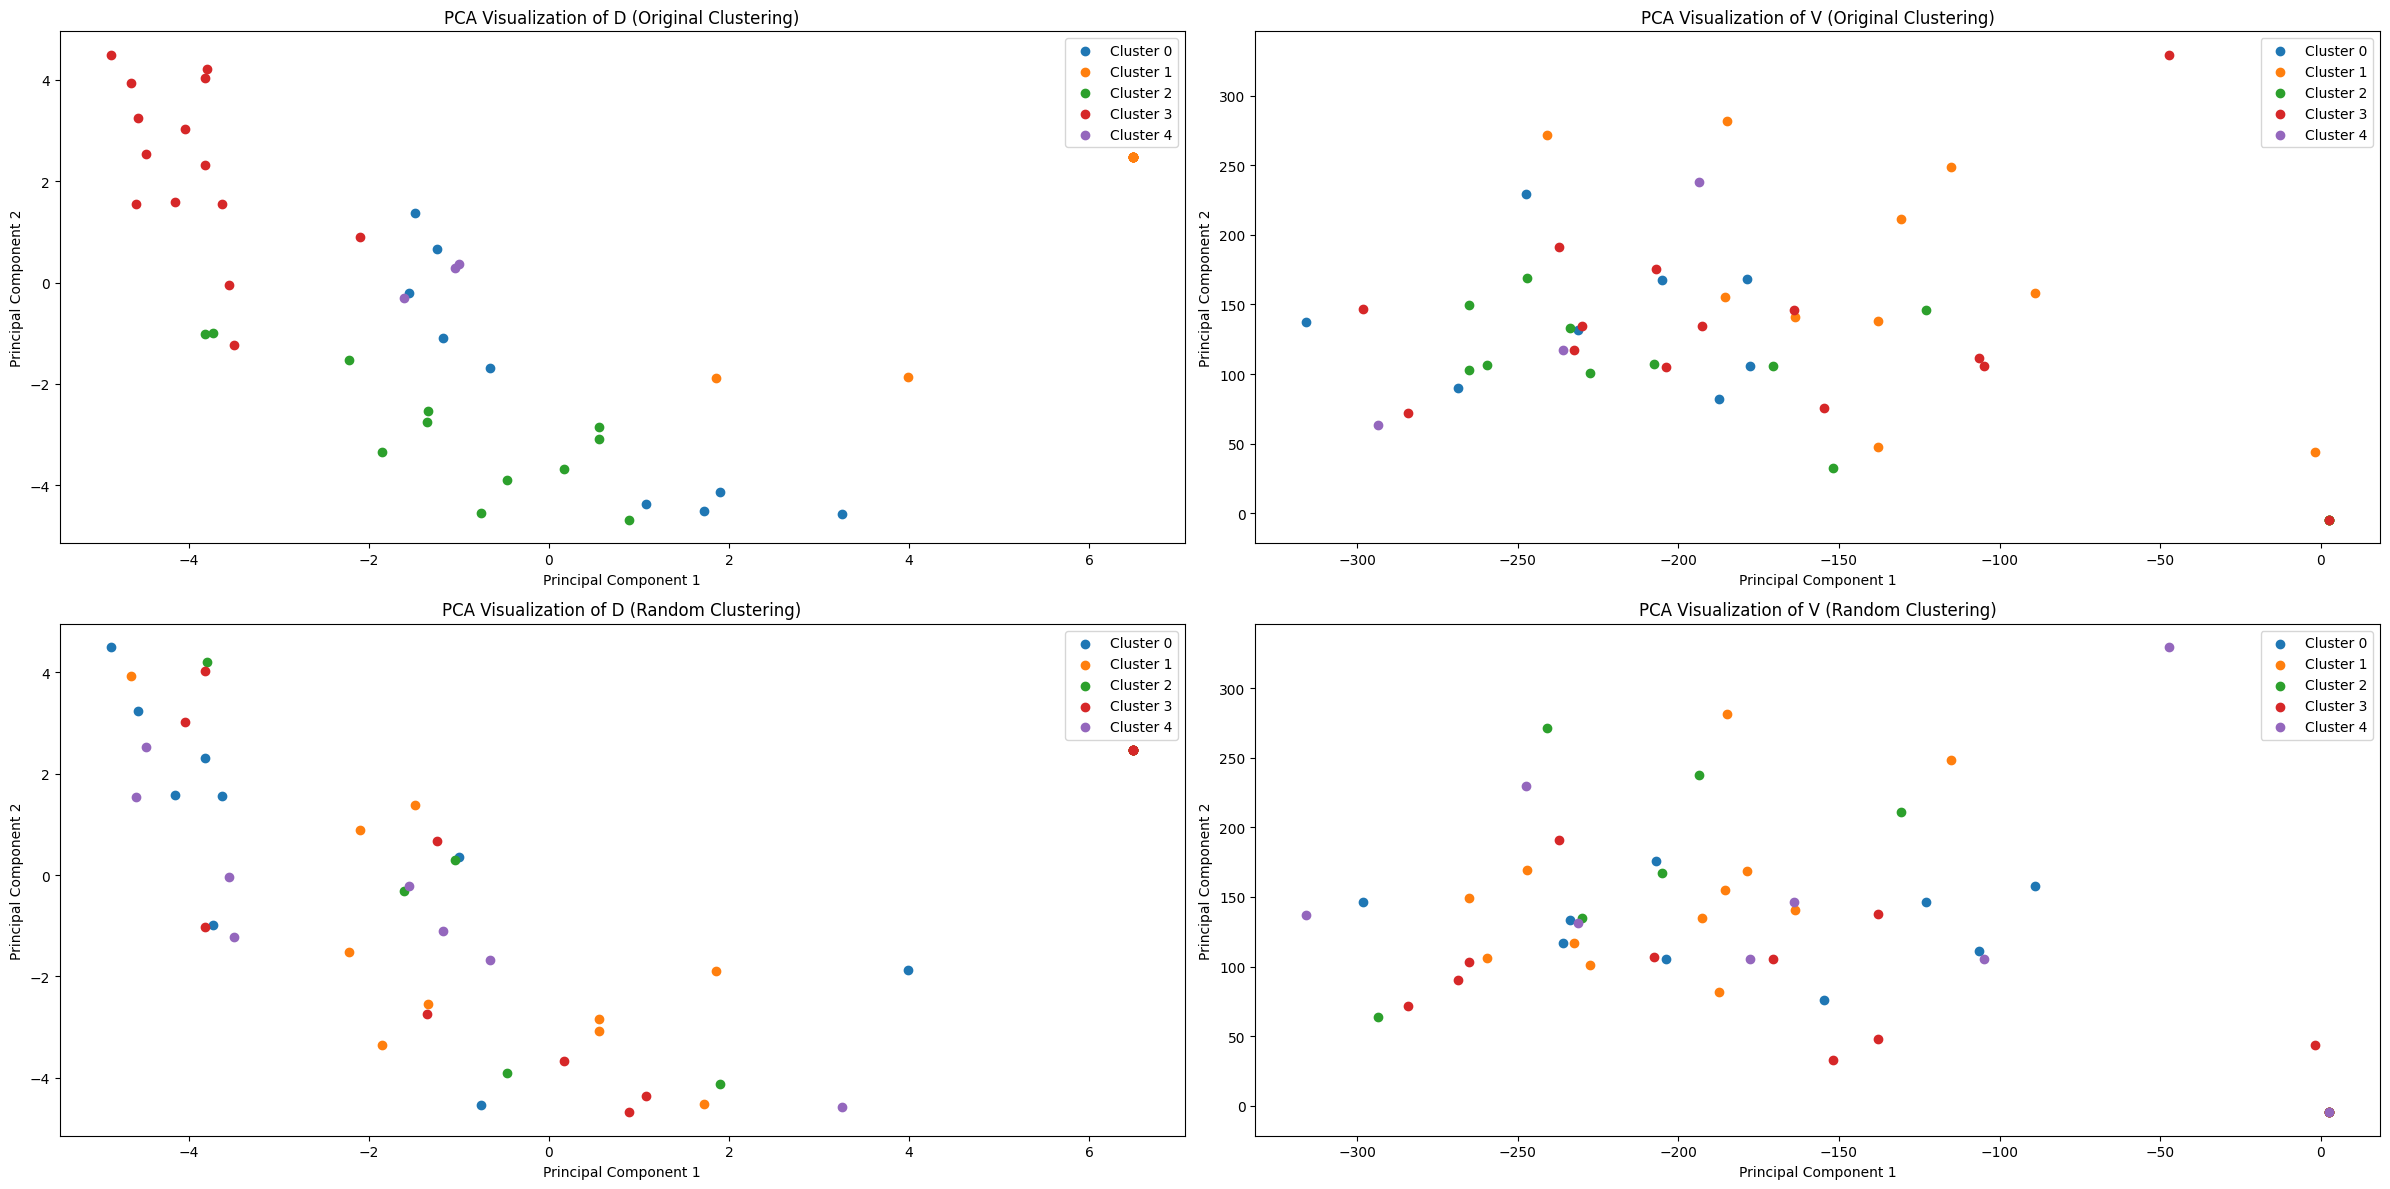

The silhouette score for D data (Original) is: 0.3399109489774598
The silhouette score for V data (Original) is: -0.053542774094768576
The silhouette score for D data (Random) is: -0.07894828071911646
The silhouette score for V data (Random) is: -0.07674355736079871


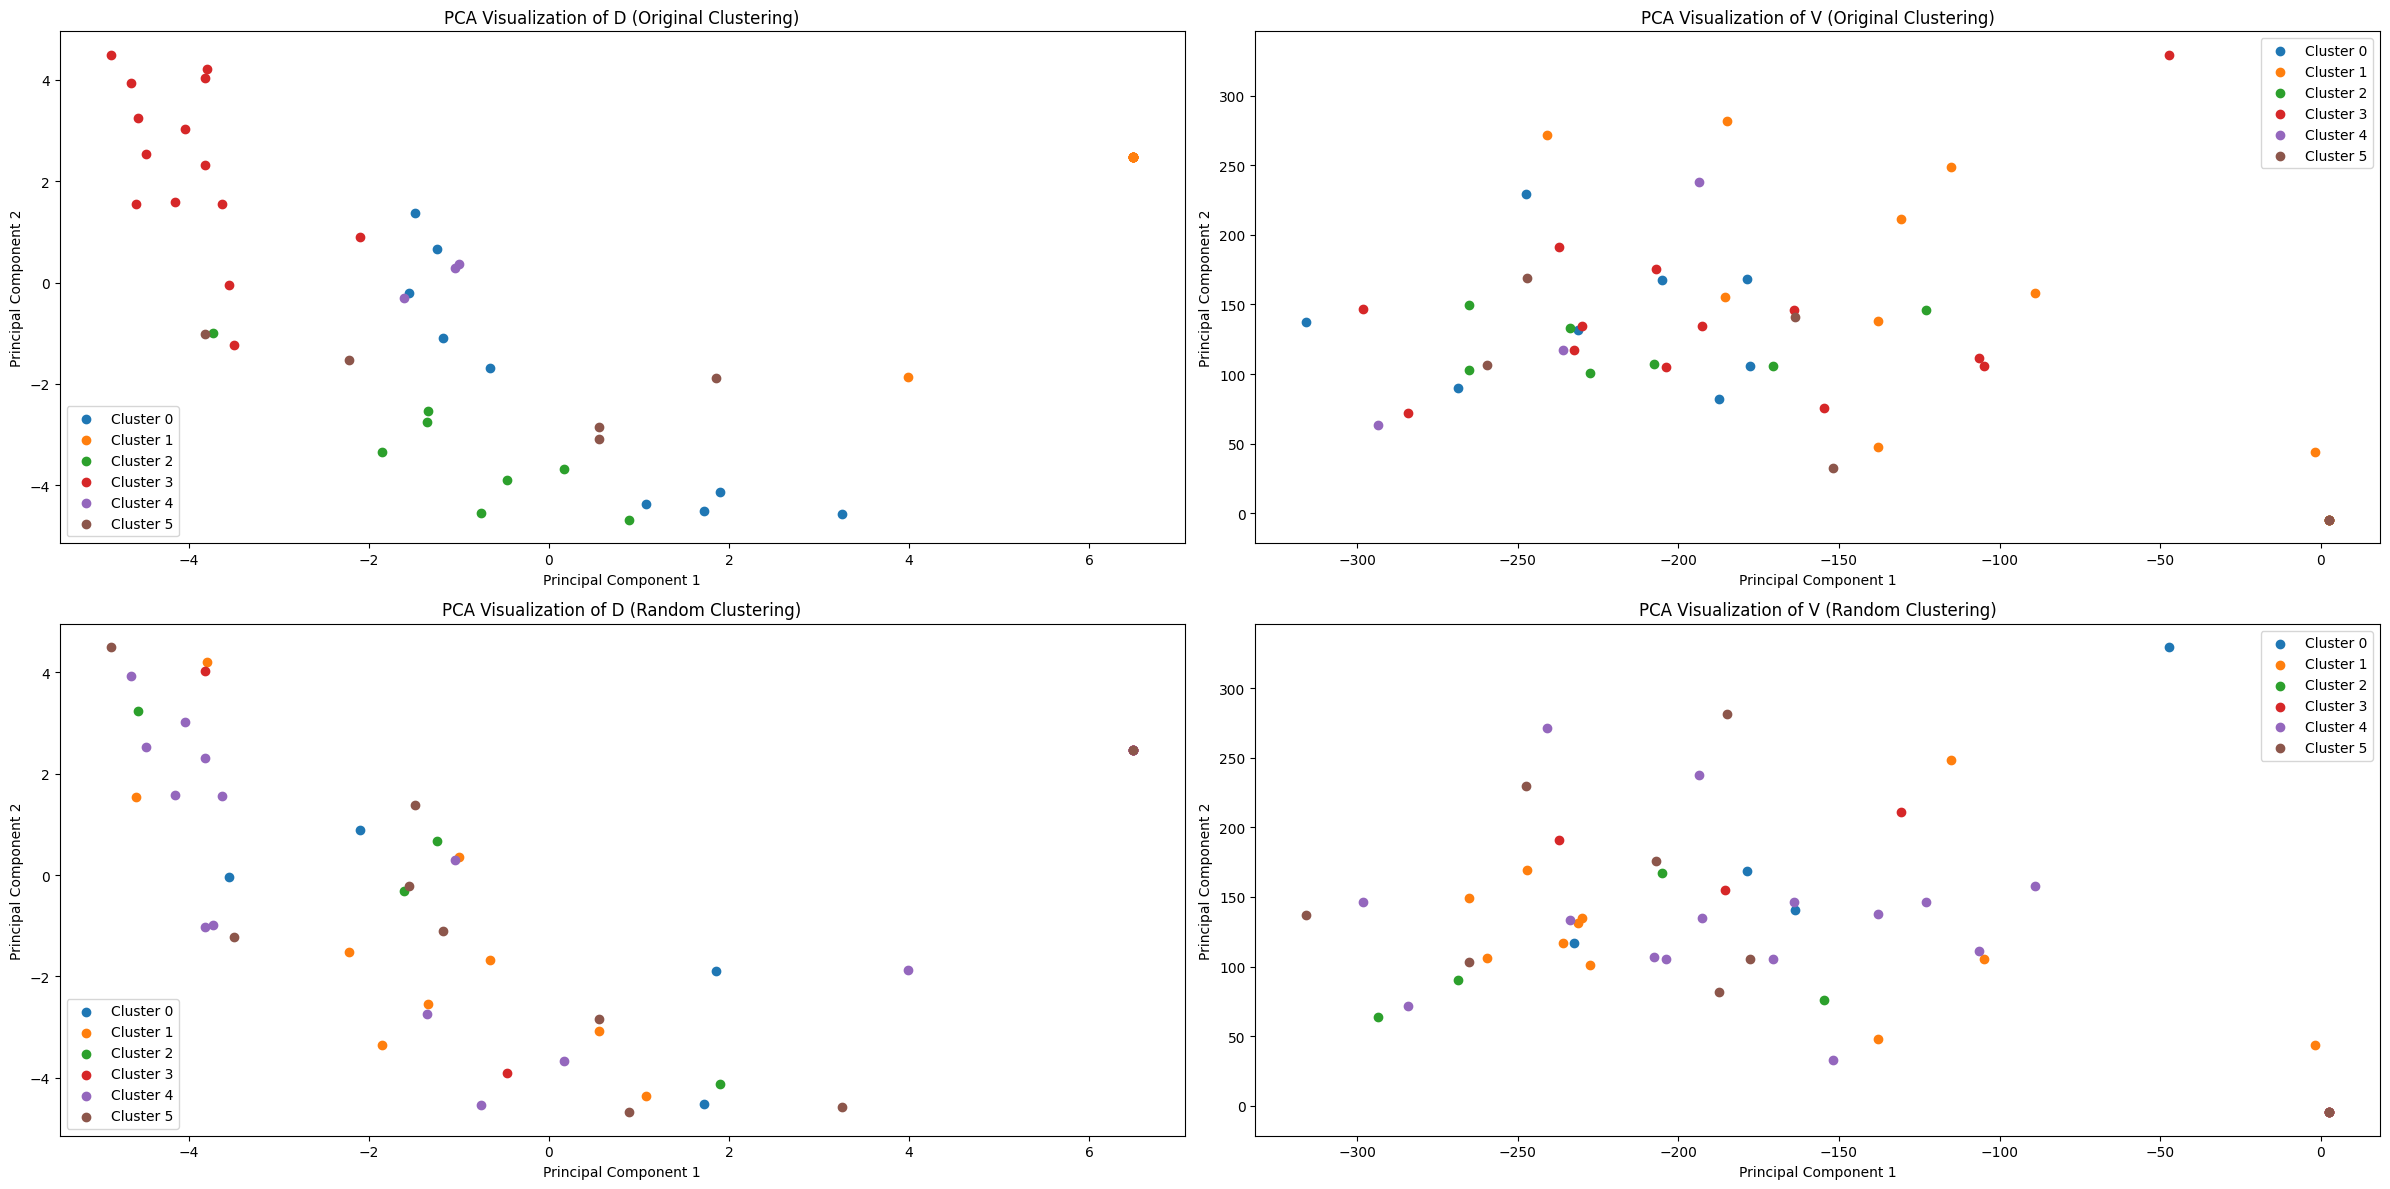

The silhouette score for D data (Original) is: 0.3177506662858891
The silhouette score for V data (Original) is: -0.06262385487787843
The silhouette score for D data (Random) is: -0.11801483091759007
The silhouette score for V data (Random) is: -0.07732846051716413


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


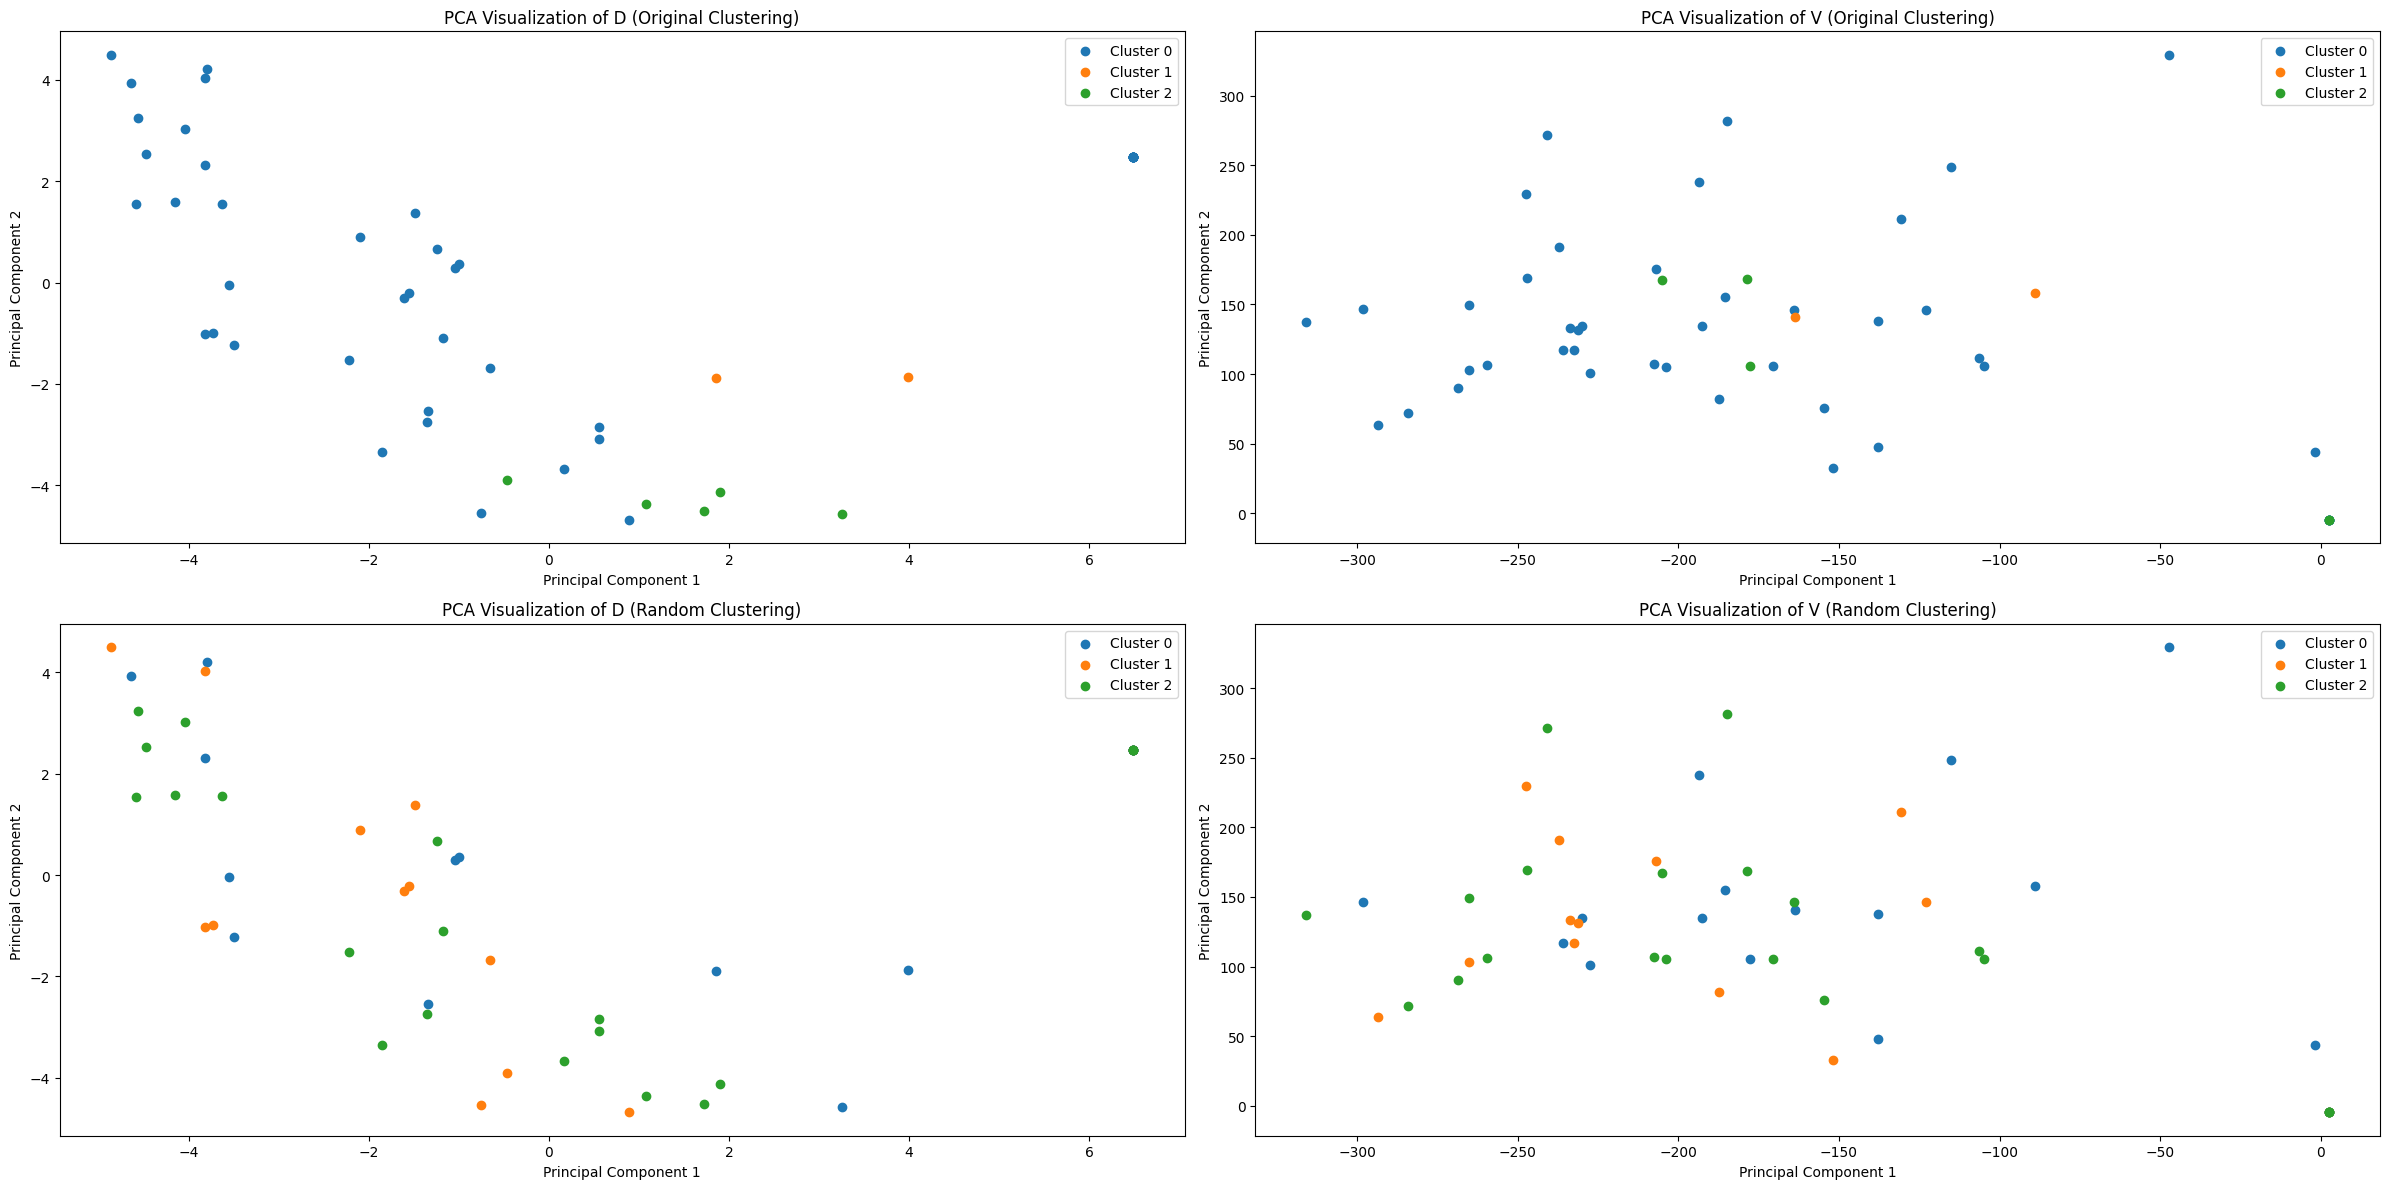

The silhouette score for D data (Original) is: 0.09894566771759679
The silhouette score for V data (Original) is: -0.029923079493397228
The silhouette score for D data (Random) is: -0.025256235523236466
The silhouette score for V data (Random) is: -0.029697867571769062


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


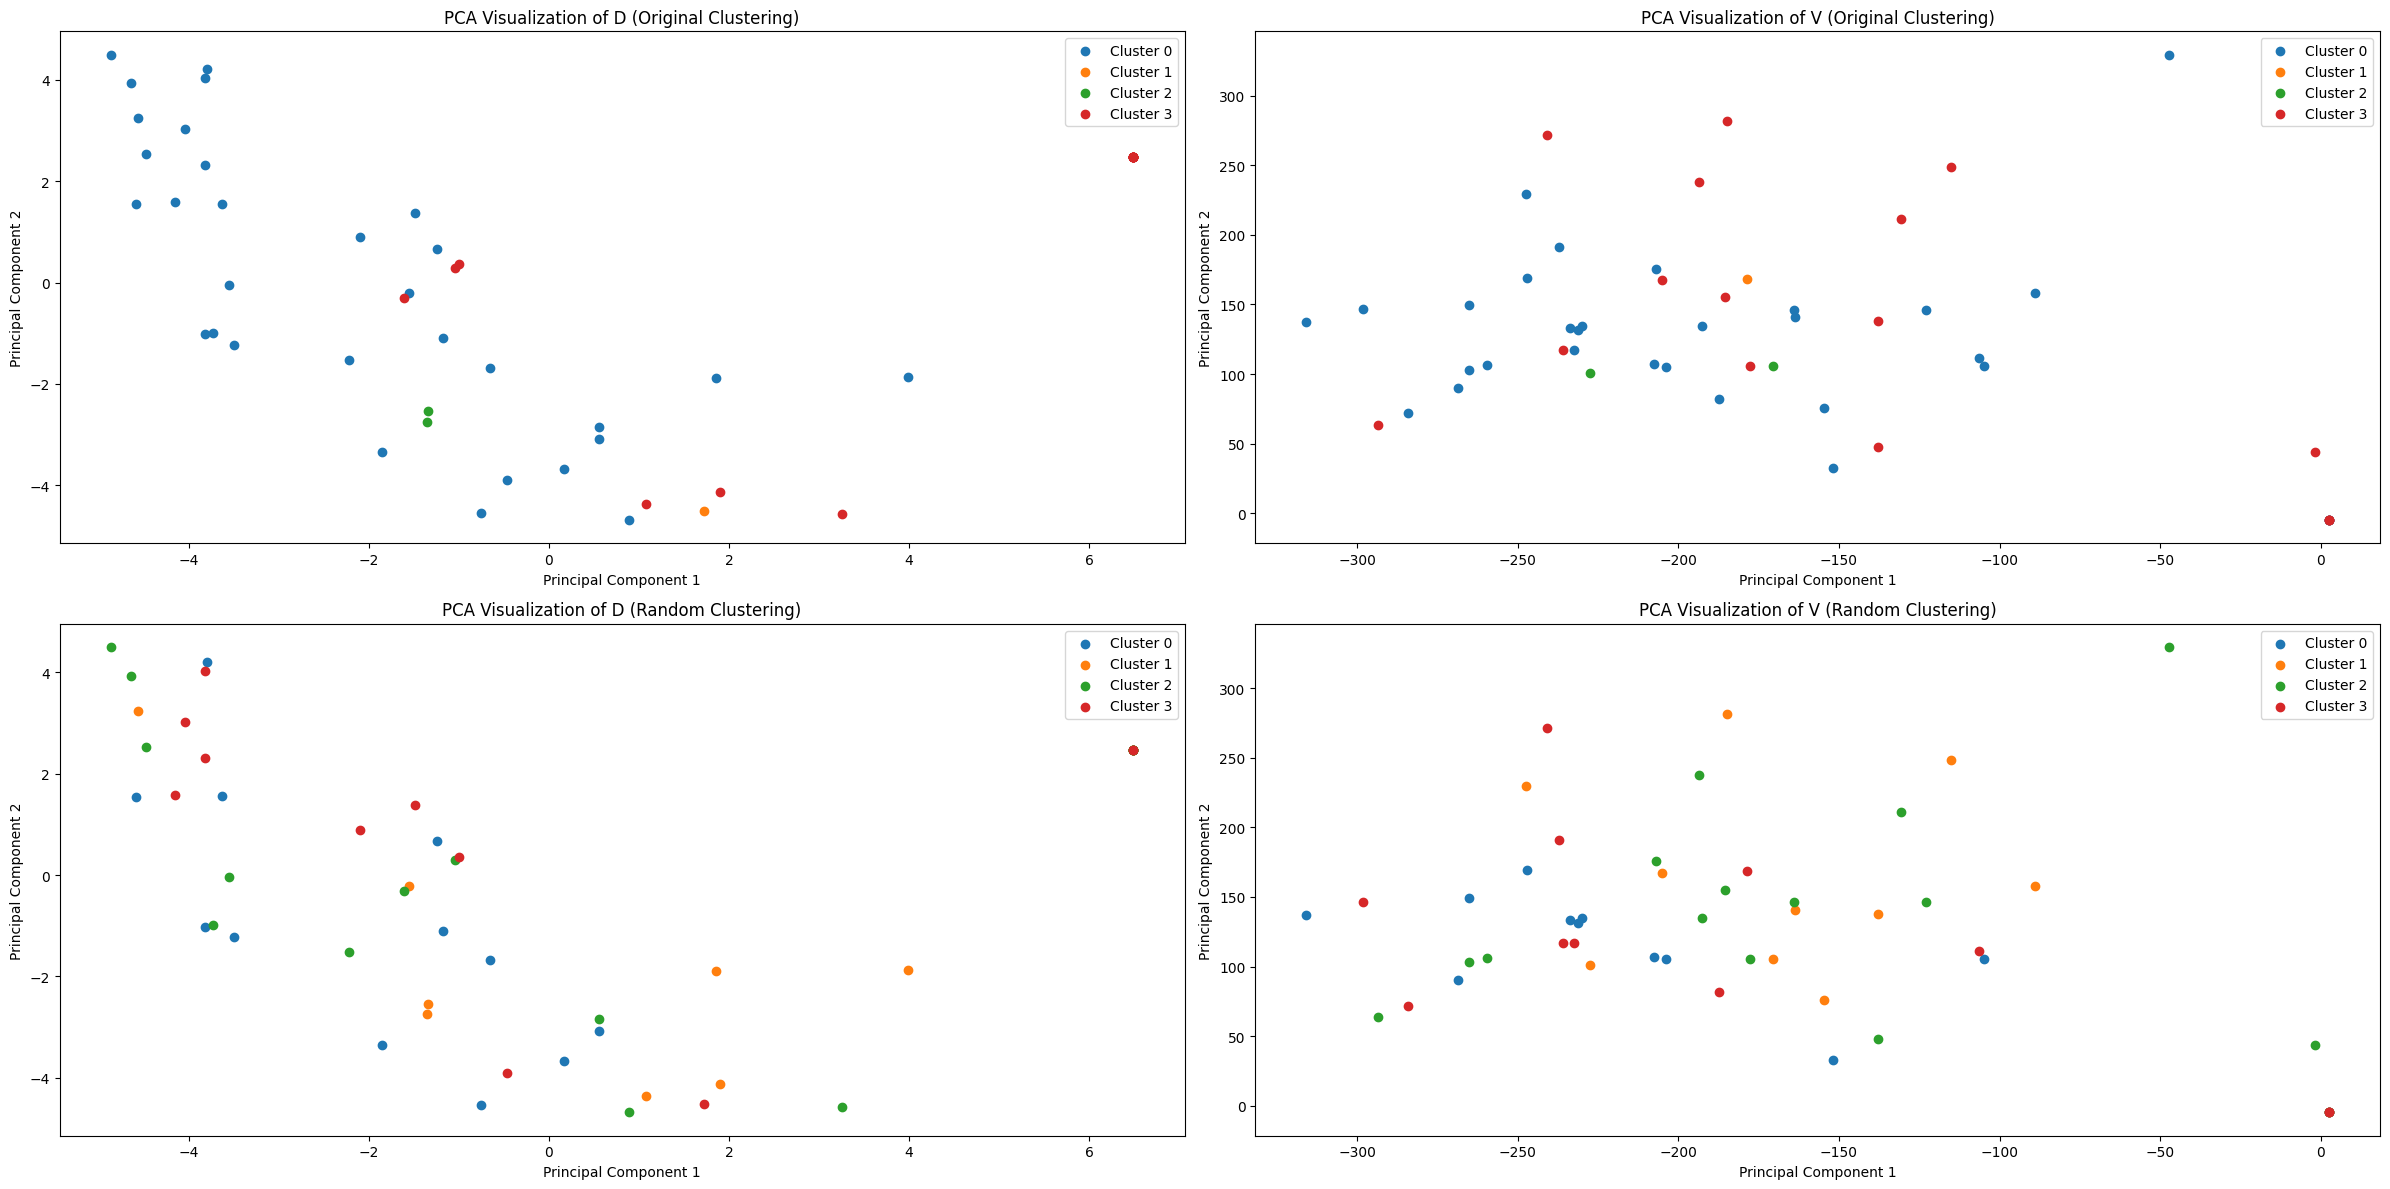

The silhouette score for D data (Original) is: 0.16070419254348547
The silhouette score for V data (Original) is: -0.13177954791723537
The silhouette score for D data (Random) is: -0.05285417412984335
The silhouette score for V data (Random) is: -0.0415970002883702


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


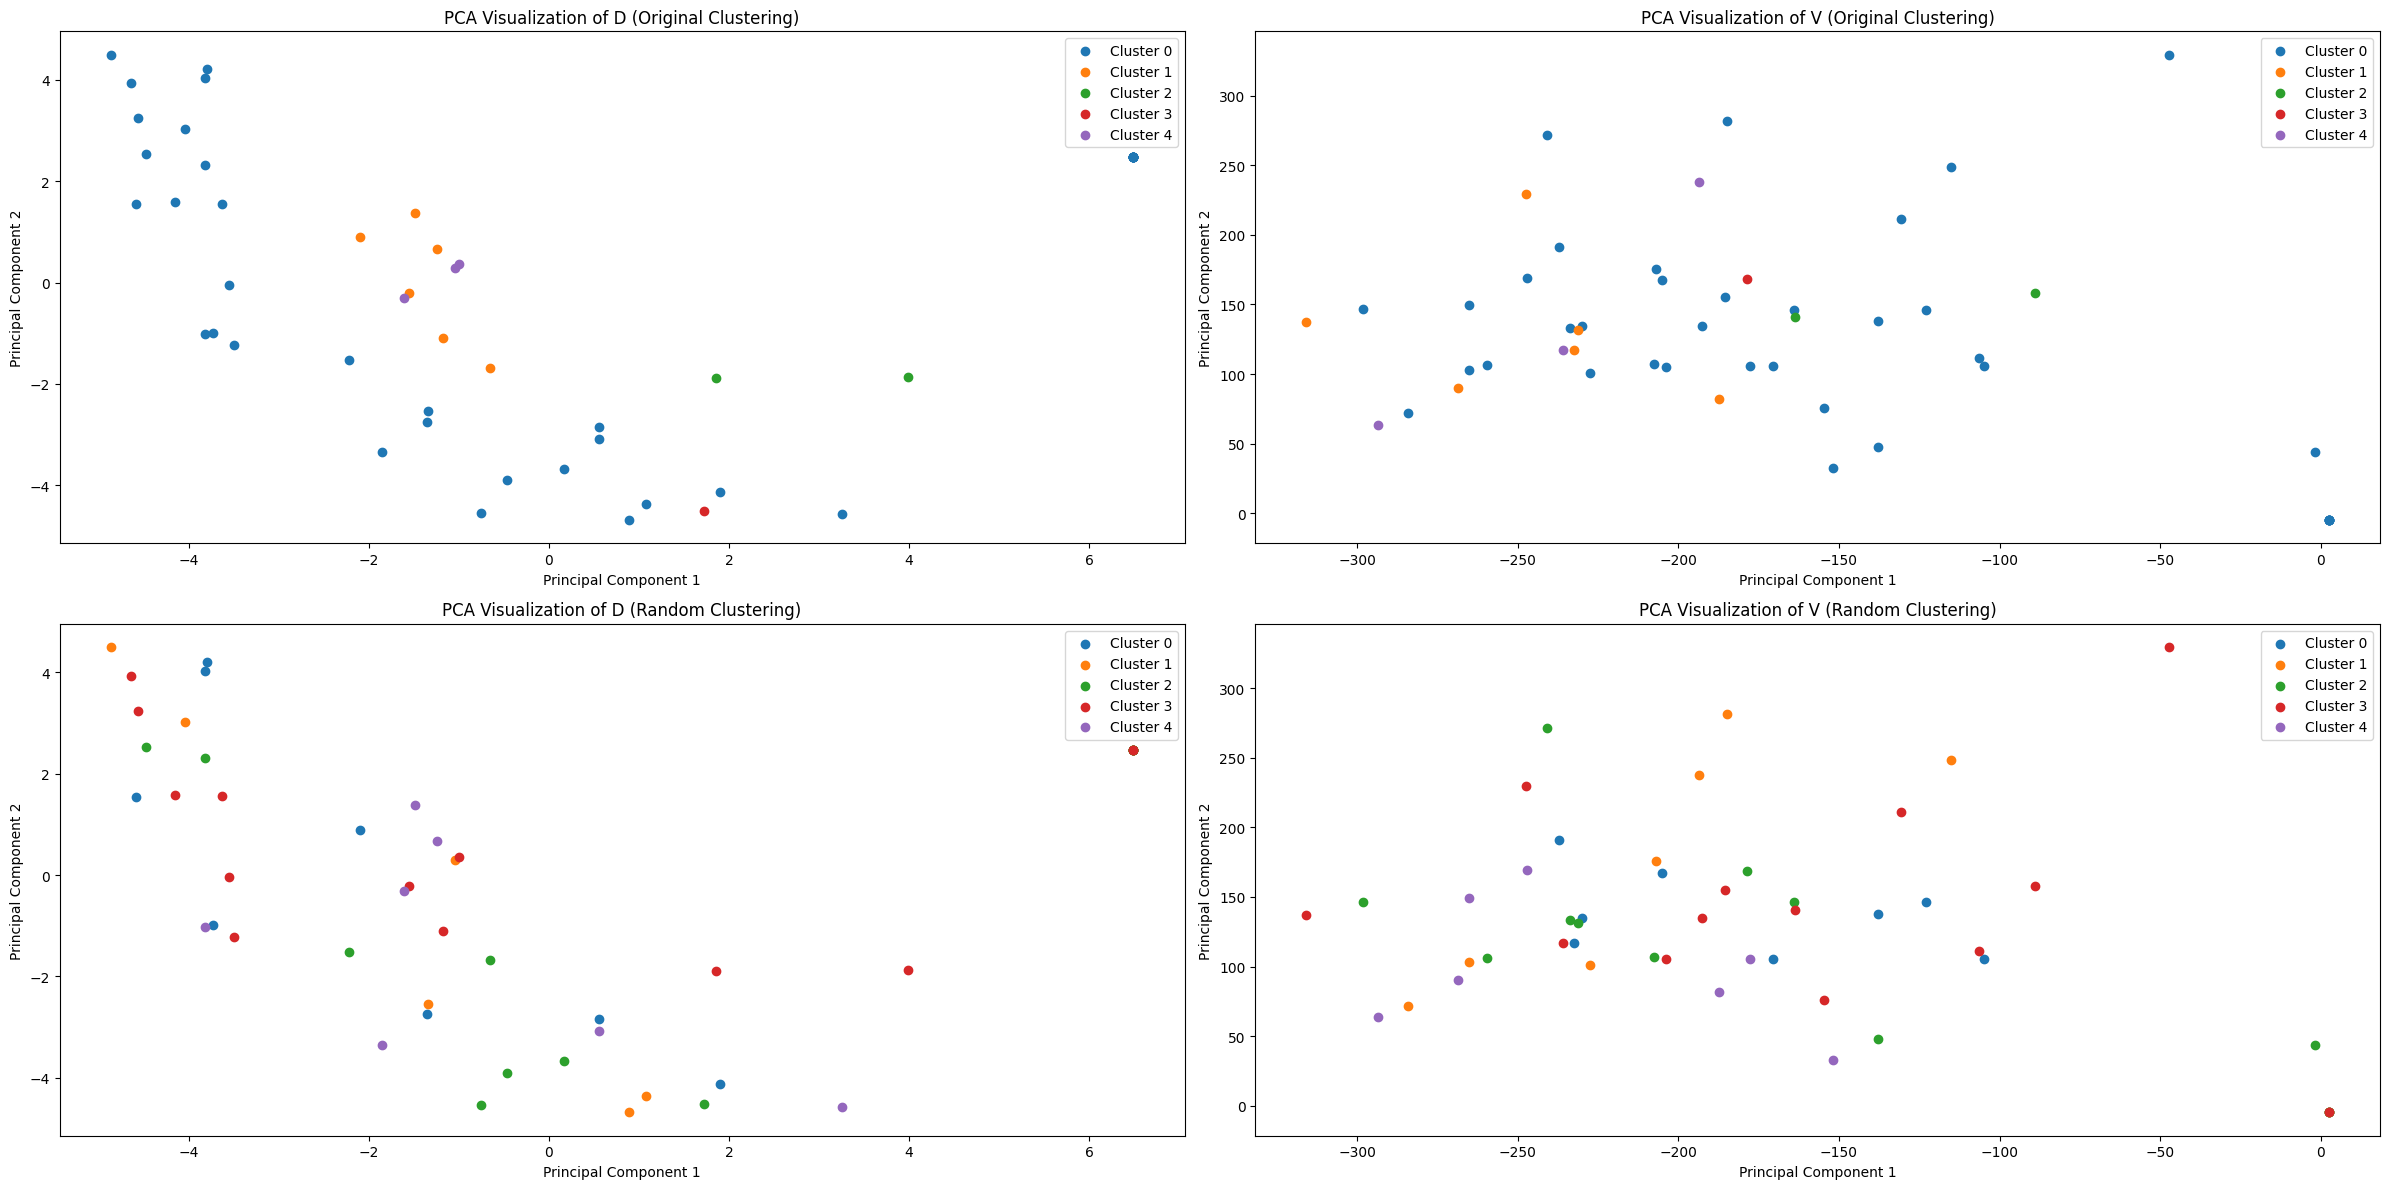

The silhouette score for D data (Original) is: 0.05402981734882715
The silhouette score for V data (Original) is: -0.1419804426821549
The silhouette score for D data (Random) is: -0.0808026334879881
The silhouette score for V data (Random) is: -0.0642735409986665


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


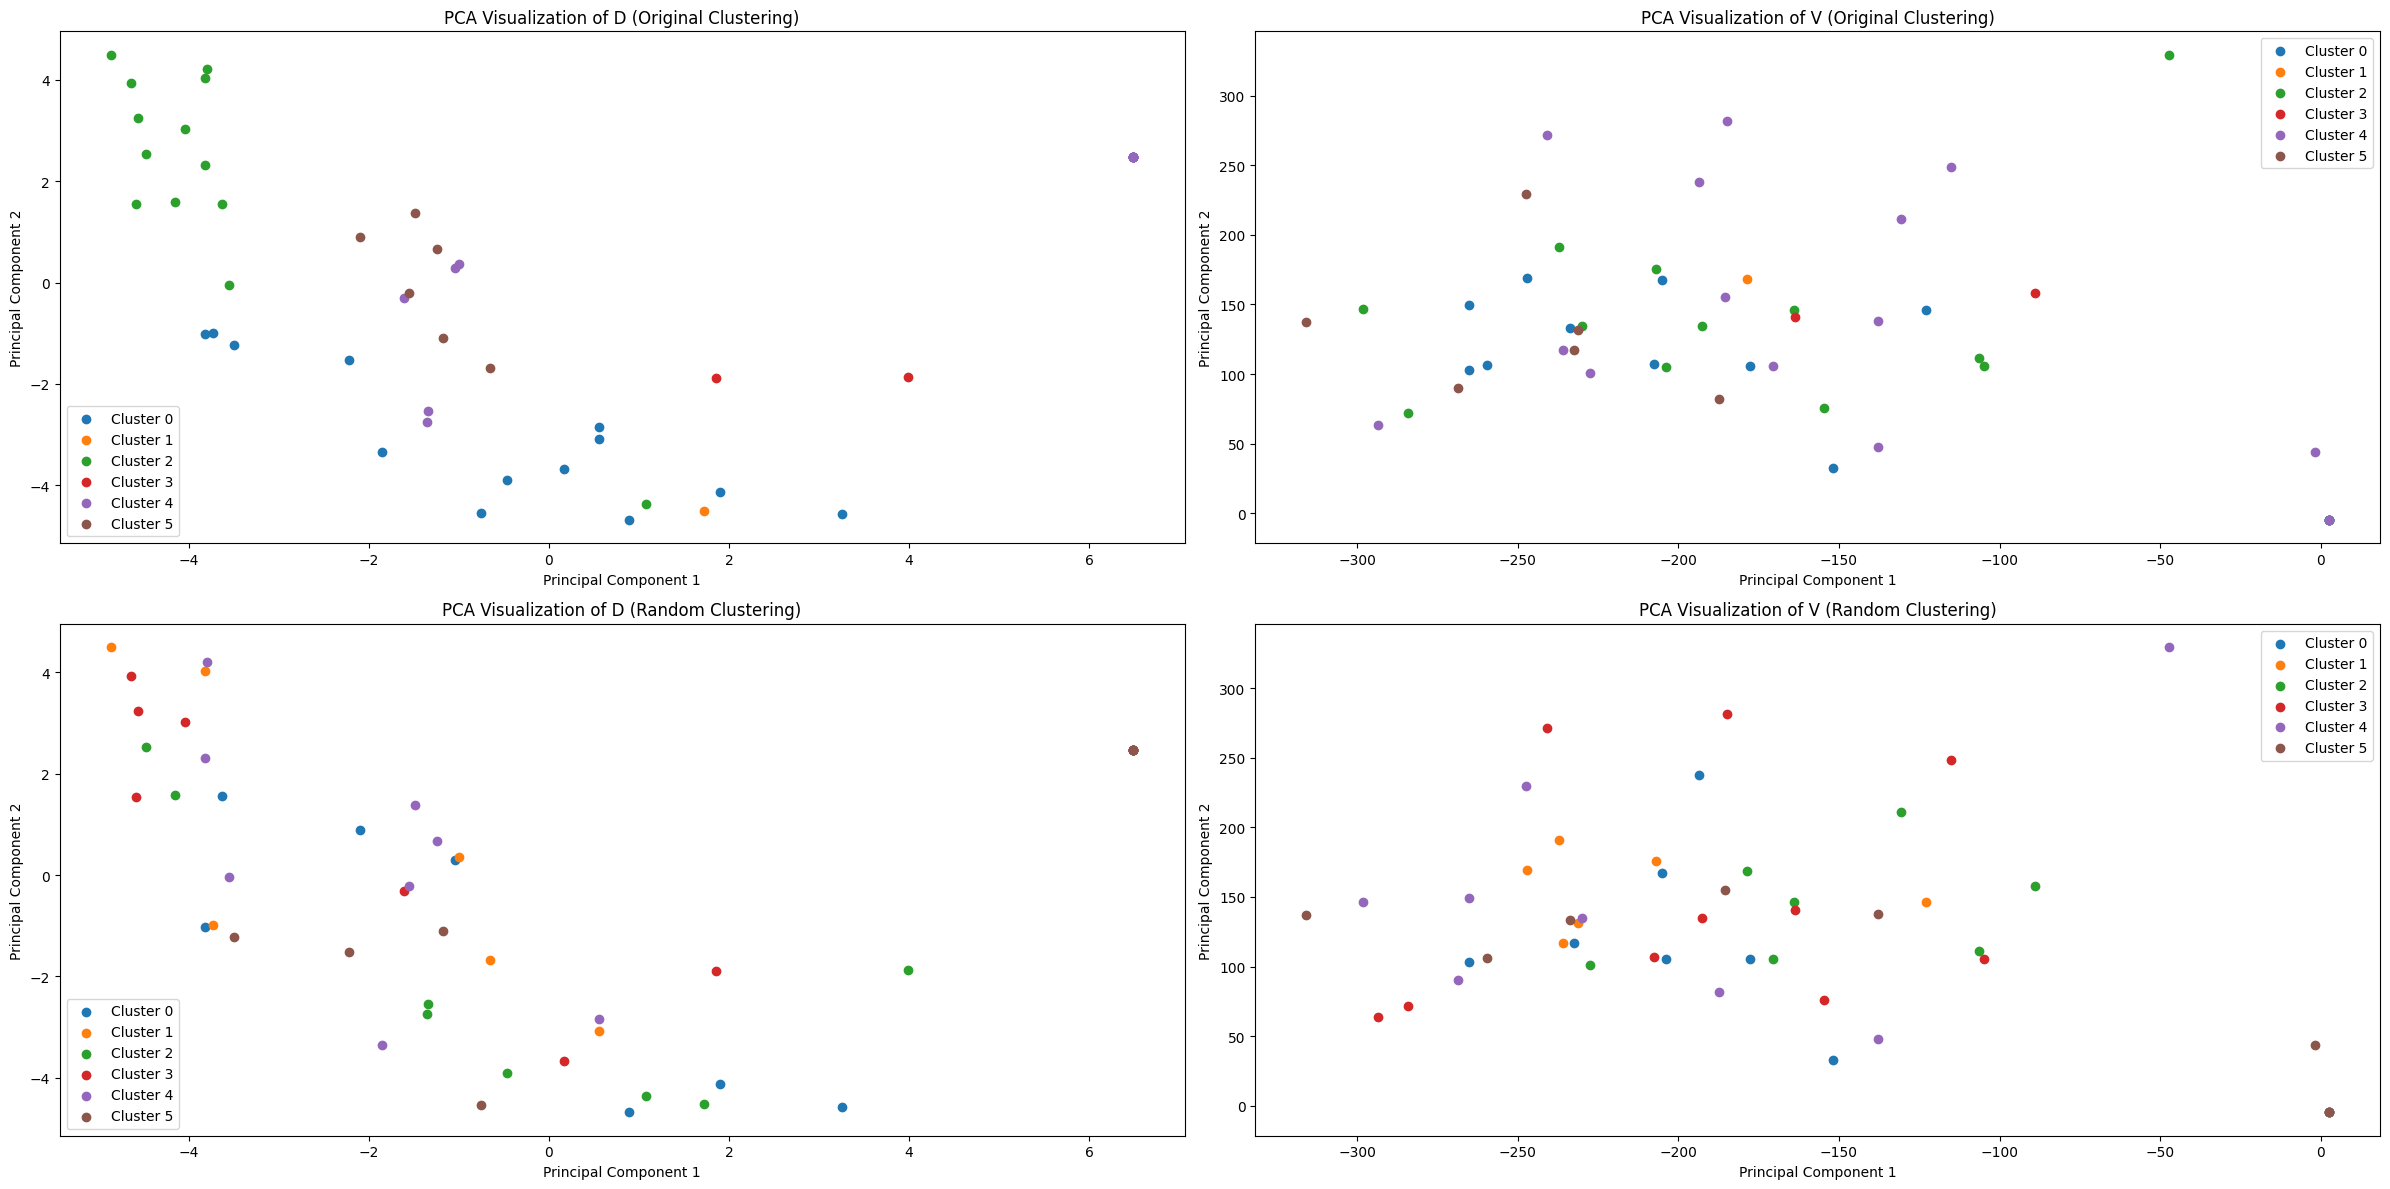

The silhouette score for D data (Original) is: 0.23544784408658118
The silhouette score for V data (Original) is: -0.15181183081678215
The silhouette score for D data (Random) is: -0.10906152469396461
The silhouette score for V data (Random) is: -0.07333936642861387


In [46]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 6, method='SpectralClustering')